##Imports

In [ ]:
import json
import os
 
import traceback
import sys
import time
import random
 
import pandas as pd
import datetime
import math
from sklearn.metrics import mean_squared_error
 
import matplotlib.pyplot as plt
 
import numpy as np
from numpy import array
import copy
 
import tensorflow as tf
 
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras import backend as K
 
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
 
from tensorflow import metrics, keras

In [ ]:
#Need a place to write log files to in colab.
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Use wget to load this data into colab - not needed for python code as it's pulling from directory
!wget "https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv"
!wget "https://storage.googleapis.com/covid19-open-data/v2/index.csv"
!wget "https://storage.googleapis.com/covid19-open-data/v2/oxford-government-response.csv"
!wget "https://storage.googleapis.com/covid19-open-data/v2/demographics.csv"
!wget "https://storage.googleapis.com/covid19-open-data/v2/mobility.csv"
#!wget "https://storage.googleapis.com/covid19-open-data/v2/main.csv"

--2021-05-10 16:39:54--  https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254934728 (243M) [text/csv]
Saving to: ‘epidemiology.csv.1’

epidemiology.csv.1  100%[===================>] 243.12M   177MB/s    in 1.4s    

2021-05-10 16:39:56 (177 MB/s) - ‘epidemiology.csv.1’ saved [254934728/254934728]

--2021-05-10 16:39:56--  https://storage.googleapis.com/covid19-open-data/v2/index.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2360655 (2.3M) [text/csv]
Saving to: ‘index.csv.1’

index.csv.1      

##Covid Info Class - A

In [ ]:
class CovidInfo(object):
    def __init__(self, dem_data, epi_data, main_data, mob_data, index_data, gov_resp_data):
        self.dem_data = dem_data
        self.epi_data = epi_data
        self.main_data = main_data
        self.mob_data = mob_data
        self.index_data = index_data
        self.gov_resp_data = gov_resp_data

        self.rural_limit = 10000
        self.suburban_limit = 100000
        self.start_date = datetime.datetime(2020, 9, 1)
        self.no_of_days = 150
        self.no_of_training_days = 125

        # Used to run model.predict in testing days out.
        self.prediction_days = 1
        self.sequence_length = 10
        self.days_to_predict = 5
        self.index = 5
        self.batch_size = 2048
        self.epochs = 1000

##CovidDataLoader

In [ ]:
class CovidDataLoader(object):
    def __init__(self, is_local, use_small_data_set, county_type):
        # if is_local:
        #     self.root_location = '~/opt/anaconda3/envs/BigData/project-data'
        #     self.log_rural_location = '/Users/karenrivera/opt/anaconda3/envs/BigData/project-data/logs'
        #     self.log_suburban_location = '/Users/karenrivera/opt/anaconda3/envs/BigData/project-data/logs'
        #     self.log_urban_location = '/Users/karenrivera/opt/anaconda3/envs/BigData/project-data/logs'
        # else:
        #     self.root_location = '~cs535/cs535a'
        #     self.log_rural_location = '/s/bach/b/class/cs535/cs535a/logs-US-rural'
        #     self.log_suburban_location = '/s/bach/b/class/cs535/cs535a/logs-US-suburban'
        #     self.log_urban_location = '/s/bach/b/class/cs535/cs535a/logs-US-urban'

        # self.use_small_data_set = use_small_data_set
        # self.county_type = county_type

        # self.dem_file_name = self.root_location + '/demographics.csv'
        # self.epi_file_name = self.root_location + '/epidemiology.csv'
        # self.main_file_name = self.root_location + '/main.csv'
        # self.mob_file_name = self.root_location + '/mobility.csv'
        # self.index_file_name = self.root_location + '/index.csv'
        # self.gov_resp_file_name = self.root_location + '/oxford-government-response.csv'

    #NOTE CHANGED FOR GOOGLE
        self.root_location = ''
        self.log_location = '/content/drive/My Drive/CSU_CS535/'
        self.log_rural_location = '/content/drive/My Drive/CSU_CS535/rural/'
        self.log_suburban_location = '/content/drive/My Drive/CSU_CS535/suburban/'
        self.log_urban_location = '/content/drive/My Drive/CSU_CS535/urban/'

        self.use_small_data_set = use_small_data_set
        self.county_type = county_type

        self.dem_file_name = self.root_location + 'demographics.csv'
        self.epi_file_name = self.root_location + 'epidemiology.csv'
        self.main_file_name = self.root_location + 'main.csv'
        self.mob_file_name = self.root_location + 'mobility.csv'
        self.index_file_name = self.root_location + 'index.csv'
        self.gov_resp_file_name = self.root_location + 'oxford-government-response.csv'


    def loadData(self):
        tic = time.perf_counter()
        names_for_main = [ 'key','date','country_code','country_name','subregion1_code','new_confirmed',
                           'new_deceased','new_recovered','new_tested','total_confirmed','total_deceased',
                           'total_recovered','total_tested','population','population_male','population_female',
                           'population_age_00_09','population_age_10_19','population_age_20_29','population_age_30_39',
                           'population_age_40_49','population_age_50_59','population_age_60_69','population_age_70_79',
                           'population_age_80_89','population_age_90_99','population_age_80_and_older','gdp','gdp_per_capita',
                           'human_capital_index','elevation','area','rural_area','urban_area','life_expectancy',
                           'smoking_prevalence','diabetes_prevalence','adult_male_mortality_rate',
                           'adult_female_mortality_rate','pollution_mortality_rate','comorbidity_mortality_rate',
                           'mobility_retail_and_recreation','mobility_grocery_and_pharmacy','mobility_parks',
                           'mobility_transit_stations','mobility_workplaces','mobility_residential','school_closing',
                           'workplace_closing','cancel_public_events','restrictions_on_gatherings','public_transport_closing',
                           'stay_at_home_requirements','restrictions_on_internal_movement','international_travel_controls',
                           'income_support','debt_relief','fiscal_measures','international_support','public_information_campaigns',
                           'testing_policy','contact_tracing','emergency_investment_in_healthcare','facial_coverings',
                           'stringency_index','noaa_station','noaa_distance','average_temperature','minimum_temperature',
                           'maximum_temperature','rainfall','snowfall','dew_point','relative_humidity']
        # main_data = pd.read_csv(self.main_file_name, usecols=names_for_main, low_memory=False, header=0)
        main_data = []

        names_for_epidemiology = ['date','key','new_confirmed','new_deceased','new_tested','total_confirmed','total_deceased','total_tested']
        epi_data = pd.read_csv(self.epi_file_name, usecols=names_for_epidemiology, low_memory=False, header=0)

        names_for_mobility = ['date','key','mobility_retail_and_recreation','mobility_grocery_and_pharmacy','mobility_parks','mobility_transit_stations','mobility_workplaces','mobility_residential']
        mob_data = pd.read_csv(self.mob_file_name, usecols=names_for_mobility, low_memory=False, header=0)

        names_for_demographics = ['key','population','population_male','population_female','rural_population','urban_population','largest_city_population',
                                  'clustered_population','population_density','human_development_index','population_age_00_09','population_age_10_19','population_age_20_29',
                                  'population_age_30_39','population_age_40_49','population_age_50_59','population_age_60_69','population_age_70_79','population_age_80_89',
                                  'population_age_90_99','population_age_80_and_older']
        dem_data = pd.read_csv(self.dem_file_name, usecols=names_for_demographics, low_memory=False, header=0)

        names_for_index = ['key','place_id','wikidata','datacommons','country_code','country_name','subregion1_code','subregion1_name','subregion2_code',
                              'subregion2_name','locality_code','locality_name','3166-1-alpha-2','3166-1-alpha-3','aggregation_level']
        index_data = pd.read_csv(self.index_file_name, usecols=names_for_index, low_memory=False, header=0)

        names_for_gov_response = ['date','key','school_closing','workplace_closing','cancel_public_events','restrictions_on_gatherings',
                                  'public_transport_closing','stay_at_home_requirements','restrictions_on_internal_movement','international_travel_controls',
                                  'income_support','debt_relief','fiscal_measures','international_support','public_information_campaigns',
                                  'testing_policy','contact_tracing','emergency_investment_in_healthcare','investment_in_vaccines',
                                  'facial_coverings','vaccination_policy','stringency_index']
        gov_resp_data = pd.read_csv(self.gov_resp_file_name, usecols=names_for_gov_response, low_memory=False, header=0)

        toc = time.perf_counter()
        print(f"Downloaded the data in {toc - tic:0.4f} seconds")
        return dem_data, epi_data, main_data, mob_data, index_data, gov_resp_data


##PopulationDataLoader class - K

In [ ]:
class PopulationDataLoader(object):
    def __init__(self, covid_info, country_code=None, sub_region_code=None):
        self.covid_info = covid_info
        self.country_code = country_code
        self.sub_region_code = sub_region_code

    def get_rural(self):
        dem_data = self.covid_info.dem_data
        index_data = self.covid_info.index_data
        combined_data = pd.merge(index_data, dem_data)
        if self.country_code == None and self.sub_region_code == None:
            rural_data = combined_data[(combined_data['population'] < self.covid_info.rural_limit) &
                                       (combined_data['aggregation_level'] == 2)]
        elif self.sub_region_code == None:
            rural_data = combined_data[(combined_data['population'] < self.covid_info.rural_limit) &
                                       (combined_data['key'].str.contains('AK') == False) &
                                       (combined_data['key'].str.contains('PR') == False) &
                                       (combined_data['key'].str.contains(self.country_code)) &
                                       (combined_data['aggregation_level'] == 2)]
        else:
            rural_data = combined_data[(combined_data['population'] < self.covid_info.rural_limit) &
                                       (combined_data['key'].str.contains(self.country_code)) &
                                       (combined_data['key'].str.contains(self.sub_region_code)) &
                                       (combined_data['aggregation_level'] == 2)]

        return rural_data['key'], rural_data['population']

    def get_suburban(self):
        dem_data = self.covid_info.dem_data
        index_data = self.covid_info.index_data
        combined_data = pd.merge(index_data, dem_data)
        if self.country_code == None and self.sub_region_code == None:
            suburban_data = combined_data[(combined_data['population'] >= self.covid_info.rural_limit) &
                                          (combined_data['population'] < self.covid_info.suburban_limit) &
                                          (combined_data['aggregation_level'] == 2)]
        elif self.sub_region_code == None:
            suburban_data = combined_data[(combined_data['population'] >= self.covid_info.rural_limit) &
                                          (combined_data['population'] < self.covid_info.suburban_limit) &
                                          (combined_data['key'].str.contains('AK') == False) &
                                          (combined_data['key'].str.contains('PR') == False) &
                                          (combined_data['key'].str.contains(self.country_code)) &
                                          (combined_data['aggregation_level'] == 2)]
        else:
            suburban_data = combined_data[(combined_data['population'] >= self.covid_info.rural_limit) &
                                          (combined_data['population'] < self.covid_info.suburban_limit) &
                                          (combined_data['key'].str.contains(self.country_code)) &
                                          (combined_data['key'].str.contains(self.sub_region_code)) &
                                          (combined_data['aggregation_level'] == 2)]

        return suburban_data['key'], suburban_data['population']

    def get_urban(self):
        dem_data = self.covid_info.dem_data
        index_data = self.covid_info.index_data
        combined_data = pd.merge(index_data, dem_data)
        if self.country_code == None and self.sub_region_code == None:
            urban_data = combined_data[(combined_data['population'] >= self.covid_info.suburban_limit) &
                                       (combined_data['aggregation_level'] == 2)]
        elif self.sub_region_code == None:
            urban_data = combined_data[(combined_data['population'] >= self.covid_info.suburban_limit) &
                                       (combined_data['key'].str.contains(self.country_code)) &
                                       (combined_data['key'].str.contains(self.country_code)) &
                                       (combined_data['key'].str.contains('AK') == False) &
                                       (combined_data['key'].str.contains('PR') == False) &
                                       (combined_data['aggregation_level'] == 2)]
        else:
            urban_data = combined_data[(combined_data['population'] >= self.covid_info.suburban_limit) &
                                       (combined_data['key'].str.contains(self.country_code)) &
                                       (combined_data['key'].str.contains(self.sub_region_code)) &
                                       (combined_data['aggregation_level'] == 2)]

        return urban_data['key'], urban_data['population']

    def get_population_data_by_keys(self, keys):
        dem_data = self.covid_info.dem_data
        population_data = dem_data[(dem_data['key'].isin(keys))]
        return population_data['key'], population_data['population']

    def get_country_keys(self):
        index_data = self.covid_info.index_data
        countries = index_data[(index_data['aggregation_level'] == 0)]
        return countries['key']

    def get_US_state_keys(self):
        index_data = self.covid_info.index_data
        states = index_data[(index_data['aggregation_level'] == 1) &
                                  (index_data['key'].str.contains('US_'))]
        return states['key']

    # State is a bit of a misnomer here - this will return world wide data list of territories that aren't considered
    # countries and aren't at the county level (aggreation level of 1
    def get_all_state_keys(self):
        index_data = self.covid_info.index_data
        states = index_data[(index_data['aggregation_level'] == 1)]
        return states['key']

    def get_US_counties_keys(self):
        index_data = self.covid_info.index_data
        counties = index_data[(index_data['aggregation_level'] == 2) &
                               (index_data['key'].str.contains('US_'))]
        return counties['key']


##ModelDataLoader class - K

In [ ]:
class ModelDataLoader(object):
    def __init__(self, covid_info):
        self.covid_info = covid_info

    #  Current model uses this call in a loop - should figure out how to just use the keys version.
    def get_epi_data_by_key(self, no_of_days, start_date, key):
        epi_data = self.covid_info.epi_data
        end_date = start_date + datetime.timedelta(days=no_of_days)
        rslt_df = epi_data[(epi_data['key'] == key) & (epi_data['date'] < end_date.strftime("%Y-%m-%d")) & (epi_data['date'] >= start_date.strftime("%Y-%m-%d"))]
        return rslt_df

    def get_epi_data_by_key_fast(self, no_of_days, start_date, key, epi_data):
        end_date = start_date + datetime.timedelta(days=no_of_days)
        rslt_df = epi_data[(epi_data['key'] == key) & (epi_data['date'] < end_date.strftime("%Y-%m-%d")) & (epi_data['date'] >= start_date.strftime("%Y-%m-%d"))]
        return rslt_df

    def get_gov_resp_data_by_key(self, no_of_days, start_date, key):
        gov_resp_data = self.covid_info.gov_resp_data
        end_date = start_date + datetime.timedelta(days=no_of_days)
        rslt_df = gov_resp_data[(gov_resp_data['key'] == key) & (gov_resp_data['date'] < end_date.strftime("%Y-%m-%d")) & (gov_resp_data['date'] >= start_date.strftime("%Y-%m-%d"))]
        return rslt_df

    def get_mob_data_by_key(self, no_of_days, start_date, key):
        mob_data = self.covid_info.mob_data
        end_date = start_date + datetime.timedelta(days=no_of_days)
        rslt_df = mob_data[(mob_data['key'] == key) & (mob_data['date'] < end_date.strftime("%Y-%m-%d")) & (mob_data['date'] >= start_date.strftime("%Y-%m-%d"))]
        return rslt_df

    def get_epi_data_by_keys(self, no_of_days, start_date, keys):
        epi_data = self.covid_info.epi_data
        end_date = start_date + datetime.timedelta(days=no_of_days)
        rslt_df = epi_data[(epi_data['key'].isin(keys)) & (epi_data['date'] < end_date.strftime("%Y-%m-%d")) & (epi_data['date'] >= start_date.strftime("%Y-%m-%d"))]
        return rslt_df

    def get_mob_data_by_keys(self, no_of_days, start_date, keys):
        mob_data = self.covid_info.mob_data
        end_date = start_date + datetime.timedelta(days=no_of_days)
        rslt_df = mob_data[(mob_data['key'].isin(keys)) & (mob_data['date'] < end_date.strftime("%Y-%m-%d")) & (mob_data['date'] >= start_date.strftime("%Y-%m-%d"))]
        return rslt_df

    def split_keys_into_training_and_testing(self, keys):
        # Takes 10% of number of keys and assigns them for testing.  The rest are for training
        no_of_keys = len(keys)
        ten_percent = math.ceil(no_of_keys / 10)
        testing_keys = keys[:ten_percent]
        training_keys = keys[ten_percent:]
        return training_keys, testing_keys

    def setup_data(self, pdl, n_steps, prediction_days, keys, batch_count=1, batch_number=1):
        data_input = []
        complete_keys = []
        no_of_days = ci.no_of_days
        train_days = ci.no_of_training_days

        # Randomize the keys so we don't always get AK, and AL first.
        random.seed(9001)
        keys = random.sample(keys.tolist(), len(keys))

        #Need to split the keys up by the number of batches so we don't try and process everything all at once
        # - this is only needed for suburban country data set and must be run with same .h5 files to get averages
        # for all suburban counties.  For everything else, these will just be one
        keys_for_batch = np.array_split(keys, batch_count)[batch_number]

        print("Number of counties to process on this worker: ", len(keys_for_batch))

        base_data = mdl.get_epi_data_by_keys(ci.no_of_days, ci.start_date, keys_for_batch)

        # base_data = base_data.sort_values(['key', 'date'], ascending=True)
        # result = base_data['total_deceased'].isnull().to_numpy().nonzero()
        # print(result)
        # for i in range(len(result[0])):
        #     nan_index = result[0][i]
        #     print(base_data['key'].iloc[nan_index - 1], base_data['key'].iloc[nan_index], base_data['key'].iloc[nan_index + 1], base_data['key'].iloc[nan_index + 2])
        #     print(base_data['total_deceased'].iloc[nan_index - 1], base_data['total_deceased'].iloc[nan_index], base_data['total_deceased'].iloc[nan_index + 1], base_data['total_deceased'].iloc[nan_index + 2])

        print(base_data.isna().sum())
        base_data['total_deceased'] = base_data['total_deceased'].fillna(0)
        print(base_data.isna().sum())

        for i in range(0, len(keys_for_batch)):
            # temp = mdl.get_epi_data_by_key(ci.no_of_days, ci.start_date, keys.values[i])
            temp = mdl.get_epi_data_by_key_fast(ci.no_of_days, ci.start_date, keys_for_batch[i], base_data)
            input_temp = [(temp.total_confirmed).tolist(), (temp.total_deceased).tolist()]
            # Only add in the areas that have a full set of data for all days.  If we don't this, we will throw off the way train and test data is built up.
            if len(input_temp[0]) == no_of_days and len(input_temp[1]) == no_of_days:
                data_input.append(input_temp)
                complete_keys.append(keys_for_batch[i])

        print("Number of areas with full set of data: ", len(complete_keys))

        # Now we should split up the keys into training and testing since we have a complete list of "good" counties
        training_data_keys, testing_data_keys = self.split_keys_into_training_and_testing(complete_keys)

        training_model_data = np.array(data_input)[:len(training_data_keys)]
        model_data_new_train = training_model_data[:,:,0:train_days]
        model_data_new_val = training_model_data[:,:,train_days:]
        training_keys, training_pop_data = pdl.get_population_data_by_keys(training_data_keys)

        model_data_new_test = np.array(data_input)[len(training_data_keys):]
        testing_keys, testing_pop_data = pdl.get_population_data_by_keys(testing_data_keys)

        X_train, y_train, population_train = self.split_sequences(model_data_new_train, training_pop_data, n_steps, prediction_days)
        X_val, y_val, population_val = self.split_sequences(model_data_new_val, training_pop_data, n_steps, prediction_days)

        X_test, y_test, population_test = self.split_sequences(model_data_new_test, testing_pop_data, n_steps, prediction_days)

        #Set up pre values before normalization
        X_train_pre = copy.deepcopy(X_train)
        y_train_pre = copy.deepcopy(y_train)
        X_val_pre = copy.deepcopy(X_val)
        y_val_pre = copy.deepcopy(y_val)

        X_test_pre = copy.deepcopy(X_test)
        y_test_pre = copy.deepcopy(y_test)

        #Normalize the data now
        X_train, X_val, y_train, y_val = self.setup_normalized_data(X_train, X_val, y_train, y_val)
        pop_train = np.array(self.normalize(population_train, 0, 1))
        pop_val = np.array(self.normalize(population_val, 0, 1))

        _a, X_test, _b, y_test = self.setup_normalized_data(None, X_test, None, y_test)
        pop_test = np.array(self.normalize(population_test, 0, 1))

        return X_train, X_val, y_train, y_val, \
               pop_train, pop_val, \
               X_train_pre, X_val_pre, y_train_pre, y_val_pre, \
               X_test, y_test, pop_test, X_test_pre, y_test_pre

    def split_sequences(self, sequences, population_list, n_steps, prediction_days):
        X, y, z = list(), list(), list()
        print(sequences.shape)
        for j in range(sequences.shape[0]):
            for i in range(sequences.shape[2]):
                # find the end of this pattern
                end_ix = i + n_steps
                # check if we are beyond the dataset
                if end_ix > (sequences.shape[2] - (prediction_days + n_steps)):
                    break
                # gather input and output parts of the pattern
                seq_x, seq_y = sequences[j,:,i:end_ix], sequences[j, :, end_ix:end_ix + prediction_days]
                if np.max(seq_x[0])==0:
                    continue
                result1 = np.all(seq_x[0][0] == seq_x[0])
                if result1==True :
                    continue
                X.append(seq_x)
                y.append(seq_y)
                z.append(population_list.values[j])
        return array(X), array(y), array(z)

    #Normalizer
    def normalize(self, arr, t_min, t_max):
        norm_arr = []
        diff = t_max - t_min
        diff_arr = max(arr) - min(arr)
        if diff_arr == 0:
            return [1] * 10
        for i in arr:
            temp = (((i - min(arr))*diff)/diff_arr) + t_min
            norm_arr.append(temp)
        return norm_arr

    def fun_normalize(self, x_inp, y_inp):
        tmp = 0
        for i in range(x_inp.shape[0]):
            if np.max(x_inp[i][0])!=0:
                y_inp[i][0] = (y_inp[i][0]/np.max(x_inp[i][0])) - 1
                if y_inp[i][0]<0:
                    y_inp[i][0] = 0
                x_inp[i][0] = self.normalize(x_inp[i][0], 0, 1)

            if np.max(x_inp[i][1])!=0:
                y_inp[i][1] = (y_inp[i][1]/np.max(x_inp[i][1])) - 1
                if y_inp[i][1]<0:
                    y_inp[i][0] = 0
                x_inp[i][1] = self.normalize(x_inp[i][1], 0, 1)

            if np.max(x_inp[i][1])==0:
                y_inp[i][1] = 0
                x_inp[i][1] = x_inp[i][1]

        return x_inp, y_inp

    def normalize_predict(self, x_inp_1):
        tmp = 0
        x_inp = copy.deepcopy(x_inp_1)
        for i in range(x_inp.shape[0]):
            if np.max(x_inp[i][0])!=0:
                x_inp[i][0] = self.normalize(x_inp[i][0], 0, 1)

            if np.max(x_inp[i][1])!=0:
                x_inp[i][1] = self.normalize(x_inp[i][1], 0, 1)

            if np.max(x_inp[i][1])==0:
                x_inp[i][1] = x_inp[i][1]
        return x_inp

    def setup_normalized_data(self, X_train, X_test, y_train, y_test):
        if X_train is not None:
            X_train, y_train = self.fun_normalize(X_train, y_train)
        X_test, y_test = self.fun_normalize(X_test, y_test)

        return X_train, X_test, y_train, y_test


##MultivariateCNN class - A

In [ ]:
class MultiVariateCNN(object):
    def __init__(self, epochs=1000, batch_size=4096):
        self.epochs = epochs
        self.batch_size = batch_size

    def custom_regularizer(self, x):
        mask = tf.greater_equal(x, 0)
        m = tf.reduce_sum(tf.cast(tf.equal(mask, False), tf.int32))
        return m * 10

    #https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    def create_multivariatecnn_model(self, n_steps, prediction_days):

        #Input-1
        input_1 = Input(shape=(2, n_steps))
        cnn1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(input_1)

        #Input-2
        input_2 = Input(shape=(1))
        dense1 =  Dense(4, activation='relu')(input_2)
        dropout_1_d = layers.Dropout(0.2)(dense1)

        #Confirmed Cases
        cnn2 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(cnn1)
        cnn2 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn2)
        cnn2 = Flatten()(cnn2)
        merge1 = layers.Concatenate(axis=-1)([cnn2, dropout_1_d])
        dense_11 = layers.Dense(32, activation='relu')(merge1)
        out1 = layers.Dense(prediction_days,  activity_regularizer = self.custom_regularizer,name ="Output_1")(dense_11)

        #Fatality Rates
        cnn3 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(cnn1)
        cnn3 = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn3)
        cnn3 = Flatten()(cnn3)
        merge2 = layers.Concatenate(axis=-1)([cnn3, dropout_1_d])
        dense_12 = layers.Dense(32, activation='relu')(merge2)
        out2 = layers.Dense(prediction_days,  activity_regularizer = self.custom_regularizer,name ="Output_2")(dense_12)

        model = Model([input_1,input_2], [out1, out2])
        model.compile(optimizer='adam', loss=["mse","mse"])
        return model


##Bidirectional LSTM class - P

In [ ]:
class BidirectionalLSTM(object):
    def __init__(self, epochs=3000, batch_size=4096):
        self.epochs = epochs
        self.batch_size = batch_size

    def custom_regularizer(self, x):
        mask = tf.greater_equal(x, 0)
        m = tf.reduce_sum(tf.cast(tf.equal(mask, False), tf.int32))
        return m * 10

    #https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
    def create_bidirectional_model(self, n_step, prediction_days):
        act_1 ="relu"
        act = "relu"
        input_1 = Input(shape=(2,n_step))
        LSTM_1 = layers.Bidirectional(LSTM(128, return_sequences=True, activation=act_1))(input_1)
        dropout_1 = layers.Dropout(0.1)(LSTM_1)

        # For Total Confimed Cases
        LSTM_21 = layers.Bidirectional(LSTM(64, return_sequences=True, activation=act_1))(dropout_1)
        dropout_21 = layers.Dropout(0.2)(LSTM_21)
        LSTM_31 = layers.Bidirectional(LSTM(32, return_sequences=True, activation=act_1))(dropout_21)
        dropout_31 = layers.Dropout(0.2)(LSTM_31)
        LSTM_41 = layers.Bidirectional(LSTM(32,  activation=act_1))(dropout_31)
        dropout_41 = layers.Dropout(0.2)(LSTM_41)

        # For Fatality Rate
        LSTM_22 = layers.Bidirectional(LSTM(64, return_sequences=True, activation=act_1))(dropout_1)
        dropout_22 = layers.Dropout(0.2)(LSTM_22)
        LSTM_32 = layers.Bidirectional(LSTM(32, return_sequences=True, activation=act_1))(dropout_22)
        dropout_32 = layers.Dropout(0.2)(LSTM_32)
        LSTM_42 = layers.Bidirectional(LSTM(32,  activation=act_1))(dropout_32)
        dropout_42 = layers.Dropout(0.2)(LSTM_42)

        #Input 2
        input_2 = Input(shape=(1))
        dense_pop = layers.Dense(16, activation='relu')(input_2)
        dropout_1_d = layers.Dropout(0.2)(dense_pop)

        #Confirmed Cases Output
        merge_layer_1 = layers.Concatenate(axis=-1)([dropout_41, dropout_1_d])
        Dense_1_1 = layers.Dense(64, activation=act)(merge_layer_1)
        Dense_2_1 = layers.Dense(32, activation = act)(Dense_1_1)
        Dense_3_1 = layers.Dense(prediction_days,  activity_regularizer = self.custom_regularizer,name ="Output_1")(Dense_2_1)

        #Fatality Rates Output
        merge_layer_2 = layers.Concatenate(axis=-1)([dropout_42, dropout_1_d])
        Dense_1_2 = layers.Dense(64, activation= act)(merge_layer_2)
        Dense_2_2 = layers.Dense(32, activation = act)(Dense_1_2)
        Dense_3_2 = layers.Dense(prediction_days,  activity_regularizer = self.custom_regularizer,name ="Output_2")(Dense_2_2)

        model = Model([input_1,input_2], [Dense_3_1, Dense_3_2])
        model.compile(optimizer='adam', loss=["mse","mse"])
        return model


##Stacked LSTM class - S

In [ ]:
class StackedLSTMModel(object):
    def __init__(self, epochs=1000, batch_size=4096):
        # set up stacked model here
        self.epochs = epochs
        self.batch_size = batch_size

    def custom_activation_1(self, x):
        return (K.relu(x) + 2 )

    def custom_regularizer(self, x):
        mask = tf.greater_equal(x, 0)
        m = tf.reduce_sum(tf.cast(tf.equal(mask, False), tf.int32))
        return m * 10

    def custom_loss(self, y_true, y_pred):
        error = y_true-y_pred
        sqr_error = K.square(error)
        mean_sqr_error = K.mean(sqr_error)
        mask = tf.greater_equal(y_pred, 1)
        m = tf.reduce_sum(tf.cast(tf.equal(mask, False), tf.int32))
        if m >=1:
            return mean_sqr_error + float(m)
        else:
            return mean_sqr_error

    def setup_model(self, n_steps, prediction_days, is_county_level = True):
        act1 = LeakyReLU(alpha=0.01)
        act = "relu"

        input_1 = Input(shape=(2,n_steps))

        LSTM_1 = layers.LSTM(128,  return_sequences=True, activation=act1)(input_1)
        dropout_1 = layers.Dropout(0.1)(LSTM_1)

        #For Total Confirmed Cases
        LSTM_2 = layers.LSTM(64,return_sequences=True, activation=act1)(dropout_1)
        dropout_2 = layers.Dropout(0.2)(LSTM_2)

        LSTM_3 = layers.LSTM(32, return_sequences=True, activation=act1)(dropout_2)
        dropout_3 = layers.Dropout(0.2)(LSTM_3)

        LSTM_4 = layers.LSTM(32, activation=act)(dropout_3)
        dropout_4 = layers.Dropout(0.2)(LSTM_4)

        #For Fatality Rate
        LSTM_21 = layers.LSTM(64,return_sequences=True, activation=act1)(dropout_1)
        dropout_21 = layers.Dropout(0.2)(LSTM_21)

        LSTM_31 = layers.LSTM(32, return_sequences=True, activation=act1)(dropout_21)
        dropout_31 = layers.Dropout(0.2)(LSTM_31)

        LSTM_41 = layers.LSTM(32, activation=act)(dropout_31)
        dropout_41 = layers.Dropout(0.2)(LSTM_41)

        input_2 = Input(shape=(1))

        Dense_inp_2_1 = layers.Dense(16, activation=act)(input_2)
        dropout_1_d = layers.Dropout(0.2)(Dense_inp_2_1)

        #Output Total Confirmed Cases
        merge_layer_1 = layers.Concatenate(axis=-1)([dropout_4, dropout_1_d])
        Dense_1_1 = layers.Dense(64, activation=act)(merge_layer_1)
        Dense_2_1 = layers.Dense(32, activation = act)(Dense_1_1)
        Dense_3_1 = layers.Dense(prediction_days,  activity_regularizer = self.custom_regularizer,name ="Output_1")(Dense_2_1)

        #Output Fatality Rate
        merge_layer_2 = layers.Concatenate(axis=-1)([dropout_41, dropout_1_d])
        Dense_1_2 = layers.Dense(64, activation=act)(merge_layer_2)
        Dense_2_2 = layers.Dense(32, activation = act)(Dense_1_2)
        Dense_3_2 = layers.Dense(prediction_days, activity_regularizer = self.custom_regularizer ,name ="Output_2")(Dense_2_2)

        model = Model([input_1,input_2], [Dense_3_1, Dense_3_2])
        model.compile(optimizer='adam', loss=["mse","mse"])

        opt = 'adam'
        model.summary()
        # fit model
        return model


##Common Methods used from Main - S

In [ ]:
def get_keys_and_pop_data_from_pdl(pdl):
    rural_keys, rural_pop_data = pdl.get_rural()
    suburban_keys, suburban_pop_data = pdl.get_suburban()
    urban_keys, urban_pop_data = pdl.get_urban()

    return rural_keys, rural_pop_data, suburban_keys, suburban_pop_data, urban_keys, urban_pop_data

def plot_model_loss(training_history, training_history_file_location):
    plt.figure(figsize=(32,16))
    # summarize history for loss
    plt.plot(training_history.history['loss'])
    plt.plot(training_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.savefig(training_history_file_location)

def write_array_to_file(file_handle, x_array):
    try:
        for i in range (2):
            np.savetxt(file_handle, x_array[0][0][i], fmt='%1.3f', newline=", ")

        file_handle.write("\n")

    except Exception as e:
        traceback.print_exc()


def train_model(model, X_train, X_test, y_train, y_test, population_train, population_test, cp_file_name, epochs, batch_size, logdir, verbose_level=1):
    tic = time.perf_counter()

    checkpointer = ModelCheckpoint(cp_file_name, monitor='val_loss', verbose=verbose_level, save_best_only=True)
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

    train_data, test_data = build_tf_dataset(X_train, y_train, X_test, y_test, population_train, population_test, batch_size)
    #steps_per_epoch = train_data.samples // batch_size

    history = model.fit(train_data, batch_size=batch_size, epochs=epochs, validation_data=test_data, verbose=verbose_level, callbacks=[checkpointer, tensorboard_callback])

    toc = time.perf_counter()
    print(f"Time in training model in {toc - tic:0.4f} seconds")

    return history

def build_tf_dataset(X_train, y_train, X_test, y_test, pop_train, pop_test, batch_size):
    train_x, train_y = np.array(X_train.tolist()), np.array(y_train[:,0,:].tolist())
    pop_train_x, pop_train_y = np.array(pop_train.tolist()), np.array(y_train[:,1,:].tolist())
    test_x, test_y = np.array(X_test.tolist()), np.array(y_test[:,0,:].tolist())
    pop_test_x, pop_test_y = np.array(pop_test.tolist()), np.array(y_test[:,1,:].tolist())

    # From https://stackoverflow.com/questions/65322700/tensorflow-keras-consider-either-turning-off-auto-sharding-or-switching-the-a
    # Wrap data in Dataset objects.
    train_data = tf.data.Dataset.from_tensor_slices(((train_x, pop_train_x), (train_y, pop_train_y)))
    test_data = tf.data.Dataset.from_tensor_slices(((test_x, pop_test_x), (test_y, pop_test_y)))

    # The batch size must now be set on the Dataset objects.
    train_data = train_data.batch(batch_size)
    test_data = test_data.batch(batch_size)

    # Disable AutoShard.
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    train_data = train_data.with_options(options)
    test_data = test_data.with_options(options)

    return train_data, test_data

def build_predict_tf_dataset(input_data, batch_size):
    data, pop = np.array(input_data[0]), np.array(input_data[1])

    # From https://stackoverflow.com/questions/65322700/tensorflow-keras-consider-either-turning-off-auto-sharding-or-switching-the-a
    # Wrap data in Dataset objects.
    predict_data = tf.data.Dataset.from_tensor_slices((data, pop))

    # The batch size must now be set on the Dataset objects.
    predict_data = predict_data.batch(batch_size)

    # Disable AutoShard.
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    predict_data = predict_data.with_options(options)

    return predict_data

def calc_results(model, weight_file_path, index, X_test_pre, pop_test, y_test_pre, data_file, verbose_flag):
    f=open(data_file,'a')

    N_TRAIN = len(X_test_pre) #Based on number of testing counties, this will be about 125 * number of counties
    mape_res_cc = np.zeros(N_TRAIN)
    mape_res_cd = np.zeros(N_TRAIN)
    mse_res_cc = np.zeros(N_TRAIN)
    mse_res_cd = np.zeros(N_TRAIN)
    mae_res_cc = np.zeros(N_TRAIN)
    mae_res_cd = np.zeros(N_TRAIN)

    model.load_weights(weight_file_path)

    actt_conf = []
    actt_dec = []
    predd_conf = []
    predd_dec = []

    try:
        for i in range(N_TRAIN - index - 1):
            input_new = copy.deepcopy([X_test_pre[index + i:index + i + 1]])
            input_new_1 = [mdl.normalize_predict(X_test_pre[index + i:index + i + 1]), np.array([pop_test[i]])]
            yhat = model.predict(input_new_1,verbose=verbose_flag)
            if yhat[0][0][0] < 0:
                yhat[0][0][0] = 0

            if yhat[1][0][0] < 0:
                yhat[1][0][0] = 0

            k = 0
            next_day_CC = yhat[k]*np.max(input_new[0][0][k]) + np.max(input_new[0][0][k])
            next_day_CC[0][0] = round(next_day_CC[0][0])
            input_new[0][0][k] = np.append(np.delete(input_new[0][0][k],0),next_day_CC)

            k = 1
            next_day_CD = yhat[k]*np.max(input_new[0][0][k]) + np.max(input_new[0][0][k])
            next_day_CD[0][0] = round(next_day_CD[0][0])
            input_new[0][0][k] = np.append(np.delete(input_new[0][0][k],0),next_day_CD)

            actual_cc = y_test_pre[i][0][0]
            actual_cd = y_test_pre[i][1][0]
            pred_cc = next_day_CC[0][0]
            pred_cd = next_day_CD[0][0]

            #Add them to the array to see overall difference in graph
            # If we just do the first 100 days or so, it'll be the first county of testing data to plot.
            if i <= 100:
              predd_conf.append(pred_cc)
              predd_dec.append(pred_cd)
              actt_conf.append(actual_cc)
              actt_dec.append(actual_cd)

            mape_res_cc[i] = abs(pred_cc - actual_cc)/actual_cc
            mse_res_cc[i] = pow(abs(pred_cc - actual_cc), 2)
            mae_res_cc[i] = abs(pred_cc - actual_cc)

            mape_res_cd[i] = abs(pred_cd - actual_cd)/actual_cd
            mse_res_cd[i] = pow(abs(pred_cd - actual_cd), 2)
            mae_res_cd[i] = abs(pred_cd - actual_cd)

    except Exception as e:
        traceback.print_exc()

    mape_cc = sum(mape_res_cc)/N_TRAIN
    mse_cc = math.sqrt(sum(mse_res_cc)/N_TRAIN)
    mae_cc = (1/N_TRAIN) * np.sum(mae_res_cc)

    mape_cd = sum(mape_res_cd)/N_TRAIN
    mse_cd = math.sqrt(sum(mse_res_cd)/N_TRAIN)
    mae_cd = (1/N_TRAIN) * np.sum(mae_res_cd)

    f.write('The MSE on cc training is: ' + str(mse_cc) + '\n')
    f.write('The MAPE on cc training is: ' + str(mape_cc) + '\n')
    f.write('The MAE on cc training is: ' + str(mae_cc) + '\n')
    f.write('The MSE on cd training is: ' + str(mse_cd) + '\n')
    f.write('The MAPE on cd training is: ' + str(mape_cd) + '\n')
    f.write('The MAE on cd training is: ' + str(mae_cd) + '\n')
    f.close()

    return predd_conf, actt_conf, predd_dec, actt_dec

def predict_n_days(model, mdl, weight_file_path, index, days_to_predict, X_val_pre, y_val_pre, population_val, verbose_flag, data_file, batch_size):
    model.load_weights(weight_file_path)

    input_new = copy.deepcopy([X_val_pre[index:index+1]])
    input_new_1 = [mdl.normalize_predict(X_val_pre[index:index+1]), np.array([population_val[index]])]
    print(input_new)

    f=open(data_file,'a')
    write_array_to_file(f, input_new)
    mse = []
    actt_conf = []
    actt_dec = []
    predd_conf = []
    predd_dec = []

    for i in range(index,index+days_to_predict):
        #input_new_1 = build_predict_tf_dataset(input_new_1, batch_size)
        yhat = model.predict(input_new_1,verbose=verbose_flag)
        if yhat[0][0][0] < 0:
            yhat[0][0][0] = 0

        if yhat[1][0][0] < 0:
            yhat[1][0][0] = 0

        k = 0
        next_day_CC = yhat[k]*np.max(input_new[0][0][k]) + np.max(input_new[0][0][k])
        next_day_CC[0][0] = round(next_day_CC[0][0])
        input_new[0][0][k] = np.append(np.delete(input_new[0][0][k],0),next_day_CC)

        k = 1
        next_day_CD = yhat[k]*np.max(input_new[0][0][k]) + np.max(input_new[0][0][k])
        next_day_CD[0][0] = round(next_day_CD[0][0])
        input_new[0][0][k] = np.append(np.delete(input_new[0][0][k],0),next_day_CD)
        # print(input_new)
        str_to_write = 'day: ' + str(i) + ', CC: ' + str(next_day_CC[0][0]) + ', CD: ' + str(next_day_CD[0][0]) + ', val_pre_norm: ' + np.array2string(y_val_pre[i]) + '\n'
        # print(next_day_CC, next_day_CD)
        print(str_to_write)
        f.write(str_to_write)
        # print(y_val_pre[i])
        input_new_1 = [mdl.normalize_predict(input_new[0]), np.array([population_val[0]])]
        write_array_to_file(f, input_new)
        str_to_write = 'MSE-------------' + str(math.sqrt(mean_squared_error([next_day_CC[0], next_day_CD[0]], y_val_pre[i]))) + '\n'
        print(str_to_write)
        f.write(str_to_write)
        mse.append(math.sqrt(mean_squared_error([next_day_CC[0], next_day_CD[0]], y_val_pre[i])))

        input_new_1 = [mdl.normalize_predict(input_new[0]), np.array([population_val[0]])]
        actt_conf.append(y_val_pre[i][0][0])
        actt_dec.append(y_val_pre[i][1][0])
        predd_conf.append(next_day_CC[0][0])
        predd_dec.append(next_day_CD[0][0])

    str_to_write = 'total mse: ' + str(sum(mse)/len(mse)) + '\n'
    print(str_to_write)
    f.write(str_to_write)
    f.close()
    return predd_conf, actt_conf, predd_dec, actt_dec, input_new_1

def plot_pred_vs_act_full_test(pred_stacked, pred_bi, pred_cnn, actual, save_file_location, county_type, isConfirmed = True):
    if isConfirmed:
        plot_description = "Actual Confirmed"
    else:
        plot_description = "Actual Deceased"

    plt.figure(figsize=(32,16))

    plt.plot(pred_stacked)
    plt.plot(pred_bi)
    plt.plot(pred_cnn)
    plt.plot(actual)
    plt.title('Full predicted vs ' + plot_description + ' County Type: ' + county_type)
    plt.ylabel('Cases')
    plt.xlabel('Days')
    plt.legend(['stacked', 'bidirectional', 'cnn', 'actual'], loc='upper left')
    plt.show()
    plt.savefig(save_file_location)

def plot_pred_vs_act(orig_input, pred_stacked, pred_bi, pred_cnn, actual, save_file_location, county_type, isConfirmed = True):
    if isConfirmed:
        plot_description = "Actual Confirmed"
    else:
        plot_description = "Actual Deceased"

    plt.figure(figsize=(20,10))
    xw = np.arange(15)
    k = 0

    y_actual = np.append(orig_input[0][0][k], actual)
    y_stacked = np.append(orig_input[0][0][k], pred_stacked)
    y_bi = np.append(orig_input[0][0][k], pred_bi)
    y_cnn = np.append(orig_input[0][0][k], pred_cnn)

    plt.plot(xw, y_stacked, label = 'Predicted Stacked LSTM', color = "r", marker = '^', markevery = 10)
    plt.plot(xw, y_bi, label = 'Predicted Bidirectional LSTM', color = "g", marker = '^', markevery = 10)
    plt.plot(xw, y_cnn, label = 'Predicted Multivariate CNN', color = "y", marker = '^', markevery = 10)
    plt.plot(xw, y_actual, label = plot_description, color = "b", marker = '^', markevery = 10)

    #plt.figure(1)
    plt.xlim([0, 15])
    plt.legend(['Predicted Stacked LSTM', 'Predicted Bidirectional LSTM', 'Predicted Multivariate CNN', plot_description], loc='upper left', fontsize='large')
    plt.title('Predicted vs ' + plot_description + ' Cases - ' + county_type)
    plt.xlabel('Days')
    plt.ylabel('Cases')
    plt.grid(True)
    plt.show()
    plt.savefig(save_file_location)


##Main method - K

In [ ]:
## CHANGED FOR GOOGLE COLAB - removed distributed logic and set up variables that are normally passed in via command line
is_local = False
use_small = True
verbose_level = 0
county_type = 'all'

print('Setting up covid data loader')
cdl = CovidDataLoader(is_local, use_small, county_type)
dem_data, epi_data, main_data, mob_data, index_data, gov_resp_data = cdl.loadData()

print('Setting up covid info used throughout process')
ci = CovidInfo(dem_data, epi_data, main_data, mob_data, index_data, gov_resp_data)

pdl = PopulationDataLoader(ci)
mdl = ModelDataLoader(ci)

Setting up covid data loader
Downloaded the data in 6.8579 seconds
Setting up covid info used throughout process


## Setup data used throughout

In [ ]:
if use_small == False:  # Will use all US county data
    print('Finding population data for urban, rural, and suburban for world')
    world_pdl = PopulationDataLoader(ci)
    world_rural_keys, world_rural_pop_data, world_suburban_keys, world_suburban_pop_data, world_urban_keys, world_urban_pop_data = get_keys_and_pop_data_from_pdl(world_pdl)

    print('Finding population data for urban, rural, and suburban for the US')
    us_pdl = PopulationDataLoader(ci, "US")
    us_rural_keys, us_rural_pop_data, us_suburban_keys, us_suburban_pop_data, us_urban_keys, us_urban_pop_data = get_keys_and_pop_data_from_pdl(us_pdl)

    country_keys = pdl.get_country_keys()
    state_keys = pdl.get_all_state_keys()
    us_state_keys = pdl.get_US_state_keys()

    # Note that train and validation are both part of training the model
    # test data will be our validation data used after training - this is 10% of the counties.
    if cdl.county_type == 'rural' or cdl.county_type == 'all':
        print('Setting up the rural data for the models. Number of rural counties in US: ', len(us_rural_keys))
        rural_X_train, rural_X_val, rural_y_train, rural_y_val, rural_pop_train, rural_pop_val, \
        rural_X_train_pre, rural_X_val_pre, rural_y_train_pre, rural_y_val_pre, \
        rural_X_test, rural_y_test, rural_pop_test, rural_X_test_pre, rural_y_test_pre = \
            mdl.setup_data(pdl, ci.sequence_length, ci.prediction_days, us_rural_keys, 1, 0)

    if cdl.county_type == 'suburban' or cdl.county_type == 'all':
        print('Setting up the suburban data for the models. Number of suburban counties in US: ', len(us_suburban_keys))
        suburban_X_train, suburban_X_val, suburban_y_train, suburban_y_val, suburban_pop_train, suburban_pop_val, \
        suburban_X_train_pre, suburban_X_val_pre, suburban_y_train_pre, suburban_y_val_pre, \
        suburban_X_test, suburban_y_test, suburban_pop_test, suburban_X_test_pre, suburban_y_test_pre = \
            mdl.setup_data(pdl, ci.sequence_length, ci.prediction_days, us_suburban_keys, 3, suburban_batch_number)

    if cdl.county_type == 'urban' or cdl.county_type == 'all':
        print('Setting up the urban data for the models. Number of urban training counties in US: ', len(us_urban_keys))
        urban_X_train, urban_X_val, urban_y_train, urban_y_val, urban_pop_train, urban_pop_val, \
        urban_X_train_pre, urban_X_val_pre, urban_y_train_pre, urban_y_val_pre, \
        urban_X_test, urban_y_test, urban_pop_test, urban_X_test_pre, urban_y_test_pre = \
            mdl.setup_data(pdl, ci.sequence_length, ci.prediction_days, us_urban_keys, 1, 0)

else: # Will only use Colorado county data - better for testing
    print('Populating data for Colorado (urban, rural, and suburban)')
    co_pdl = PopulationDataLoader(ci, "US", "CO")
    co_rural_keys, co_rural_pop_data, co_suburban_keys, co_suburban_pop_data, co_urban_keys, co_urban_pop_data = get_keys_and_pop_data_from_pdl(co_pdl)

    us_county_keys = pdl.get_US_counties_keys()

    print('Configuring data for the model')

    if cdl.county_type == 'rural' or cdl.county_type == 'all':
        print('Setting up the rural data for the models. Number of rural counties in CO: ', len(co_rural_keys))
        rural_X_train, rural_X_val, rural_y_train, rural_y_val, rural_pop_train, rural_pop_val, \
        rural_X_train_pre, rural_X_val_pre, rural_y_train_pre, rural_y_val_pre, \
        rural_X_test, rural_y_test, rural_pop_test, rural_X_test_pre, rural_y_test_pre = \
            mdl.setup_data(pdl, ci.sequence_length, ci.prediction_days, co_rural_keys, 1, 0)

    if cdl.county_type == 'suburban' or cdl.county_type == 'all':
        print('Setting up the suburban data for the models. Number of training suburban counties in CO: ', len(co_suburban_keys))
        suburban_X_train, suburban_X_val, suburban_y_train, suburban_y_val, suburban_pop_train, suburban_pop_val, \
        suburban_X_train_pre, suburban_X_val_pre, suburban_y_train_pre, suburban_y_val_pre, \
        suburban_X_test, suburban_y_test, suburban_pop_test, suburban_X_test_pre, suburban_y_test_pre = \
            mdl.setup_data(pdl, ci.sequence_length, ci.prediction_days, co_suburban_keys, 1, 0)

    if cdl.county_type == 'urban' or cdl.county_type == 'all':
        print('Setting up the urban data for the models. Number of urban counties in CO: ', len(co_urban_keys))
        urban_X_train, urban_X_val, urban_y_train, urban_y_val, urban_pop_train, urban_pop_val, \
        urban_X_train_pre, urban_X_val_pre, urban_y_train_pre, urban_y_val_pre, \
        urban_X_test, urban_y_test, urban_pop_test, urban_X_test_pre, urban_y_test_pre = \
            mdl.setup_data(pdl, ci.sequence_length, ci.prediction_days, co_urban_keys, 1, 0)


Populating data for Colorado (urban, rural, and suburban)
Configuring data for the model
Setting up the rural data for the models. Number of rural counties in CO:  27
Number of counties to process on this worker:  27
date               0
key                0
new_confirmed      0
new_deceased       0
new_tested         0
total_confirmed    0
total_deceased     0
total_tested       0
dtype: int64
date               0
key                0
new_confirmed      0
new_deceased       0
new_tested         0
total_confirmed    0
total_deceased     0
total_tested       0
dtype: int64
Number of areas with full set of data:  27
(24, 2, 125)
(24, 2, 25)
(3, 2, 150)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Setting up the suburban data for the models. Number of training suburban counties in CO:  26
Number of counties to process on this worker:  26
date               0
key                0
new_confirmed      0
new_deceased       0
new_tested         0
total_confirmed    0
total_deceased     0
total_tested       0
dtype: int64
date               0
key                0
new_confirmed      0
new_deceased       0
new_tested         0
total_confirmed    0
total_deceased     0
total_tested       0
dtype: int64
Number of areas with full set of data:  26
(23, 2, 125)
(23, 2, 25)
(3, 2, 150)
Setting up the urban data for the models. Number of urban counties in CO:  11
Number of counties to process on this worker:  11
date               0
key                0
new_confirmed      0
new_deceased       0
new_tested         0
total_confirmed    0
total_deceased     0
total_tested       0
dtype: int64
date               0
key                0
new_confirmed      0
new_deceased       0
new_tested         0
t

In [ ]:
#Removed strategy scope for distributed training and changed up file names
if cdl.county_type == 'rural' or cdl.county_type == 'all':
    rural_plot_5_day_conf_compare_location = cdl.log_rural_location + 'rural_5_day_confirmed.png'
    rural_plot_5_day_desc_compare_location = cdl.log_rural_location + 'rural_5_day_desc.png'
    rural_plot_full_conf_compare_location = cdl.log_rural_location + 'rural_full_confirmed.png'
    rural_plot_full_desc_compare_location = cdl.log_rural_location + 'rural_full_desc.png'

    rural_bdm = BidirectionalLSTM(ci.epochs, ci.batch_size)
    rural_bidirectional_model = rural_bdm.create_bidirectional_model(ci.sequence_length, ci.prediction_days)
    rural_bi_cp_name = cdl.log_rural_location + 'rural_bidirectional.h5'
    rural_bi_plot_loss_location = cdl.log_rural_location + 'rural_bi_loss.png'
    rural_bi_data_location = cdl.log_rural_location + 'rural_bi_data.txt'
    rural_bi_log_dir = cdl.log_rural_location + 'bi_tb'

    rural_cnn = MultiVariateCNN(ci.epochs, ci.batch_size)
    rural_cnn_model = rural_cnn.create_multivariatecnn_model(ci.sequence_length,ci.prediction_days)
    rural_cnn_cp_name = cdl.log_rural_location + 'rural_cnn.h5'
    rural_cnn_plot_loss_location = cdl.log_rural_location + 'rural_cnn_loss.png'
    rural_cnn_data_location = cdl.log_rural_location + 'rural_cnn_data.txt'
    rural_cnn_log_dir = cdl.log_rural_location + 'rural_cnn_log'
    rural_cnn_log_dir = cdl.log_rural_location + 'cnn_tb'

    rural_stacked = StackedLSTMModel(ci.epochs, ci.batch_size)
    rural_stacked_model = rural_stacked.setup_model(ci.sequence_length, ci.prediction_days)
    rural_stacked_cp_name = cdl.log_rural_location + 'rural_stacked.h5'
    rural_stacked_plot_loss_location = cdl.log_rural_location + 'rural_stacked_loss.png'
    rural_stacked_data_location = cdl.log_rural_location + 'rural_stacked_data.txt'
    rural_stacked_log_dir = cdl.log_rural_location + 'stacked_tb'


if cdl.county_type == 'suburban' or cdl.county_type == 'all':
    suburban_plot_5_day_conf_compare_location = cdl.log_suburban_location + 'suburban_5_day_confirmed.png'
    suburban_plot_5_day_desc_compare_location = cdl.log_suburban_location + 'suburban_5_day_desc.png'
    suburban_plot_full_conf_compare_location = cdl.log_suburban_location + 'suburban_full_confirmed.png'
    suburban_plot_full_desc_compare_location = cdl.log_suburban_location + 'suburban_full_desc.png'

    suburban_bdm = BidirectionalLSTM(ci.epochs, ci.batch_size)
    suburban_bidirectional_model = suburban_bdm.create_bidirectional_model(ci.sequence_length, ci.prediction_days)
    suburban_bi_cp_name = cdl.log_suburban_location + 'suburban_bidirectional.h5'
    suburban_bi_plot_loss_location = cdl.log_suburban_location + 'suburban_bi_loss.png'
    suburban_bi_data_location = cdl.log_suburban_location + 'suburban_bi_data.txt'
    suburban_bi_log_dir = cdl.log_suburban_location + 'bi_tb'

    suburban_cnn = MultiVariateCNN(ci.epochs, ci.batch_size)
    suburban_cnn_model = suburban_cnn.create_multivariatecnn_model(ci.sequence_length,ci.prediction_days)
    suburban_cnn_cp_name = cdl.log_suburban_location + 'suburban_cnn.h5'
    suburban_cnn_plot_loss_location = cdl.log_suburban_location + 'suburban_cnn_loss.png'
    suburban_cnn_data_location = cdl.log_suburban_location + 'suburban_cnn_data.txt'
    suburban_cnn_log_dir = cdl.log_suburban_location + 'cnn_tb'

    suburban_stacked = StackedLSTMModel(ci.epochs, ci.batch_size)
    suburban_stacked_model = suburban_stacked.setup_model(ci.sequence_length, ci.prediction_days)
    suburban_stacked_cp_name = cdl.log_suburban_location + 'suburban_stacked.h5'
    suburban_stacked_plot_loss_location = cdl.log_suburban_location + 'suburban_stacked_loss.png'
    suburban_stacked_data_location = cdl.log_suburban_location + 'suburban_stacked_data.txt'
    suburban_stacked_log_dir = cdl.log_suburban_location + 'stacked_tb'

if cdl.county_type == 'urban' or cdl.county_type == 'all':
    urban_plot_5_day_conf_compare_location = cdl.log_urban_location + 'urban_5_day_confirmed.png'
    urban_plot_5_day_desc_compare_location = cdl.log_urban_location + 'urban_5_day_desc.png'
    urban_plot_full_conf_compare_location = cdl.log_urban_location + 'urban_full_confirmed.png'
    urban_plot_full_desc_compare_location = cdl.log_urban_location + 'urban_full_desc.png'

    urban_bdm = BidirectionalLSTM(ci.epochs, ci.batch_size)
    urban_bidirectional_model = urban_bdm.create_bidirectional_model(ci.sequence_length, ci.prediction_days)
    urban_bi_cp_name = cdl.log_urban_location + 'urban_bidirectional.h5'
    urban_bi_plot_loss_location = cdl.log_urban_location + 'urban_bi_loss.png'
    urban_bi_data_location = cdl.log_urban_location + 'urban_bi_data.txt'
    urban_bi_log_dir = cdl.log_urban_location + 'bi_tb'

    urban_cnn = MultiVariateCNN(ci.epochs, ci.batch_size)
    urban_cnn_model = urban_cnn.create_multivariatecnn_model(ci.sequence_length,ci.prediction_days)
    urban_cnn_cp_name = cdl.log_urban_location + 'urban_cnn.h5'
    urban_cnn_plot_loss_location = cdl.log_urban_location + 'urban_cnn_loss.png'
    urban_cnn_data_location = cdl.log_urban_location + 'urban_cnn_data.txt'
    urban_cnn_log_dir = cdl.log_urban_location + 'cnn_tb'

    urban_stacked = StackedLSTMModel(ci.epochs, ci.batch_size)
    urban_stacked_model = urban_stacked.setup_model(ci.sequence_length, ci.prediction_days)
    urban_stacked_cp_name = cdl.log_urban_location + 'urban_stacked.h5'
    urban_stacked_plot_loss_location = cdl.log_urban_location + 'urban_stacked_loss.png'
    urban_stacked_data_location = cdl.log_urban_location + 'urban_stacked_data.txt'
    urban_stacked_log_dir = cdl.log_urban_location + 'stacked_tb'


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 2, 10)]      0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 2, 128)       71168       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 2, 128)       0           lstm_7[0][0]                     
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 2, 64)        49408       dropout_9[0][0]                  
____________________________________________________________________________________________

###Training Rural

Training rural MultiVariateCNN Model
Time in training model in 91.0106 seconds


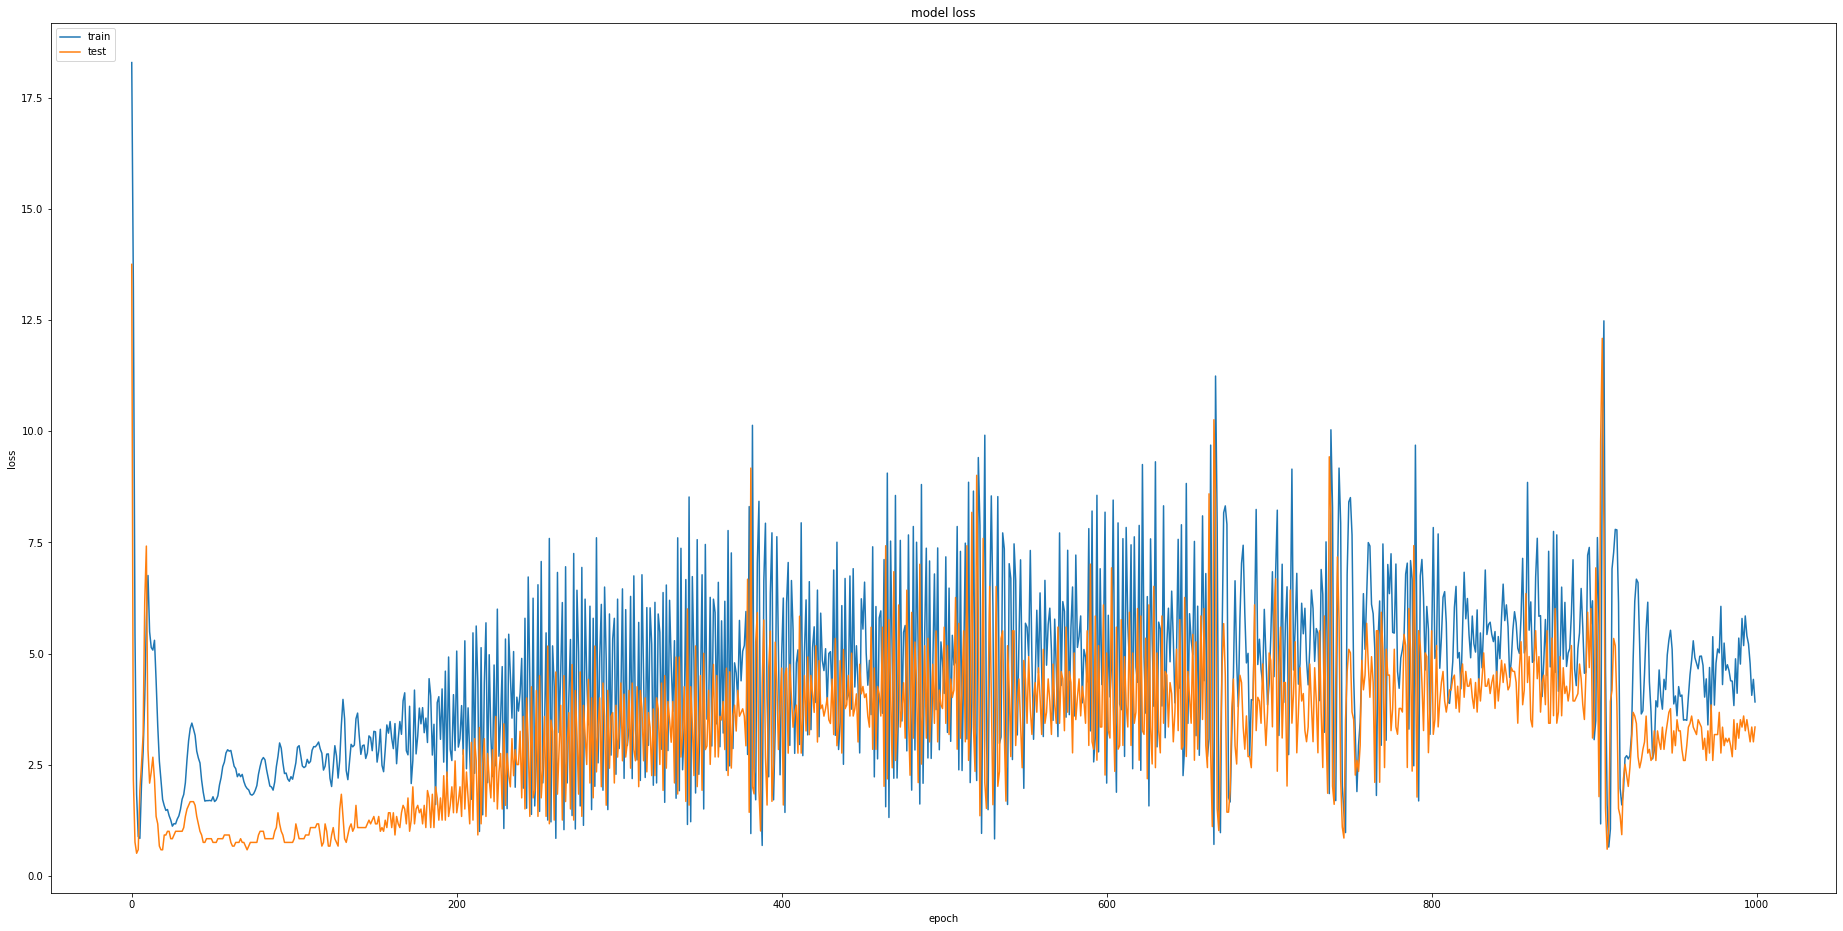

[array([[[130., 131., 131., 132., 132., 133., 134., 134., 134., 136.],
        [  1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,   2.]]])]
day: 5, CC: 146.0, CD: 2.0, val_pre_norm: [[136.]
 [  2.]]

MSE-------------7.0710678118654755

day: 6, CC: 155.0, CD: 2.0, val_pre_norm: [[137.]
 [  2.]]

MSE-------------12.727922061357855

day: 7, CC: 162.0, CD: 2.0, val_pre_norm: [[137.]
 [  2.]]

MSE-------------17.67766952966369

day: 8, CC: 167.0, CD: 2.0, val_pre_norm: [[137.]
 [  2.]]

MSE-------------21.213203435596427

day: 9, CC: 172.0, CD: 2.0, val_pre_norm: [[138.]
 [  2.]]

MSE-------------24.041630560342615

total mse: 16.54629867976521



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in double_scalars


Training rural bidirectional Model
Time in training model in 127.6674 seconds


<Figure size 432x288 with 0 Axes>

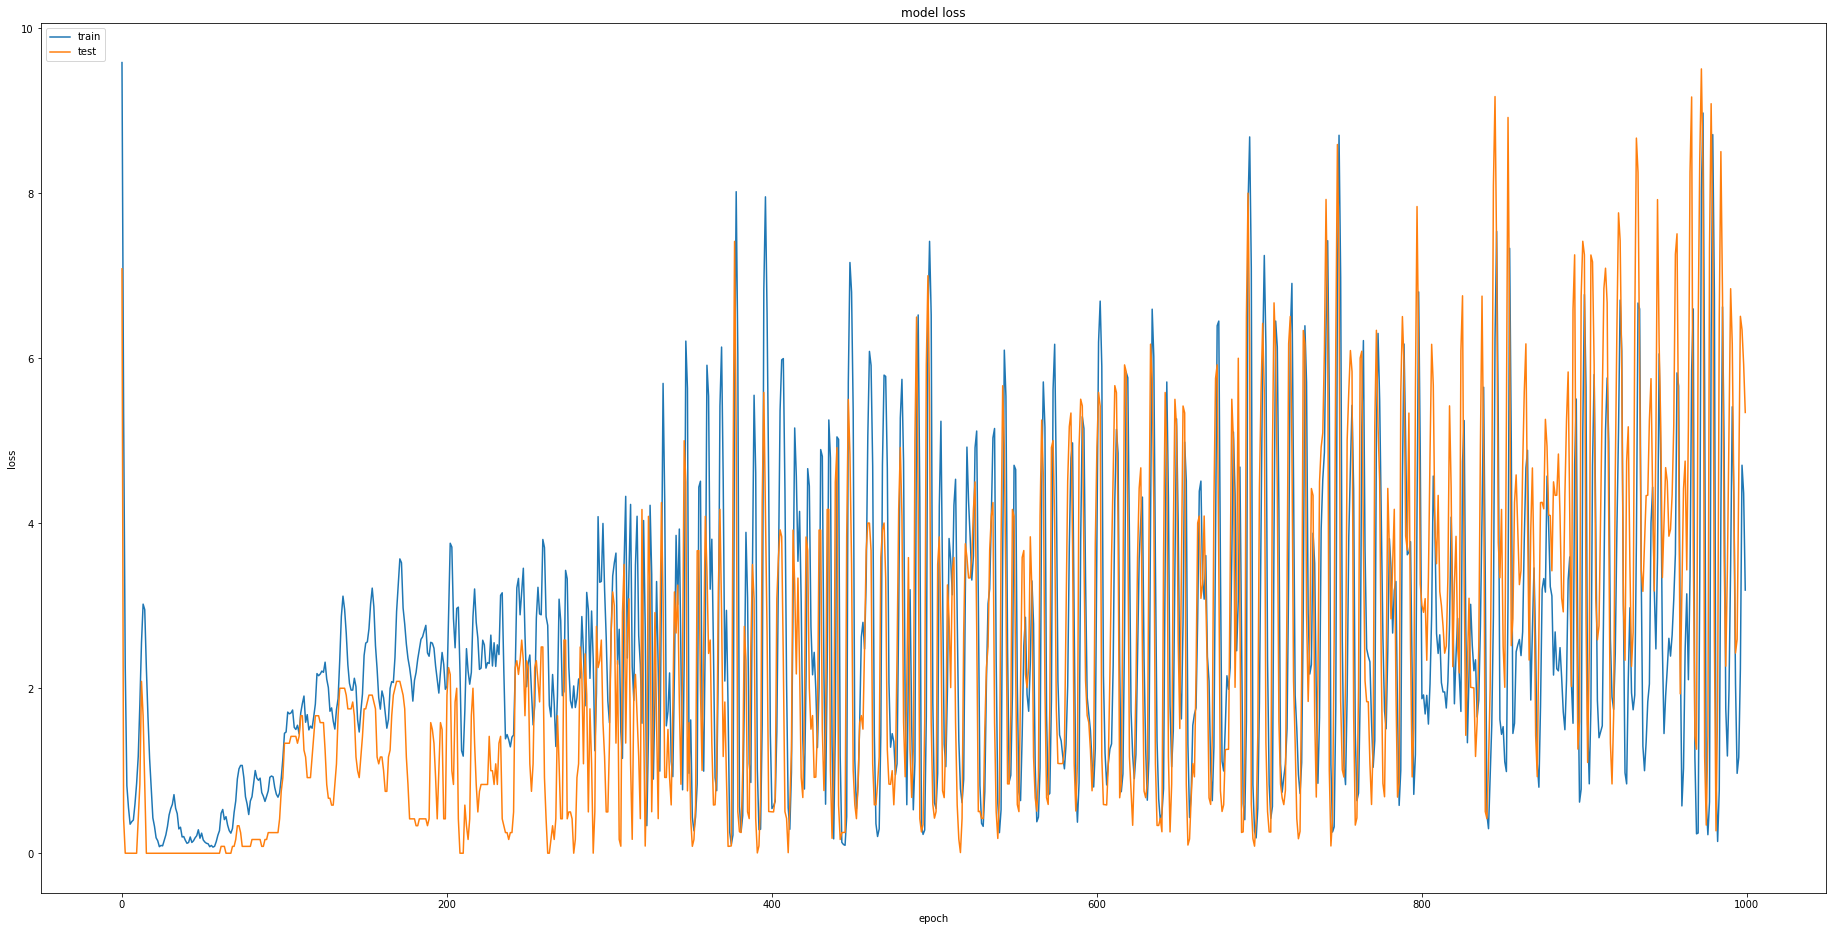

[array([[[130., 131., 131., 132., 132., 133., 134., 134., 134., 136.],
        [  1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,   2.]]])]
day: 5, CC: 139.0, CD: 2.0, val_pre_norm: [[136.]
 [  2.]]

MSE-------------2.1213203435596424

day: 6, CC: 143.0, CD: 2.0, val_pre_norm: [[137.]
 [  2.]]

MSE-------------4.242640687119285

day: 7, CC: 147.0, CD: 2.0, val_pre_norm: [[137.]
 [  2.]]

MSE-------------7.0710678118654755

day: 8, CC: 151.0, CD: 2.0, val_pre_norm: [[137.]
 [  2.]]

MSE-------------9.899494936611665

day: 9, CC: 155.0, CD: 2.0, val_pre_norm: [[138.]
 [  2.]]

MSE-------------12.020815280171307

total mse: 7.0710678118654755



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in double_scalars


Training rural stacked Model
Time in training model in 88.2152 seconds


<Figure size 432x288 with 0 Axes>

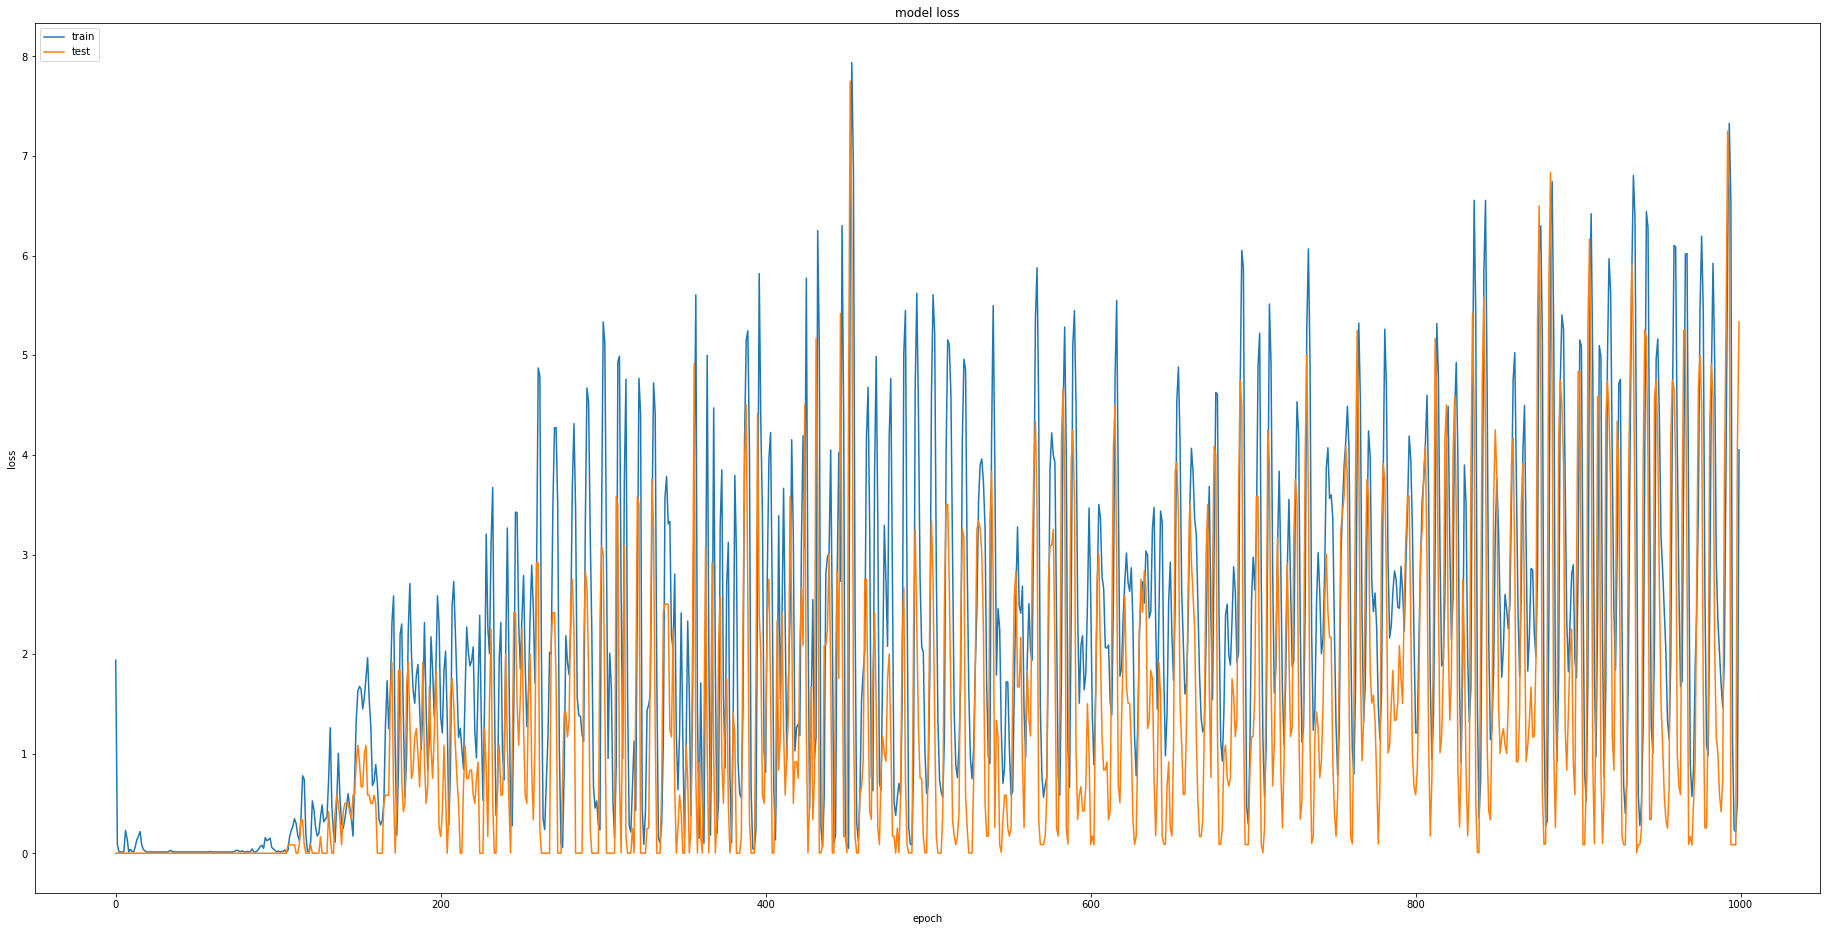

[array([[[130., 131., 131., 132., 132., 133., 134., 134., 134., 136.],
        [  1.,   1.,   1.,   1.,   2.,   2.,   2.,   2.,   2.,   2.]]])]
day: 5, CC: 137.0, CD: 2.0, val_pre_norm: [[136.]
 [  2.]]

MSE-------------0.7071067811865476

day: 6, CC: 139.0, CD: 2.0, val_pre_norm: [[137.]
 [  2.]]

MSE-------------1.4142135623730951

day: 7, CC: 141.0, CD: 2.0, val_pre_norm: [[137.]
 [  2.]]

MSE-------------2.8284271247461903

day: 8, CC: 143.0, CD: 2.0, val_pre_norm: [[137.]
 [  2.]]

MSE-------------4.242640687119285

day: 9, CC: 145.0, CD: 2.0, val_pre_norm: [[138.]
 [  2.]]

MSE-------------4.949747468305833

total mse: 2.8284271247461903



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in double_scalars


<Figure size 432x288 with 0 Axes>

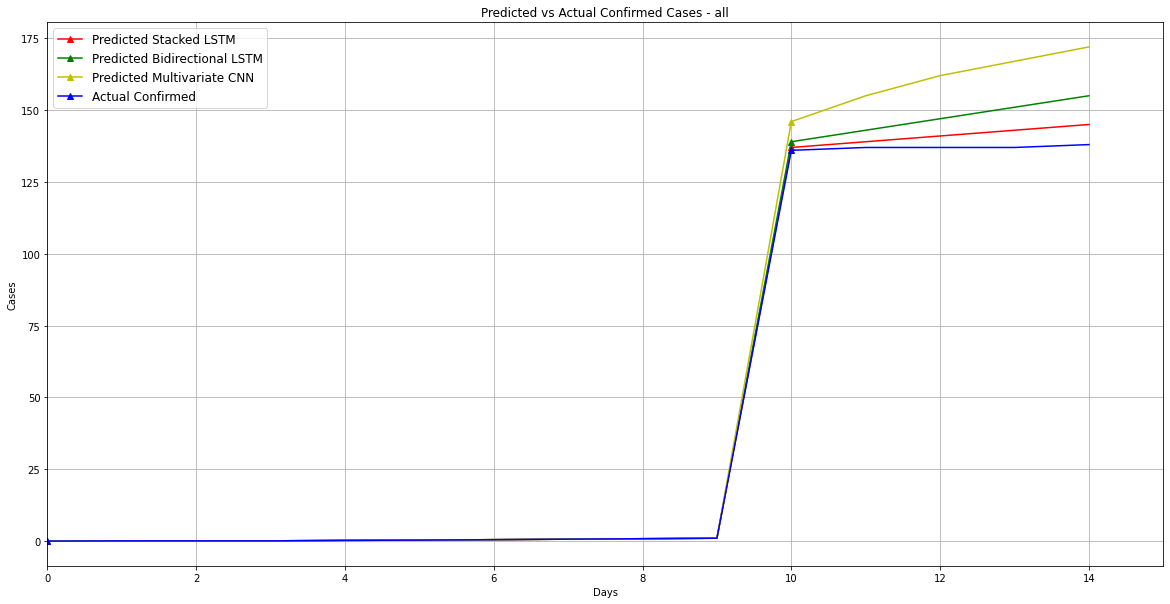

<Figure size 432x288 with 0 Axes>

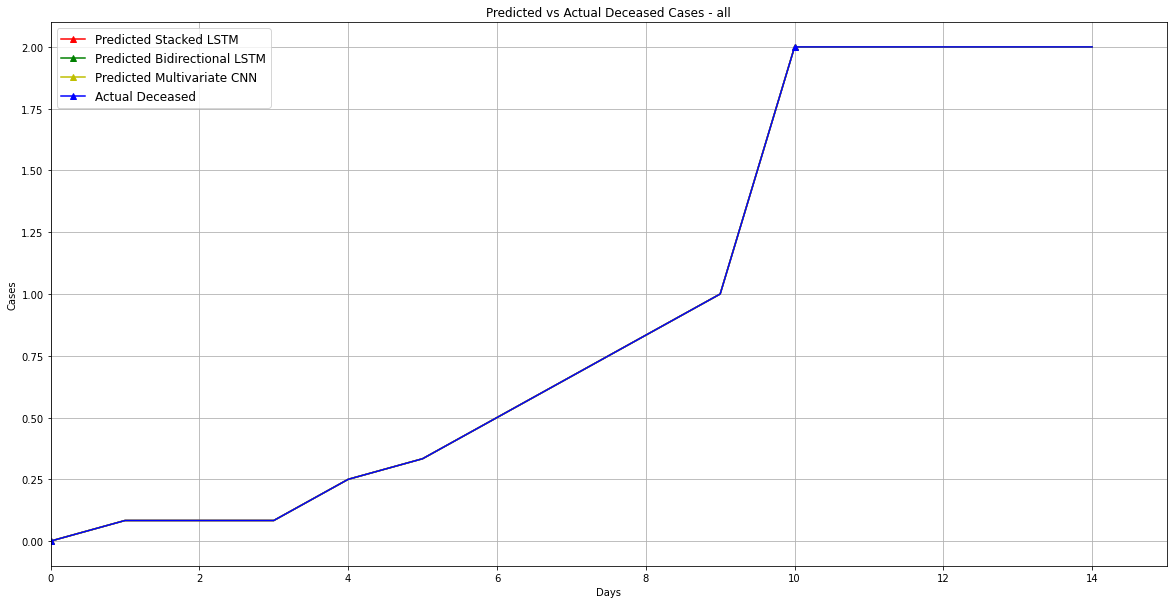

<Figure size 432x288 with 0 Axes>

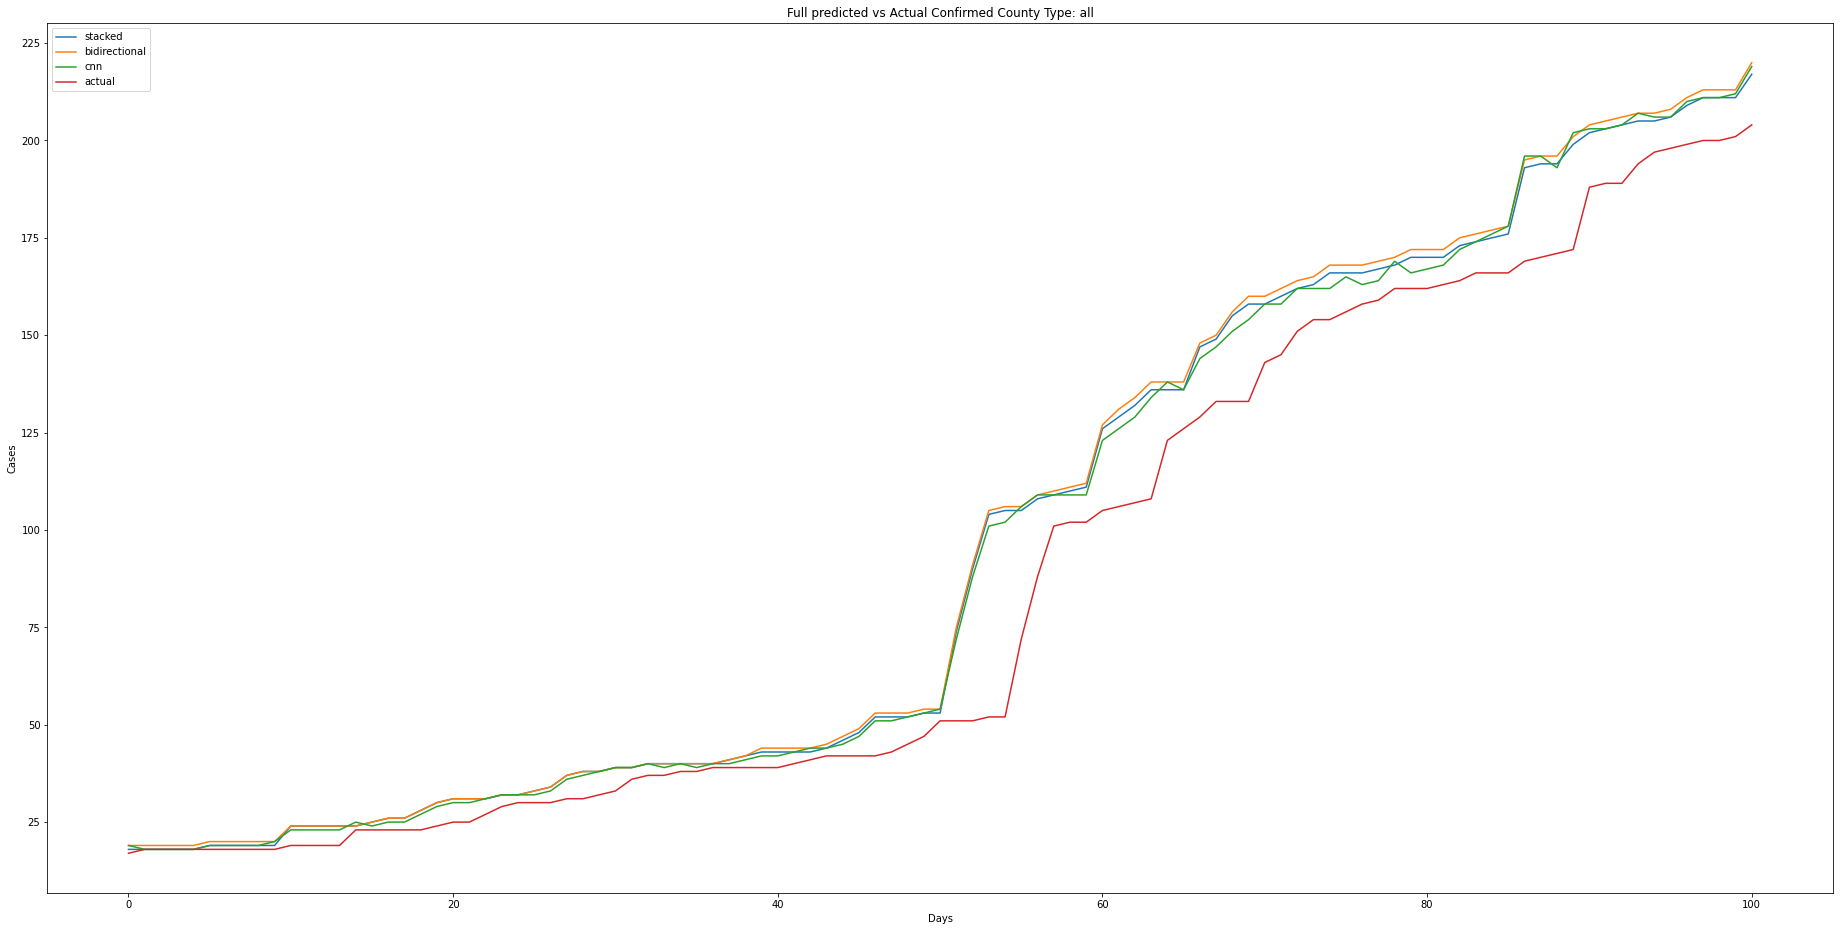

<Figure size 432x288 with 0 Axes>

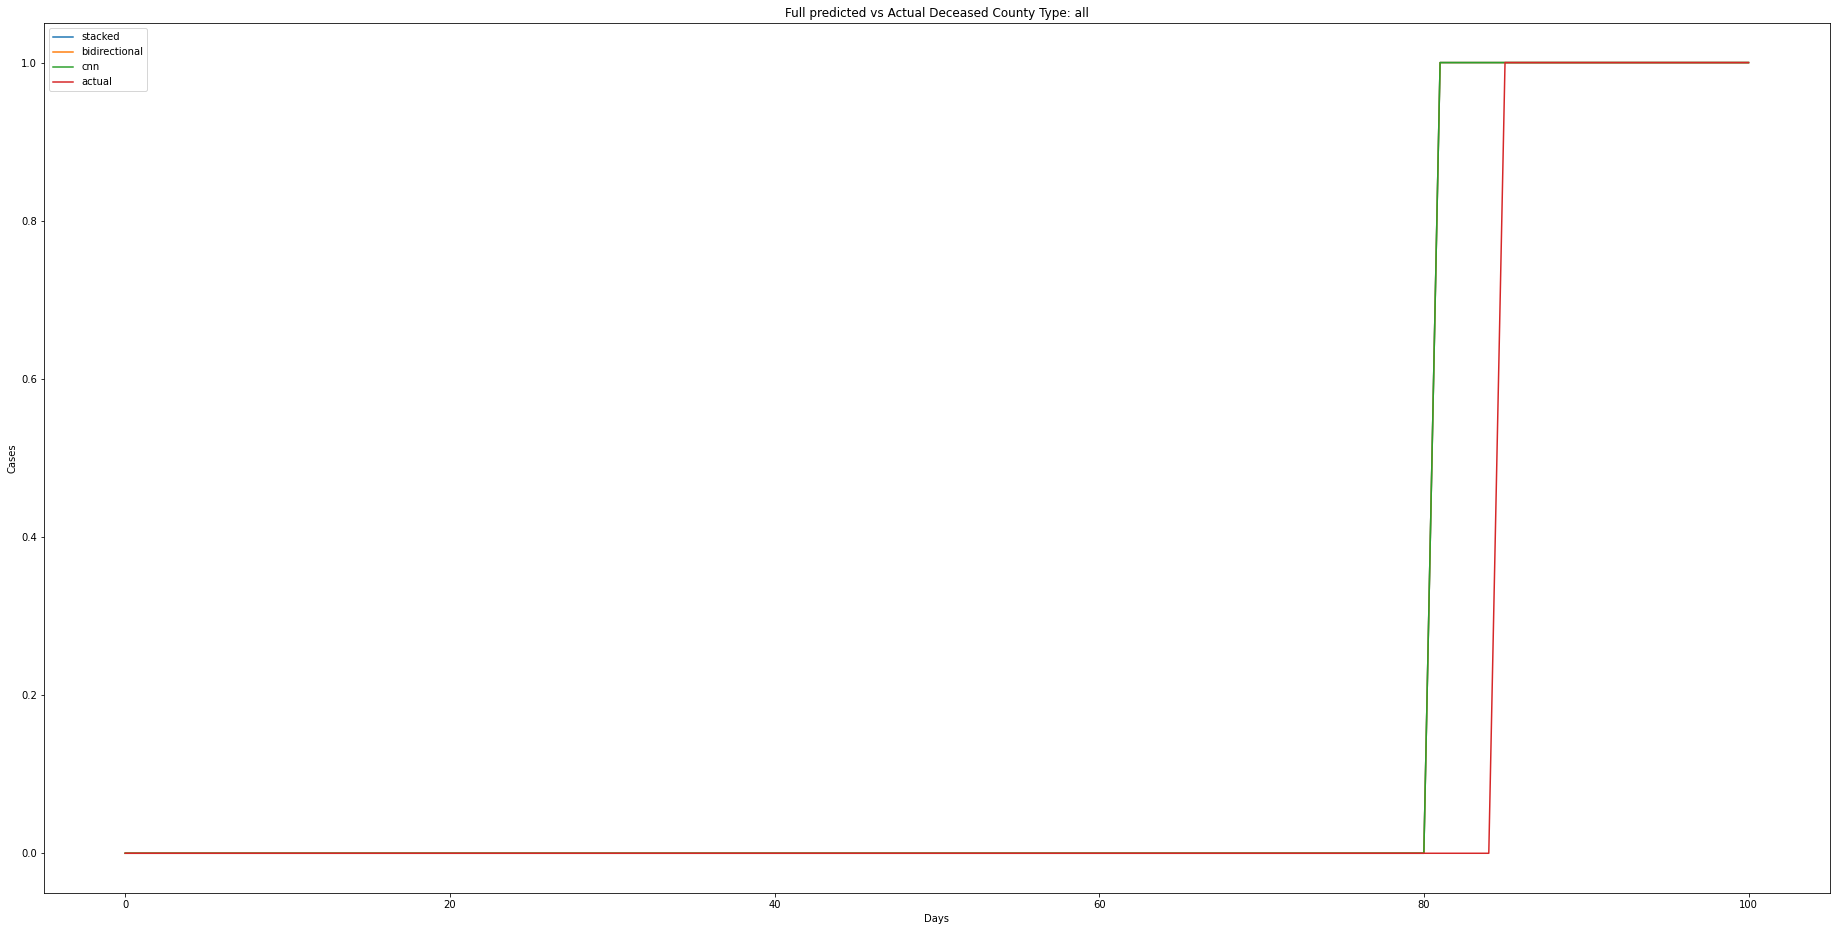

<Figure size 432x288 with 0 Axes>

In [ ]:
if cdl.county_type == 'rural' or cdl.county_type == 'all':
    print('Training rural MultiVariateCNN Model')
    cnn_rural_history = train_model(rural_cnn_model, rural_X_train, rural_X_val, rural_y_train, rural_y_val, rural_pop_train,
                          rural_pop_val, rural_cnn_cp_name, ci.epochs, ci.batch_size, rural_cnn_log_dir, verbose_level)
    plot_model_loss(cnn_rural_history, rural_cnn_plot_loss_location)
    predd_conf_cnn, actt_conf, predd_dec_cnn, actt_dec, orig_input = \
        predict_n_days(model=rural_cnn_model, mdl=mdl, weight_file_path=rural_cnn_cp_name, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=rural_X_val_pre,
                    y_val_pre=rural_y_val_pre, population_val=rural_pop_val, verbose_flag=verbose_level, data_file=rural_cnn_data_location, batch_size=ci.batch_size)
    full_predd_conf_cnn, full_actt_conf, full_predd_dec_cnn, full_actt_dec = \
        calc_results(model=rural_cnn_model, weight_file_path=rural_cnn_cp_name, index=ci.index, X_test_pre=rural_X_test_pre,
                  pop_test=rural_pop_test, y_test_pre=rural_y_test_pre, data_file=rural_cnn_data_location, verbose_flag=verbose_level)

    print('Training rural bidirectional Model')
    bi_rural_history = train_model(rural_bidirectional_model, rural_X_train, rural_X_val, rural_y_train, rural_y_val, rural_pop_train,
                                              rural_pop_val, rural_bi_cp_name, ci.epochs, ci.batch_size, rural_bi_log_dir, verbose_level)
    plot_model_loss(bi_rural_history, rural_bi_plot_loss_location)
    predd_conf_bi, actt_conf, predd_dec_bi, actt_dec, orig_input = \
        predict_n_days(model=rural_bidirectional_model, mdl=mdl, weight_file_path=rural_bi_cp_name, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=rural_X_val_pre,
                    y_val_pre=rural_y_val_pre, population_val=rural_pop_val, verbose_flag=verbose_level, data_file=rural_bi_data_location, batch_size=ci.batch_size)
    full_predd_conf_bi, full_actt_conf, full_predd_dec_bi, full_actt_dec = \
        calc_results(model=rural_bidirectional_model, weight_file_path=rural_bi_cp_name, index=ci.index, X_test_pre=rural_X_test_pre,
                  pop_test=rural_pop_test, y_test_pre=rural_y_test_pre, data_file=rural_bi_data_location, verbose_flag=verbose_level)

    print('Training rural stacked Model')
    rural_history = train_model(rural_stacked_model, rural_X_train, rural_X_val, rural_y_train, rural_y_val, rural_pop_train,
                                              rural_pop_val, rural_stacked_cp_name, ci.epochs, ci.batch_size, rural_stacked_log_dir, verbose_level)
    plot_model_loss(rural_history, rural_stacked_plot_loss_location)
    predd_conf_stacked, actt_conf, predd_dec_stacked, actt_dec, orig_input = \
        predict_n_days(model=rural_stacked_model, mdl=mdl, weight_file_path=rural_stacked_cp_name, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=rural_X_val_pre,
                    y_val_pre=rural_y_val_pre, population_val=rural_pop_val, verbose_flag=verbose_level, data_file=rural_stacked_data_location, batch_size=ci.batch_size)
    full_predd_conf_stacked, full_actt_conf, full_predd_dec_stacked, full_actt_dec= \
        calc_results(model=rural_stacked_model, weight_file_path=rural_stacked_cp_name, index=ci.index, X_test_pre=rural_X_test_pre,
                  pop_test=rural_pop_test, y_test_pre=rural_y_test_pre, data_file=rural_stacked_data_location, verbose_flag=verbose_level)

    # Plot out the difference between actual and predicted for 5 day plot
    plot_pred_vs_act(orig_input, predd_conf_stacked, predd_conf_bi, predd_conf_cnn, actt_conf, rural_plot_5_day_conf_compare_location, county_type, isConfirmed=True)
    plot_pred_vs_act(orig_input, predd_dec_stacked, predd_dec_bi, predd_dec_cnn, actt_dec, rural_plot_5_day_desc_compare_location, county_type, isConfirmed=False)

    # Plot out the difference between actual and predicted for test data
    plot_pred_vs_act_full_test(full_predd_conf_stacked, full_predd_conf_bi, full_predd_conf_cnn, full_actt_conf, rural_plot_full_conf_compare_location, county_type, isConfirmed=True)
    plot_pred_vs_act_full_test(full_predd_dec_stacked, full_predd_dec_bi, full_predd_dec_cnn, full_actt_dec, rural_plot_full_desc_compare_location, county_type, isConfirmed=False)


###Training Suburban

Training suburban MultiVariateCNN Model
Time in training model in 68.1064 seconds


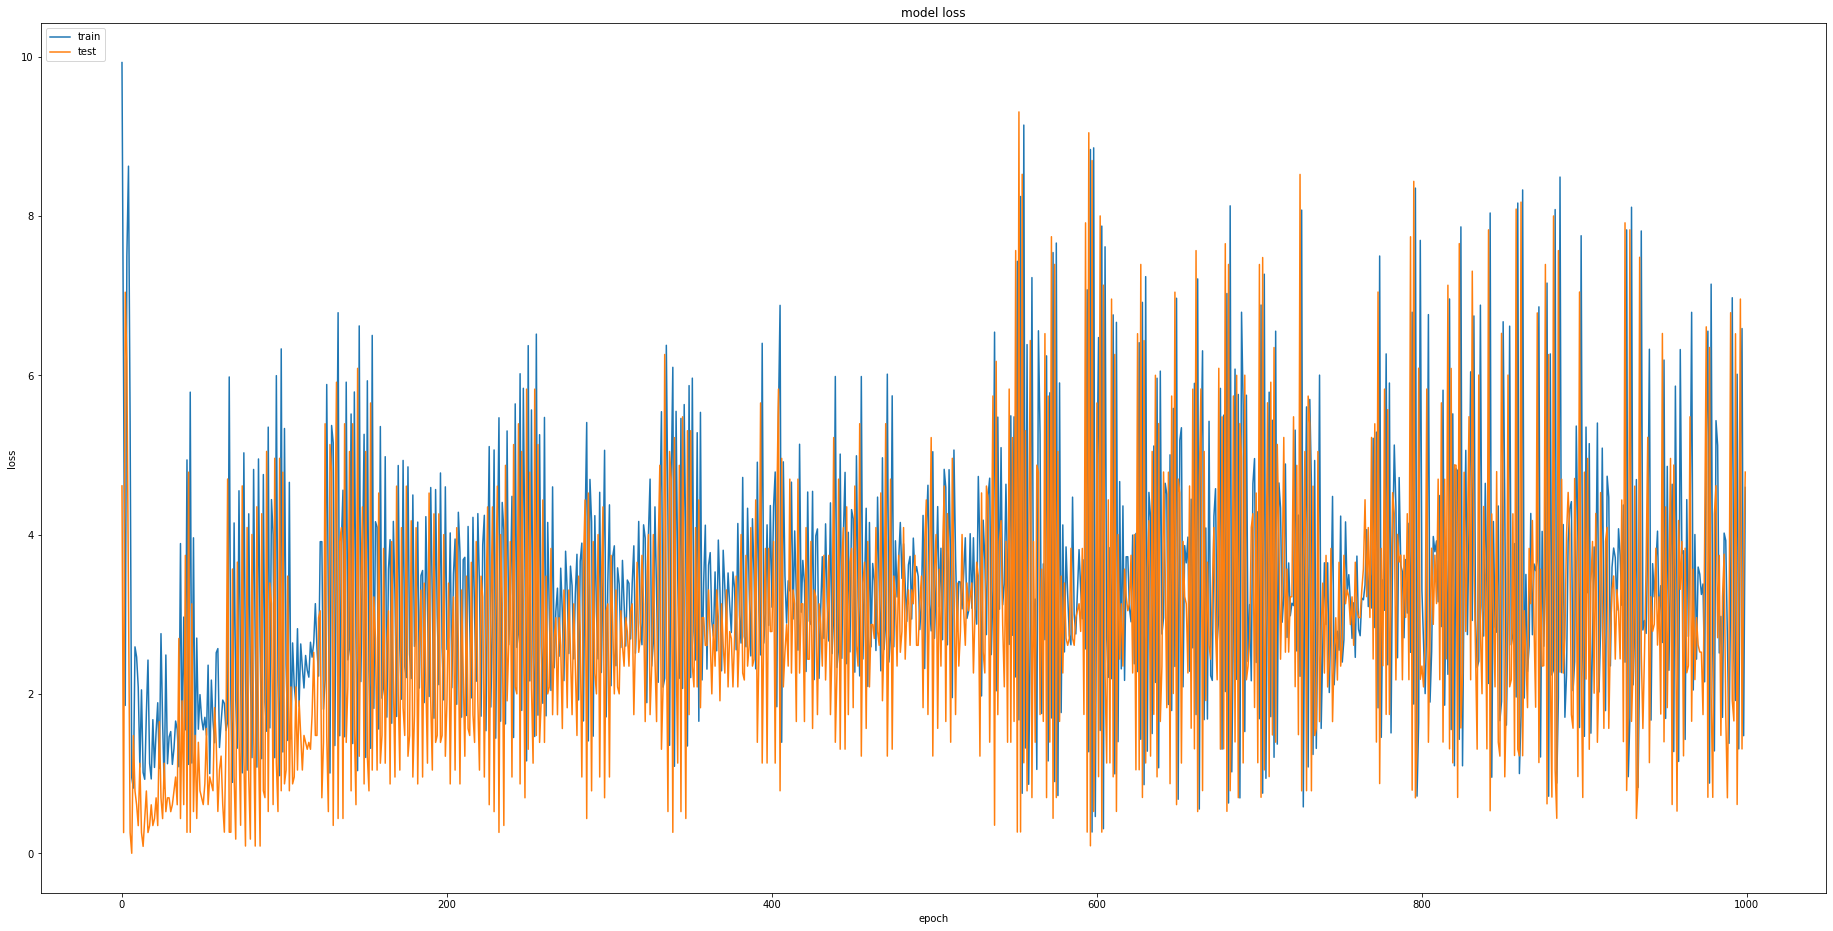

[array([[[688., 693., 698., 716., 745., 748., 756., 760., 763., 770.],
        [  4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.]]])]
day: 5, CC: 803.0, CD: 4.0, val_pre_norm: [[777.]
 [  4.]]

MSE-------------18.384776310850235

day: 6, CC: 821.0, CD: 4.0, val_pre_norm: [[783.]
 [  4.]]

MSE-------------26.870057685088806

day: 7, CC: 843.0, CD: 4.0, val_pre_norm: [[785.]
 [  4.]]

MSE-------------41.012193308819754

day: 8, CC: 863.0, CD: 4.0, val_pre_norm: [[795.]
 [  4.]]

MSE-------------48.08326112068523

day: 9, CC: 884.0, CD: 4.0, val_pre_norm: [[803.]
 [  5.]]

MSE-------------57.28001396647874

total mse: 38.32606047838455

Training suburban bidirectional Model
Time in training model in 185.2170 seconds


<Figure size 432x288 with 0 Axes>

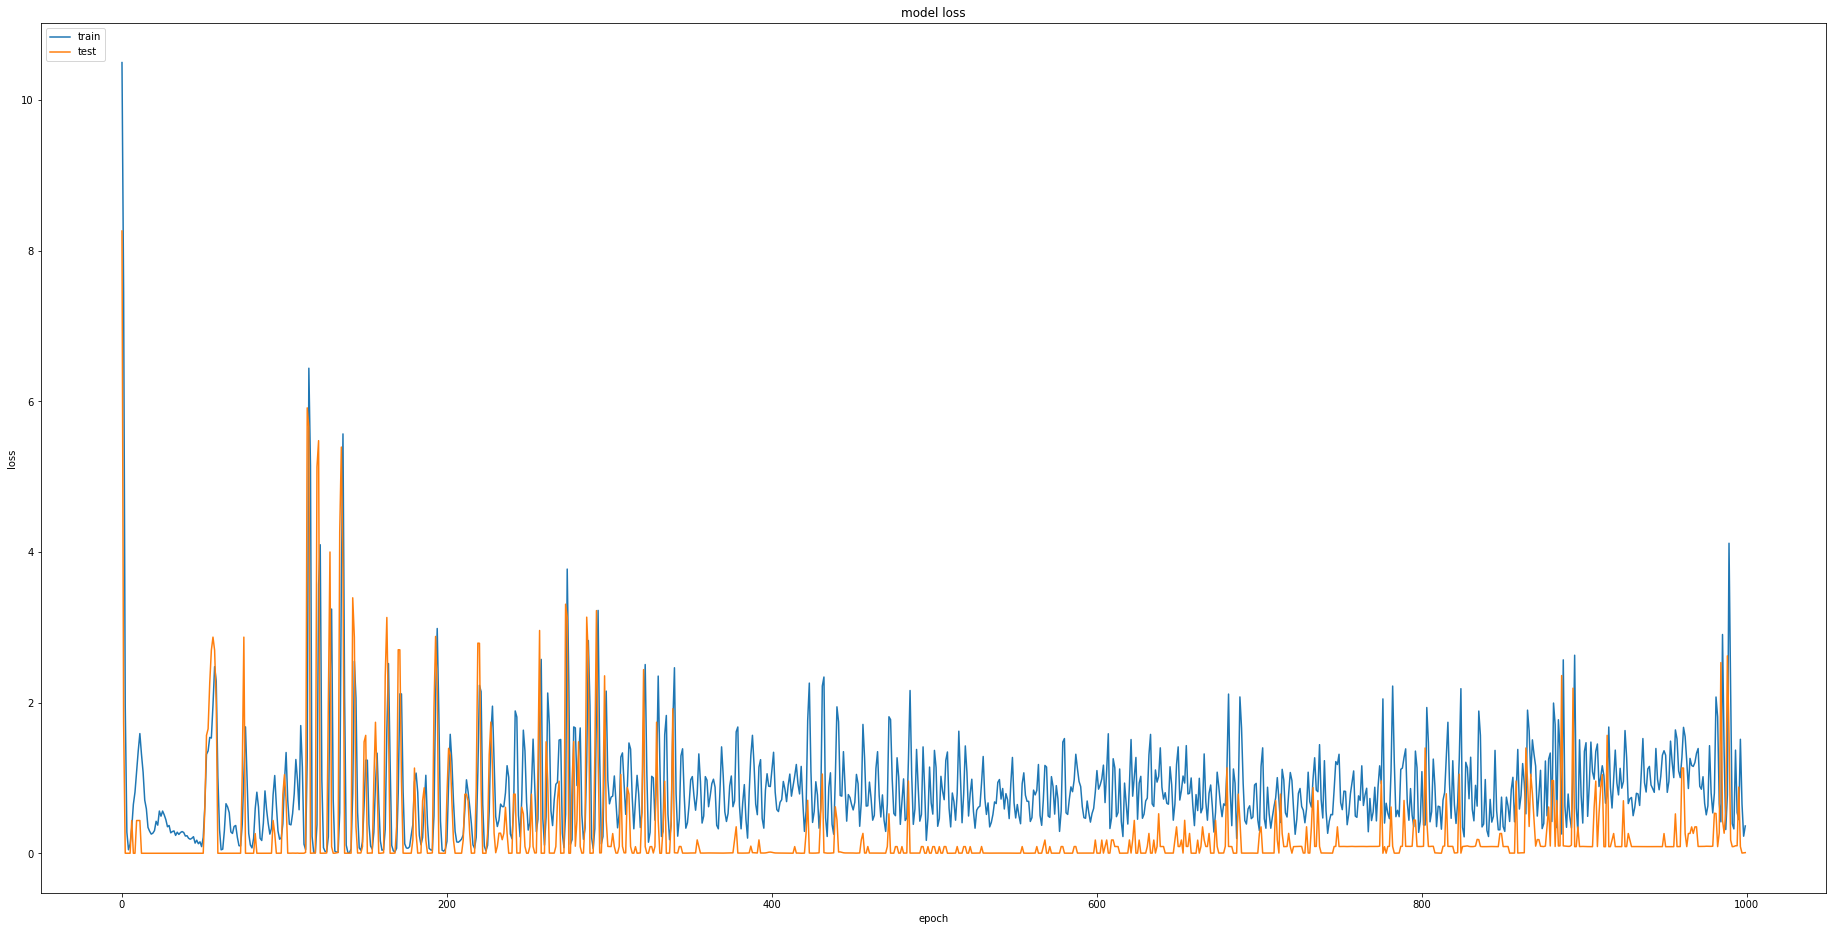

[array([[[688., 693., 698., 716., 745., 748., 756., 760., 763., 770.],
        [  4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.]]])]
day: 5, CC: 782.0, CD: 4.0, val_pre_norm: [[777.]
 [  4.]]

MSE-------------3.5355339059327378

day: 6, CC: 795.0, CD: 4.0, val_pre_norm: [[783.]
 [  4.]]

MSE-------------8.48528137423857

day: 7, CC: 808.0, CD: 4.0, val_pre_norm: [[785.]
 [  4.]]

MSE-------------16.263455967290593

day: 8, CC: 822.0, CD: 4.0, val_pre_norm: [[795.]
 [  4.]]

MSE-------------19.091883092036785

day: 9, CC: 836.0, CD: 4.0, val_pre_norm: [[803.]
 [  5.]]

MSE-------------23.345235059857504

total mse: 14.144277879871236

Training suburban stacked Model
Time in training model in 120.2118 seconds


<Figure size 432x288 with 0 Axes>

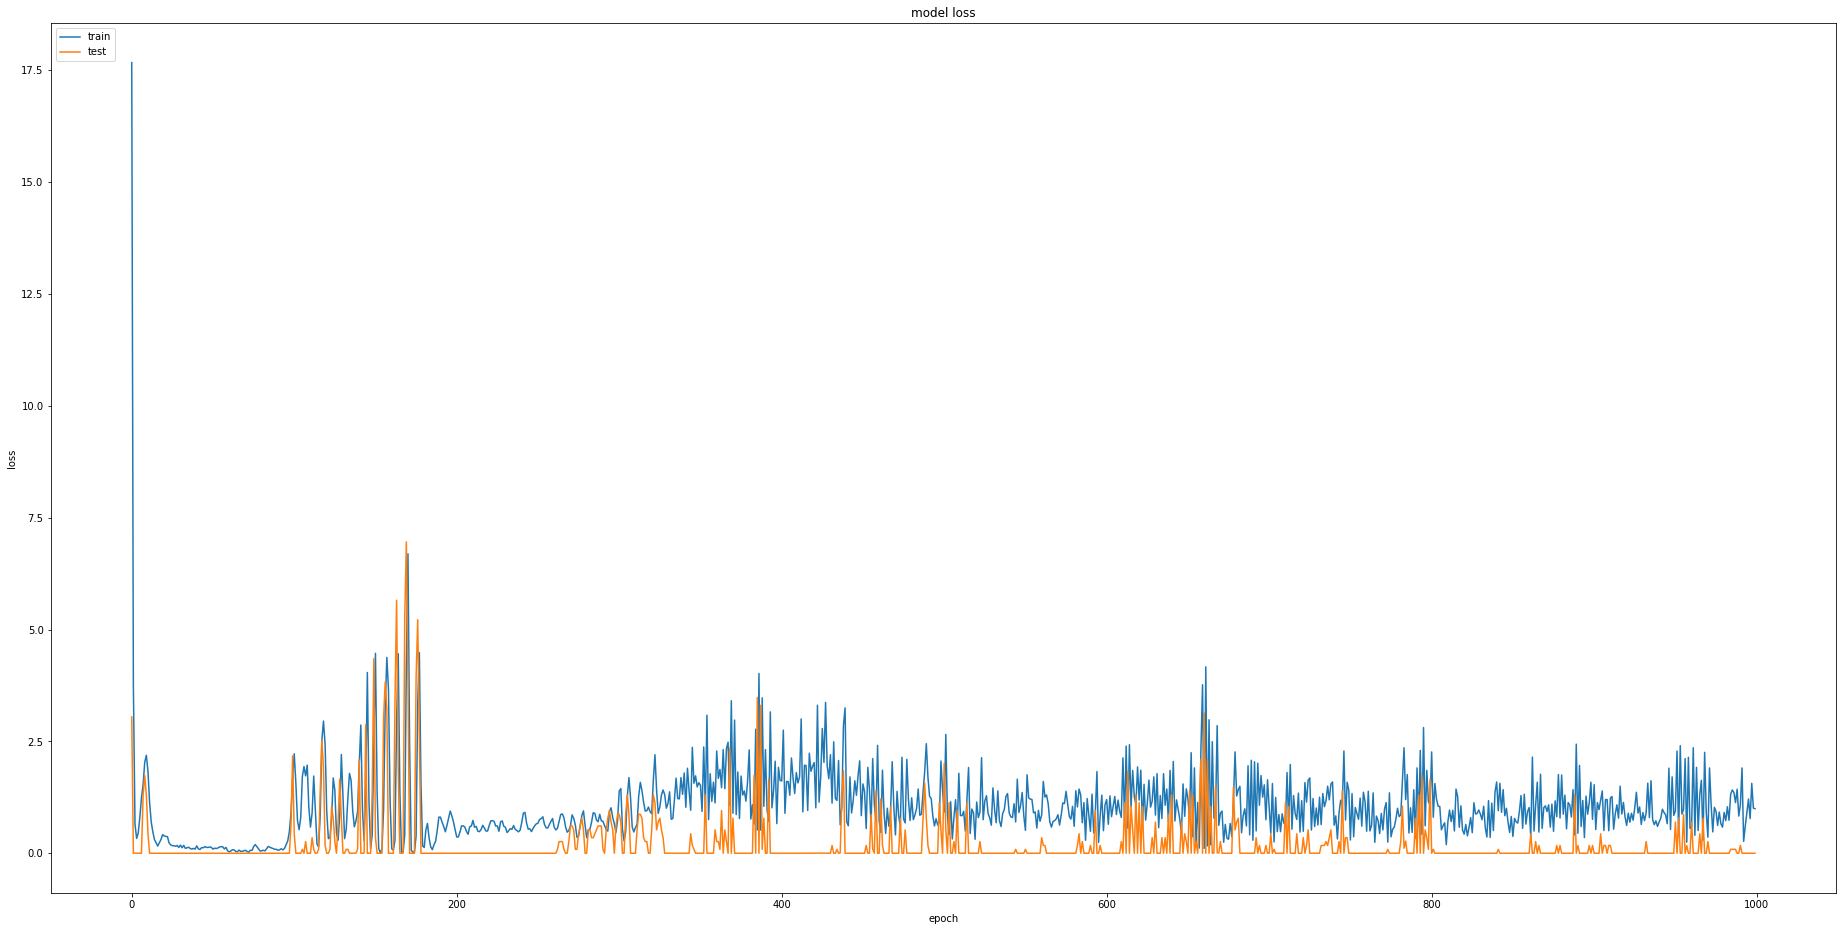

[array([[[688., 693., 698., 716., 745., 748., 756., 760., 763., 770.],
        [  4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.]]])]
day: 5, CC: 776.0, CD: 4.0, val_pre_norm: [[777.]
 [  4.]]

MSE-------------0.7071067811865476

day: 6, CC: 789.0, CD: 4.0, val_pre_norm: [[783.]
 [  4.]]

MSE-------------4.242640687119285

day: 7, CC: 802.0, CD: 4.0, val_pre_norm: [[785.]
 [  4.]]

MSE-------------12.020815280171307

day: 8, CC: 815.0, CD: 4.0, val_pre_norm: [[795.]
 [  4.]]

MSE-------------14.142135623730951

day: 9, CC: 829.0, CD: 4.0, val_pre_norm: [[803.]
 [  5.]]

MSE-------------18.398369492974098

total mse: 9.902213573036438



<Figure size 432x288 with 0 Axes>

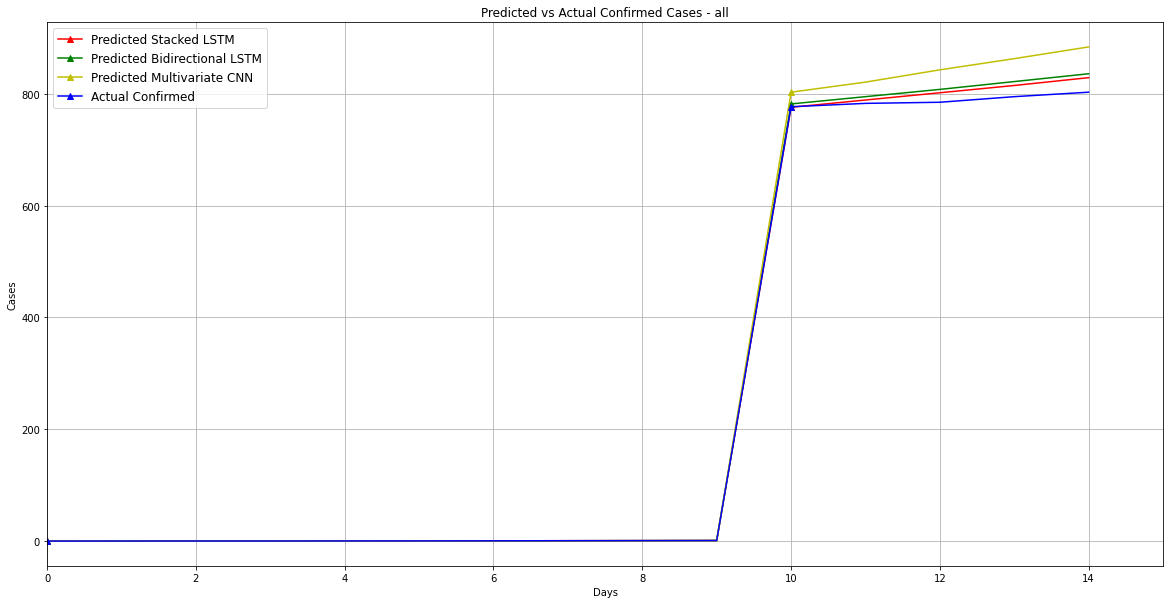

<Figure size 432x288 with 0 Axes>

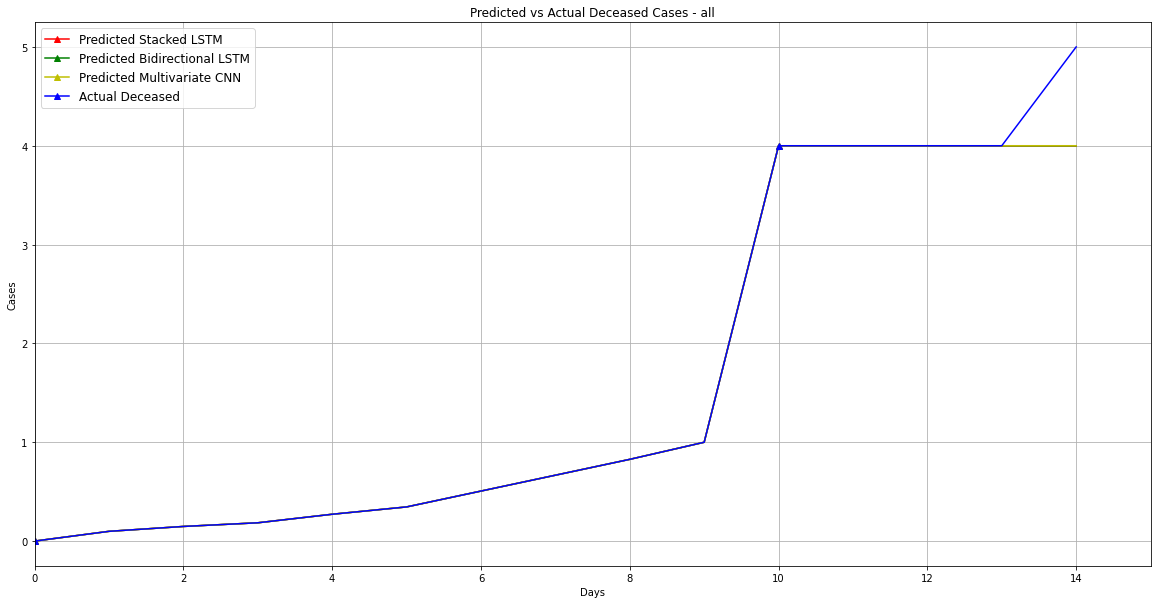

<Figure size 432x288 with 0 Axes>

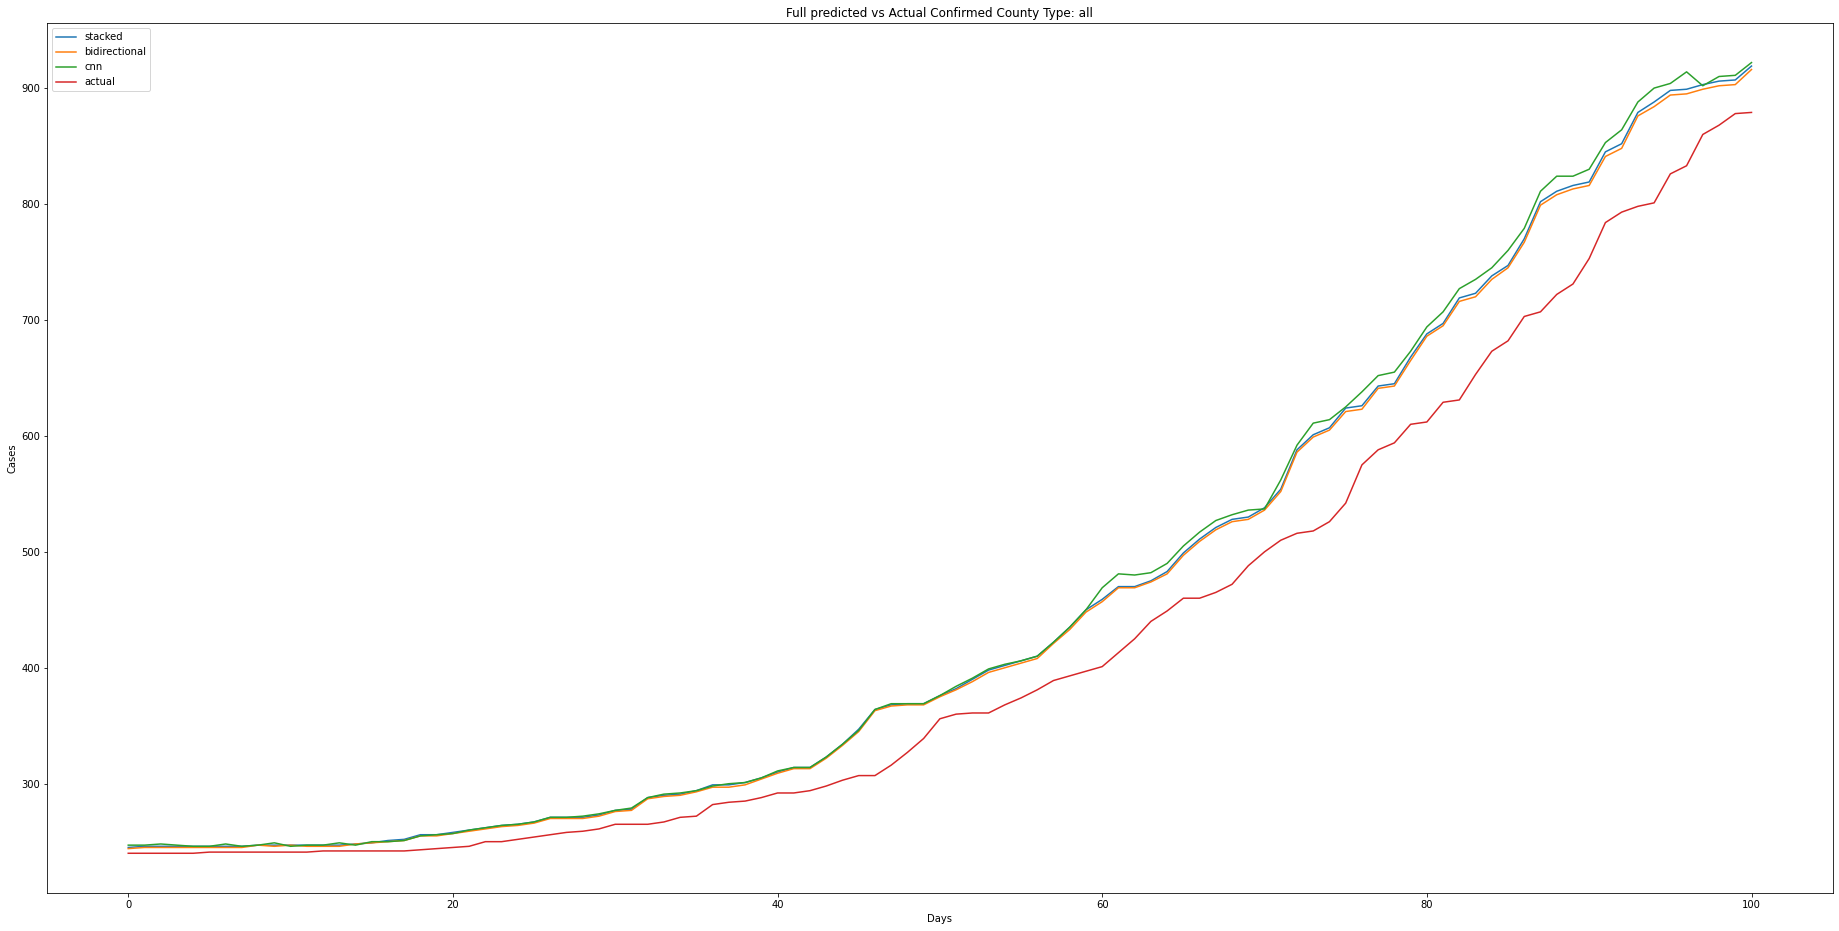

<Figure size 432x288 with 0 Axes>

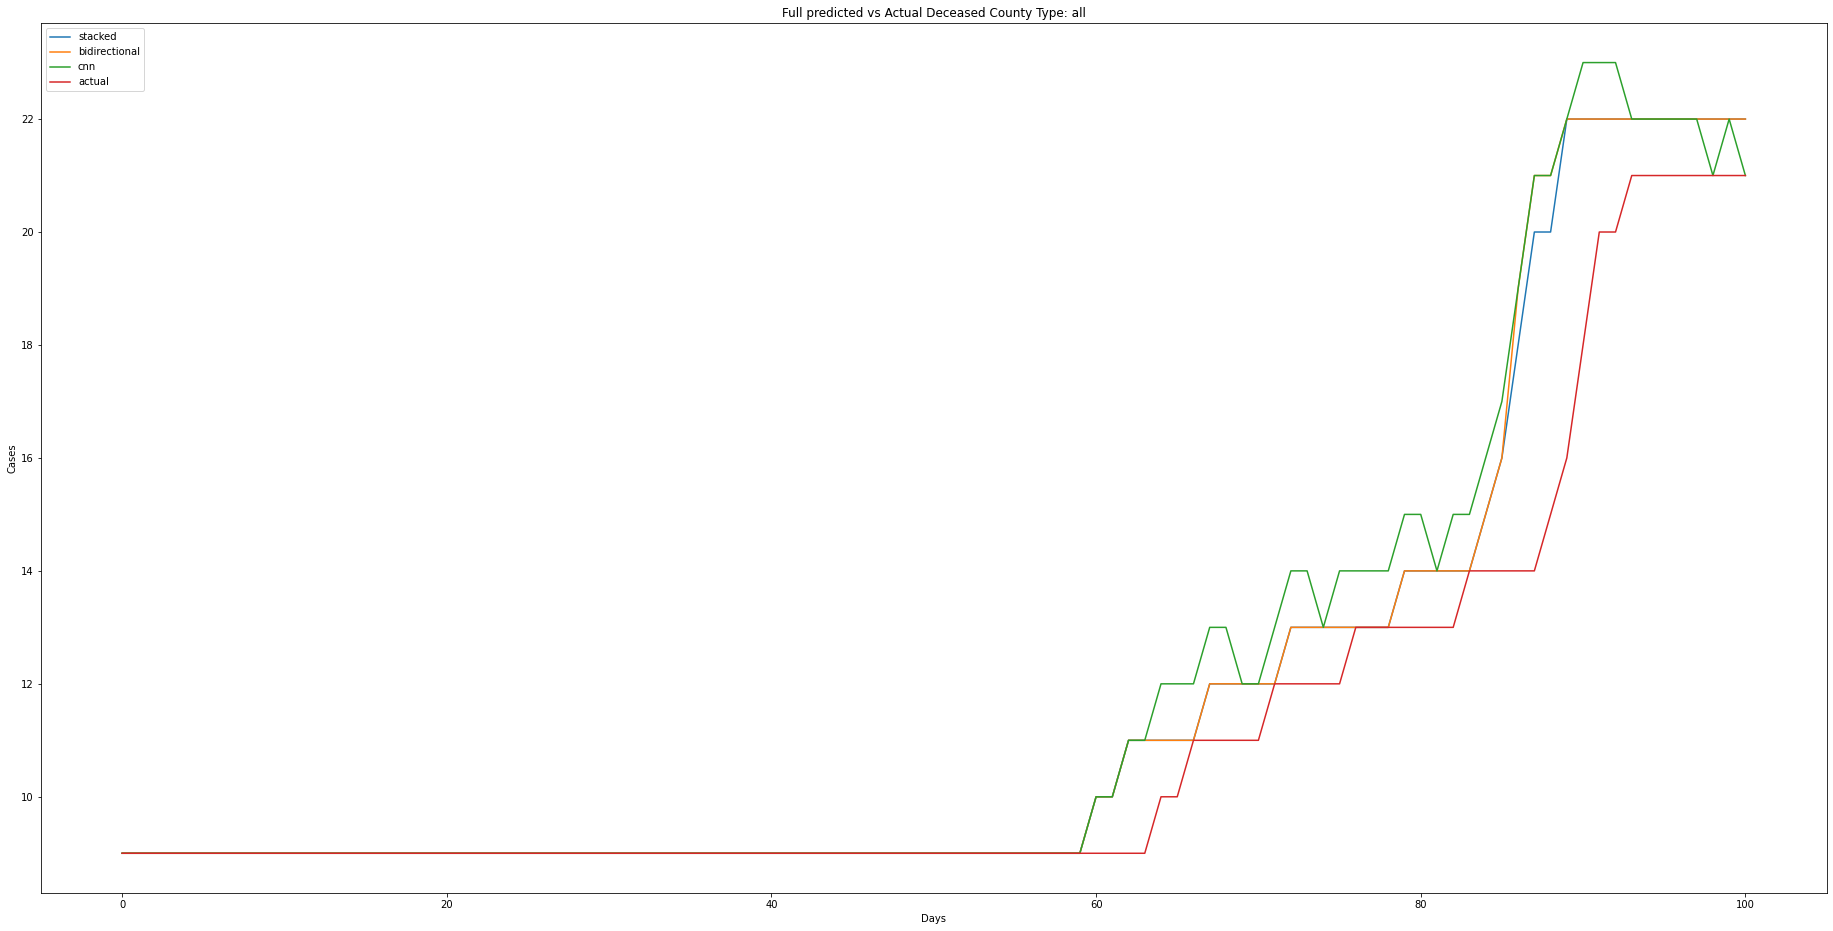

<Figure size 432x288 with 0 Axes>

In [ ]:
if cdl.county_type == 'suburban' or cdl.county_type == 'all':
    print('Training suburban MultiVariateCNN Model')
    cnn_suburban_history = train_model(suburban_cnn_model, suburban_X_train, suburban_X_val, suburban_y_train, suburban_y_val, suburban_pop_train,
                              suburban_pop_val, suburban_cnn_cp_name, ci.epochs, ci.batch_size, suburban_cnn_log_dir, verbose_level)
    plot_model_loss(cnn_suburban_history, suburban_cnn_plot_loss_location)
    predd_conf_cnn, actt_conf, predd_dec_cnn, actt_dec, orig_input = \
        predict_n_days(model=suburban_cnn_model, mdl=mdl, weight_file_path=suburban_cnn_cp_name, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=suburban_X_val_pre,
                    y_val_pre=suburban_y_val_pre, population_val=suburban_pop_val, verbose_flag=verbose_level, data_file=suburban_cnn_data_location, batch_size=ci.batch_size)
    full_predd_conf_cnn, full_actt_conf, full_predd_dec_cnn, full_actt_dec = \
        calc_results(model=suburban_cnn_model, weight_file_path=suburban_cnn_cp_name, index=ci.index, X_test_pre=suburban_X_test_pre,
                  pop_test=suburban_pop_test, y_test_pre=suburban_y_test_pre, data_file=suburban_cnn_data_location, verbose_flag=verbose_level)

    print('Training suburban bidirectional Model')
    bi_suburban_history = train_model(suburban_bidirectional_model, suburban_X_train, suburban_X_val, suburban_y_train, suburban_y_val, suburban_pop_train,
                                                    suburban_pop_val, suburban_bi_cp_name, ci.epochs, ci.batch_size, suburban_bi_log_dir, verbose_level)
    plot_model_loss(bi_suburban_history, suburban_bi_plot_loss_location)
    predd_conf_bi, actt_conf, predd_dec_bi, actt_dec, orig_input = \
        predict_n_days(model=suburban_bidirectional_model, mdl=mdl, weight_file_path=suburban_bi_cp_name, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=suburban_X_val_pre,
                    y_val_pre=suburban_y_val_pre, population_val=suburban_pop_val, verbose_flag=verbose_level, data_file=suburban_bi_data_location, batch_size=ci.batch_size)
    full_predd_conf_bi, full_actt_conf, full_predd_dec_bi, full_actt_dec = \
        calc_results(model=suburban_bidirectional_model, weight_file_path=suburban_bi_cp_name, index=ci.index, X_test_pre=suburban_X_test_pre,
                  pop_test=suburban_pop_test, y_test_pre=suburban_y_test_pre, data_file=suburban_bi_data_location, verbose_flag=verbose_level)

    print('Training suburban stacked Model')
    suburban_history = train_model(suburban_stacked_model, suburban_X_train, suburban_X_val, suburban_y_train, suburban_y_val, suburban_pop_train,
                                                    suburban_pop_val, suburban_stacked_cp_name, ci.epochs, ci.batch_size, suburban_stacked_log_dir, verbose_level)
    plot_model_loss(suburban_history, suburban_stacked_plot_loss_location)
    predd_conf_stacked, actt_conf, predd_dec_stacked, actt_dec, orig_input = \
        predict_n_days(model=suburban_stacked_model, mdl=mdl, weight_file_path=suburban_stacked_cp_name, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=suburban_X_val_pre,
                    y_val_pre=suburban_y_val_pre, population_val=suburban_pop_val, verbose_flag=verbose_level, data_file=suburban_stacked_data_location, batch_size=ci.batch_size)
    full_predd_conf_stacked, full_actt_conf, full_predd_dec_stacked, full_actt_dec = \
        calc_results(model=suburban_stacked_model, weight_file_path=suburban_stacked_cp_name, index=ci.index, X_test_pre=suburban_X_test_pre,
                  pop_test=suburban_pop_test, y_test_pre=suburban_y_test_pre, data_file=suburban_stacked_data_location, verbose_flag=verbose_level)

    # Plot out the difference between actual and predicted for 5 day plot
    plot_pred_vs_act(orig_input, predd_conf_stacked, predd_conf_bi, predd_conf_cnn, actt_conf, suburban_plot_5_day_conf_compare_location, county_type, isConfirmed=True)
    plot_pred_vs_act(orig_input, predd_dec_stacked, predd_dec_bi, predd_dec_cnn, actt_dec, suburban_plot_5_day_desc_compare_location, county_type, isConfirmed=False)

    # Plot out the difference between actual and predicted for test data
    plot_pred_vs_act_full_test(full_predd_conf_stacked, full_predd_conf_bi, full_predd_conf_cnn, full_actt_conf, suburban_plot_full_conf_compare_location, county_type, isConfirmed=True)
    plot_pred_vs_act_full_test(full_predd_dec_stacked, full_predd_dec_bi, full_predd_dec_cnn, full_actt_dec, suburban_plot_full_desc_compare_location, county_type, isConfirmed=False)


###Training Urban

Training urban MultiVariateCNN Model
Time in training model in 51.9735 seconds


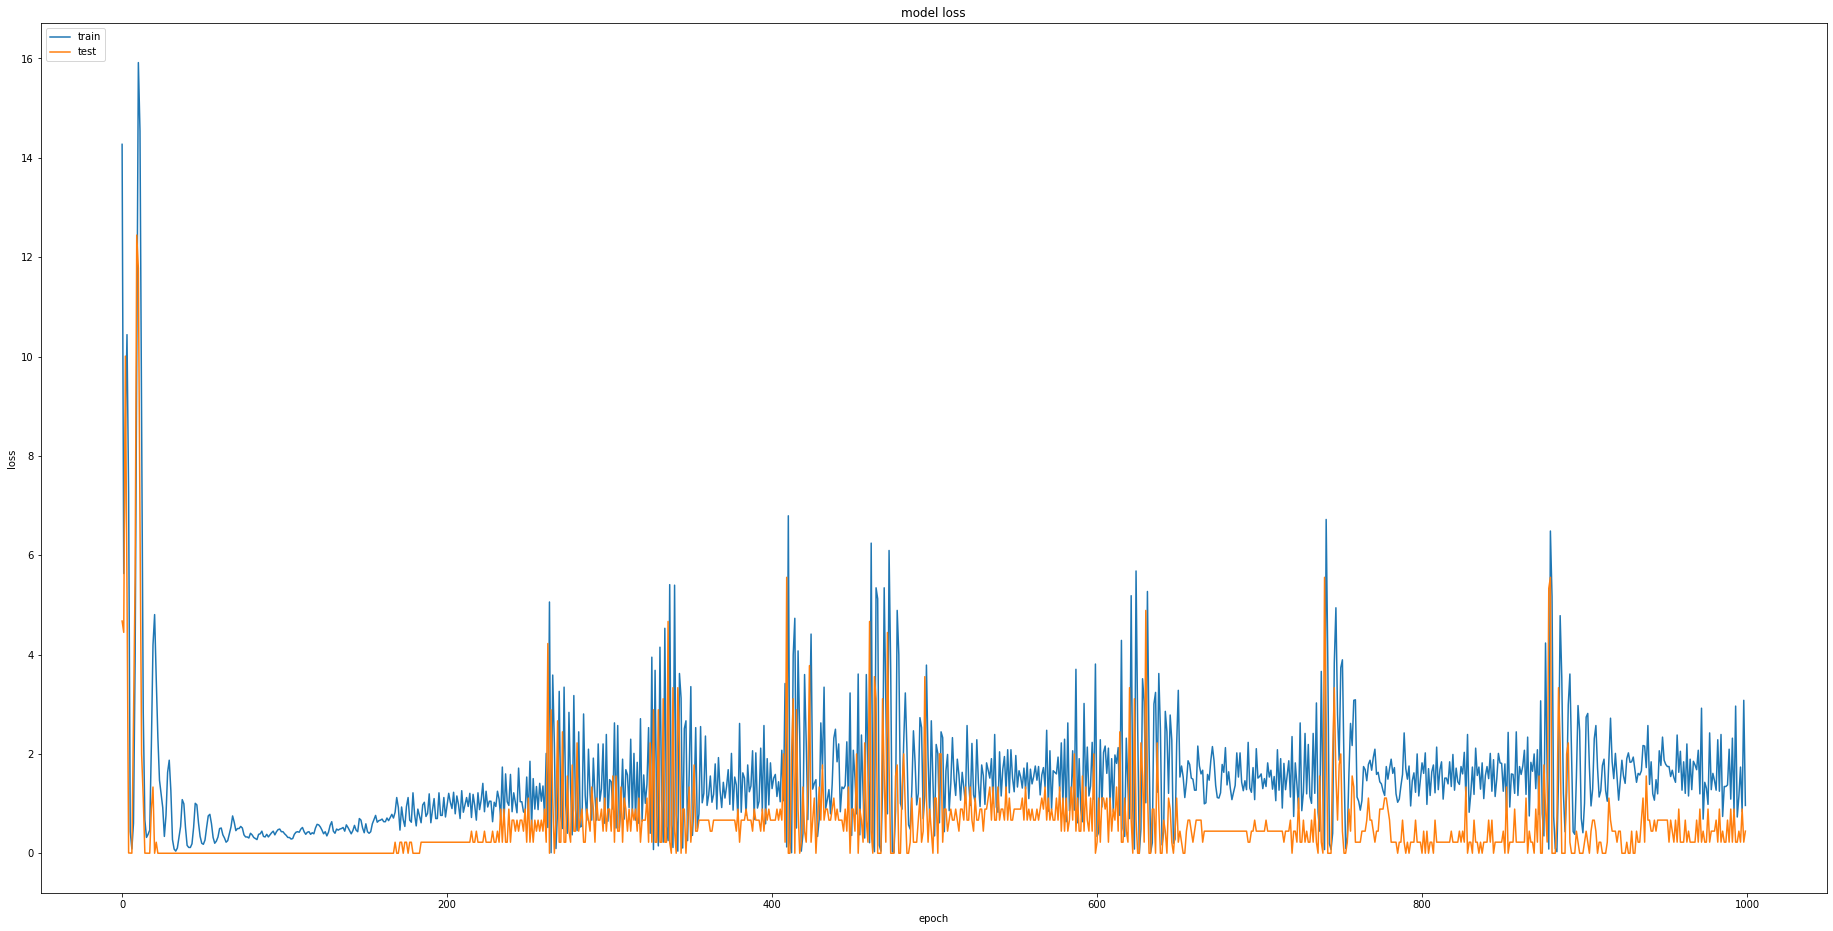

[array([[[16092., 16275., 16373., 16600., 16779., 16905., 17047., 17134.,
         17218., 17374.],
        [  197.,   198.,   200.,   205.,   206.,   205.,   207.,   207.,
           209.,   210.]]])]
day: 5, CC: 17576.0, CD: 212.0, val_pre_norm: [[17533.]
 [  211.]]

MSE-------------30.4138126514911

day: 6, CC: 18011.0, CD: 215.0, val_pre_norm: [[17633.]
 [  211.]]

MSE-------------267.30132809247317

day: 7, CC: 18604.0, CD: 218.0, val_pre_norm: [[17727.]
 [  213.]]

MSE-------------620.1427255076044

day: 8, CC: 19634.0, CD: 218.0, val_pre_norm: [[17795.]
 [  214.]]

MSE-------------1300.372446647498

day: 9, CC: 21296.0, CD: 218.0, val_pre_norm: [[17868.]
 [  214.]]

MSE-------------2423.9636960977778

total mse: 928.438801799369

Training urban bidirectional Model
Time in training model in 122.1698 seconds


<Figure size 432x288 with 0 Axes>

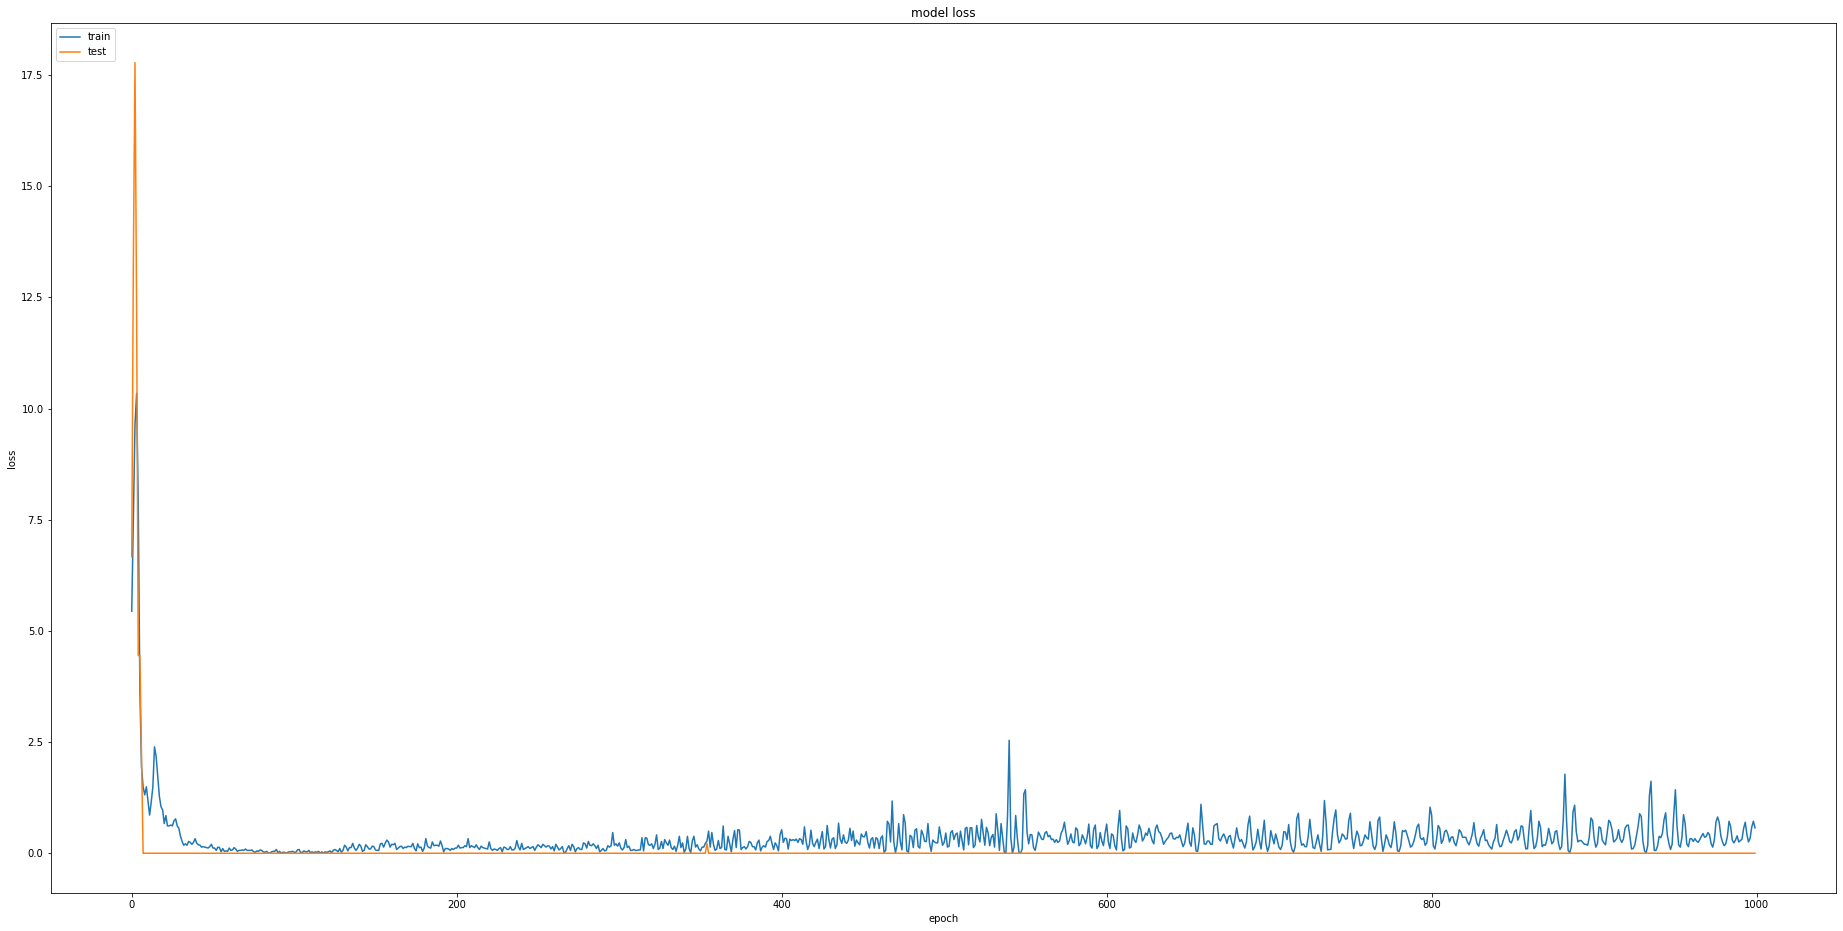

[array([[[16092., 16275., 16373., 16600., 16779., 16905., 17047., 17134.,
         17218., 17374.],
        [  197.,   198.,   200.,   205.,   206.,   205.,   207.,   207.,
           209.,   210.]]])]
day: 5, CC: 17598.0, CD: 211.0, val_pre_norm: [[17533.]
 [  211.]]

MSE-------------45.96194077712559

day: 6, CC: 17858.0, CD: 212.0, val_pre_norm: [[17633.]
 [  211.]]

MSE-------------159.10059710761615

day: 7, CC: 18145.0, CD: 213.0, val_pre_norm: [[17727.]
 [  213.]]

MSE-------------295.57063453597686

day: 8, CC: 18592.0, CD: 215.0, val_pre_norm: [[17795.]
 [  214.]]

MSE-------------563.5645482107617

day: 9, CC: 19055.0, CD: 217.0, val_pre_norm: [[17868.]
 [  214.]]

MSE-------------839.3384299554025

total mse: 380.7072301173765

Training urban stacked Model
Time in training model in 85.1394 seconds


<Figure size 432x288 with 0 Axes>

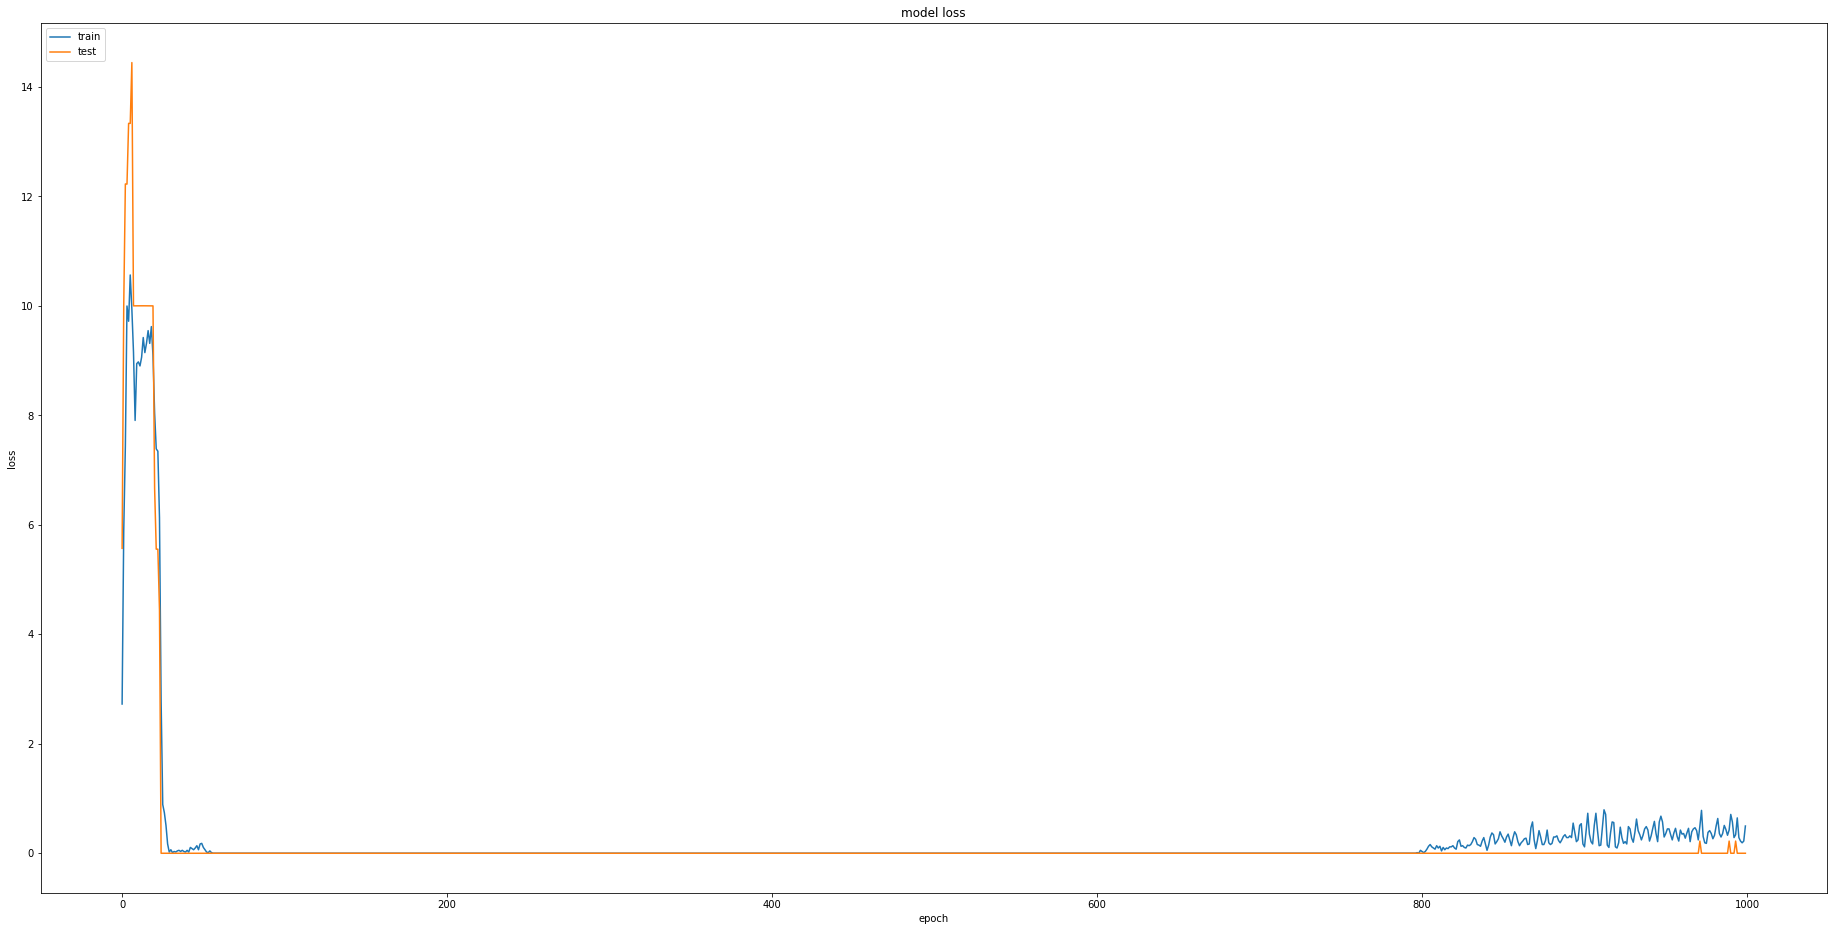

[array([[[16092., 16275., 16373., 16600., 16779., 16905., 17047., 17134.,
         17218., 17374.],
        [  197.,   198.,   200.,   205.,   206.,   205.,   207.,   207.,
           209.,   210.]]])]
day: 5, CC: 17460.0, CD: 212.0, val_pre_norm: [[17533.]
 [  211.]]

MSE-------------51.62363799656123

day: 6, CC: 17582.0, CD: 215.0, val_pre_norm: [[17633.]
 [  211.]]

MSE-------------36.173194495371845

day: 7, CC: 17705.0, CD: 218.0, val_pre_norm: [[17727.]
 [  213.]]

MSE-------------15.953056133543816

day: 8, CC: 17828.0, CD: 221.0, val_pre_norm: [[17795.]
 [  214.]]

MSE-------------23.853720883753127

day: 9, CC: 17952.0, CD: 224.0, val_pre_norm: [[17868.]
 [  214.]]

MSE-------------59.81638571495272

total mse: 37.48399904483655



<Figure size 432x288 with 0 Axes>

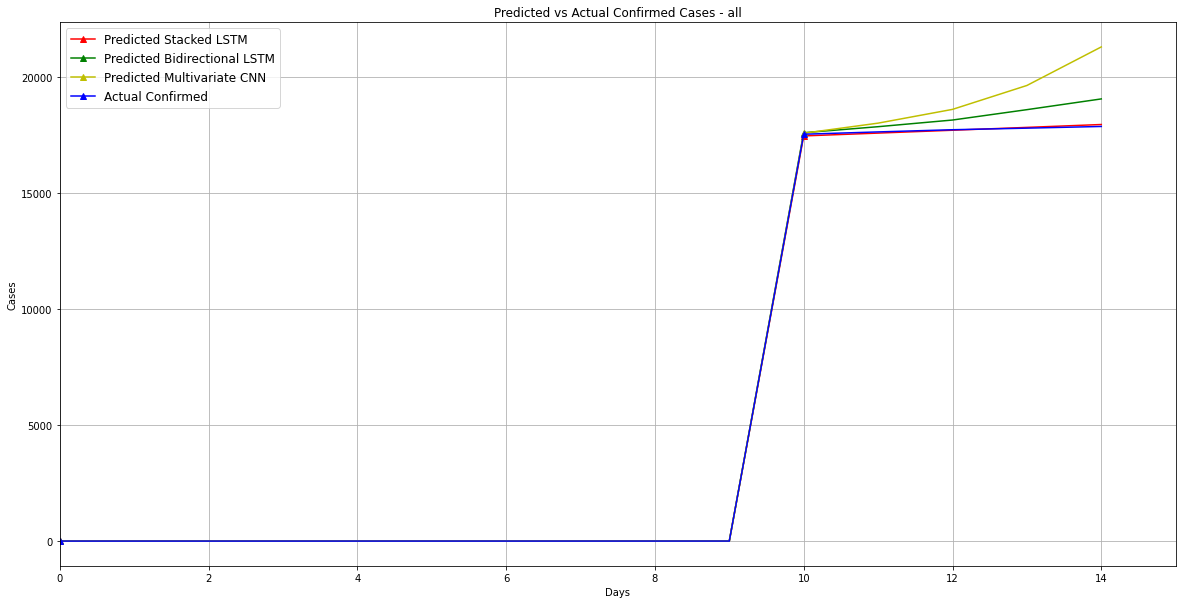

<Figure size 432x288 with 0 Axes>

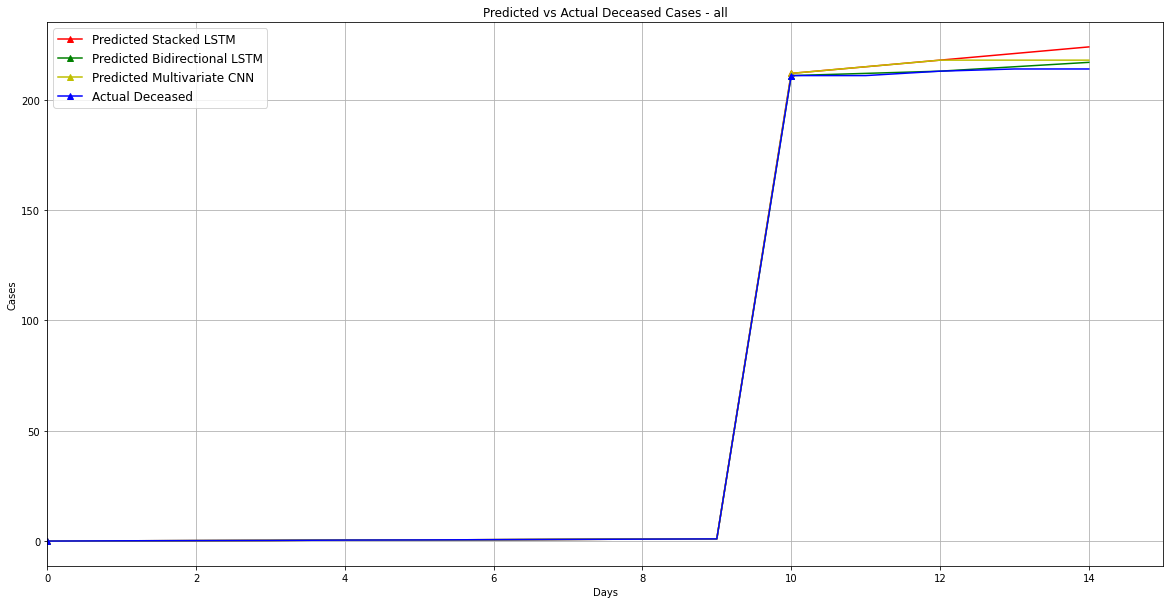

<Figure size 432x288 with 0 Axes>

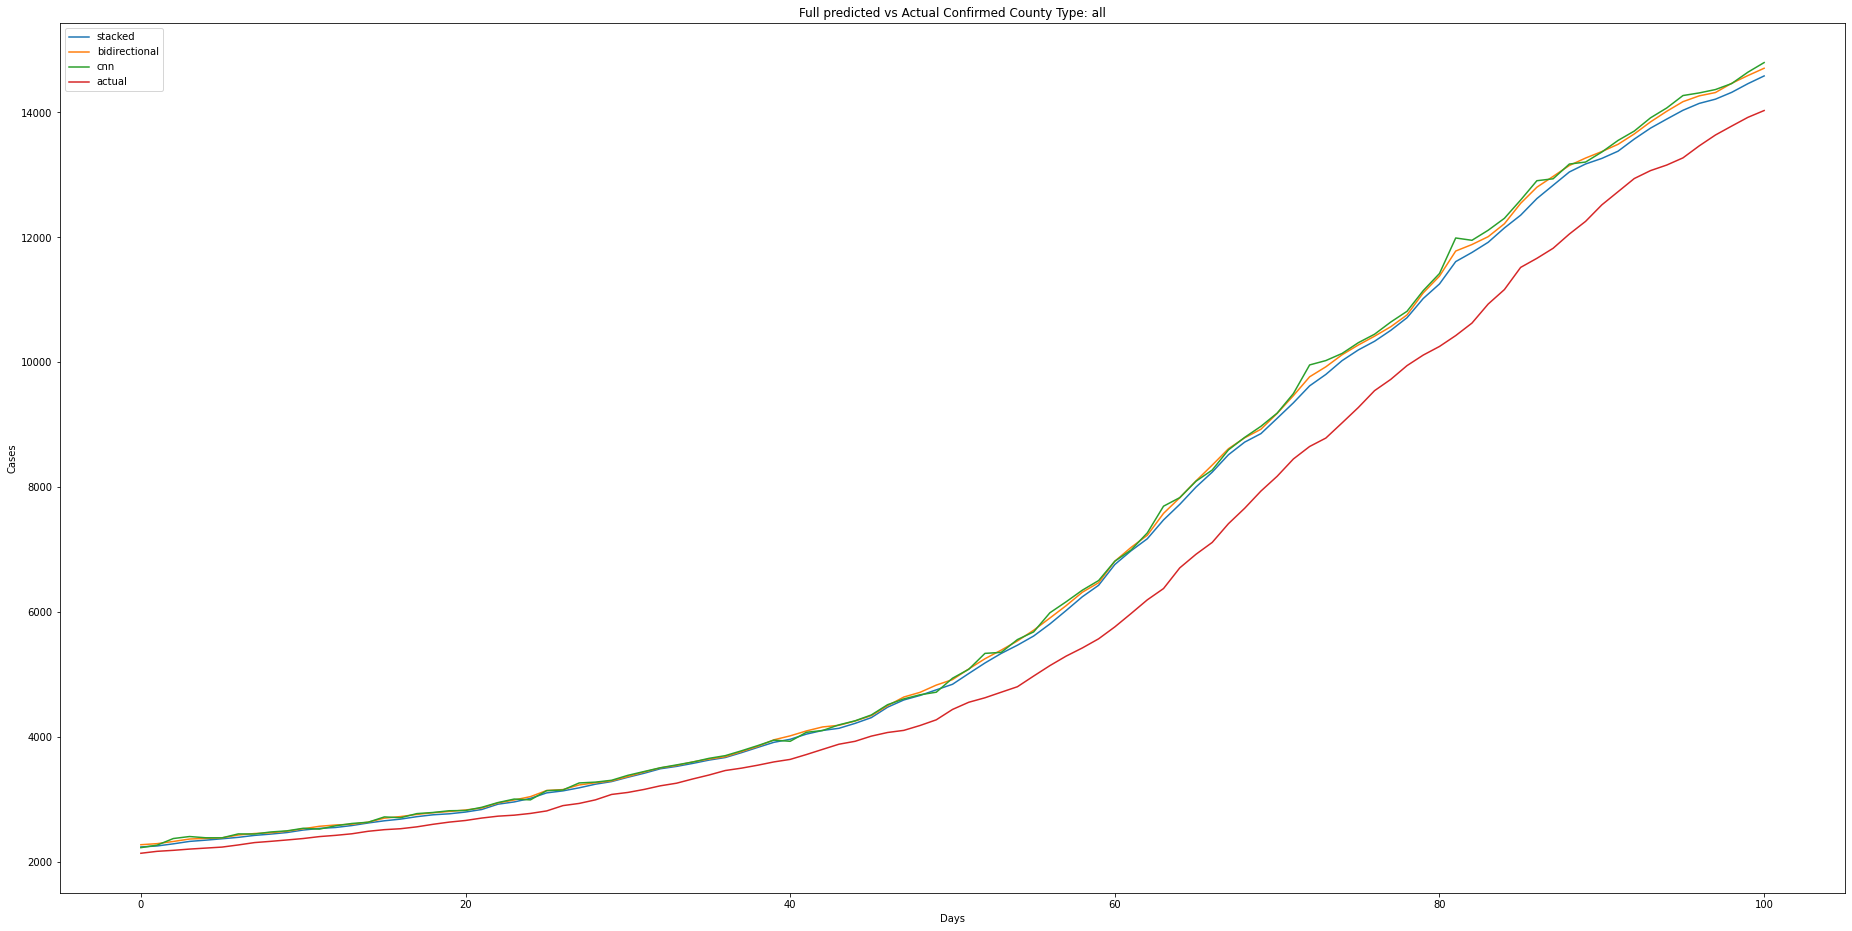

<Figure size 432x288 with 0 Axes>

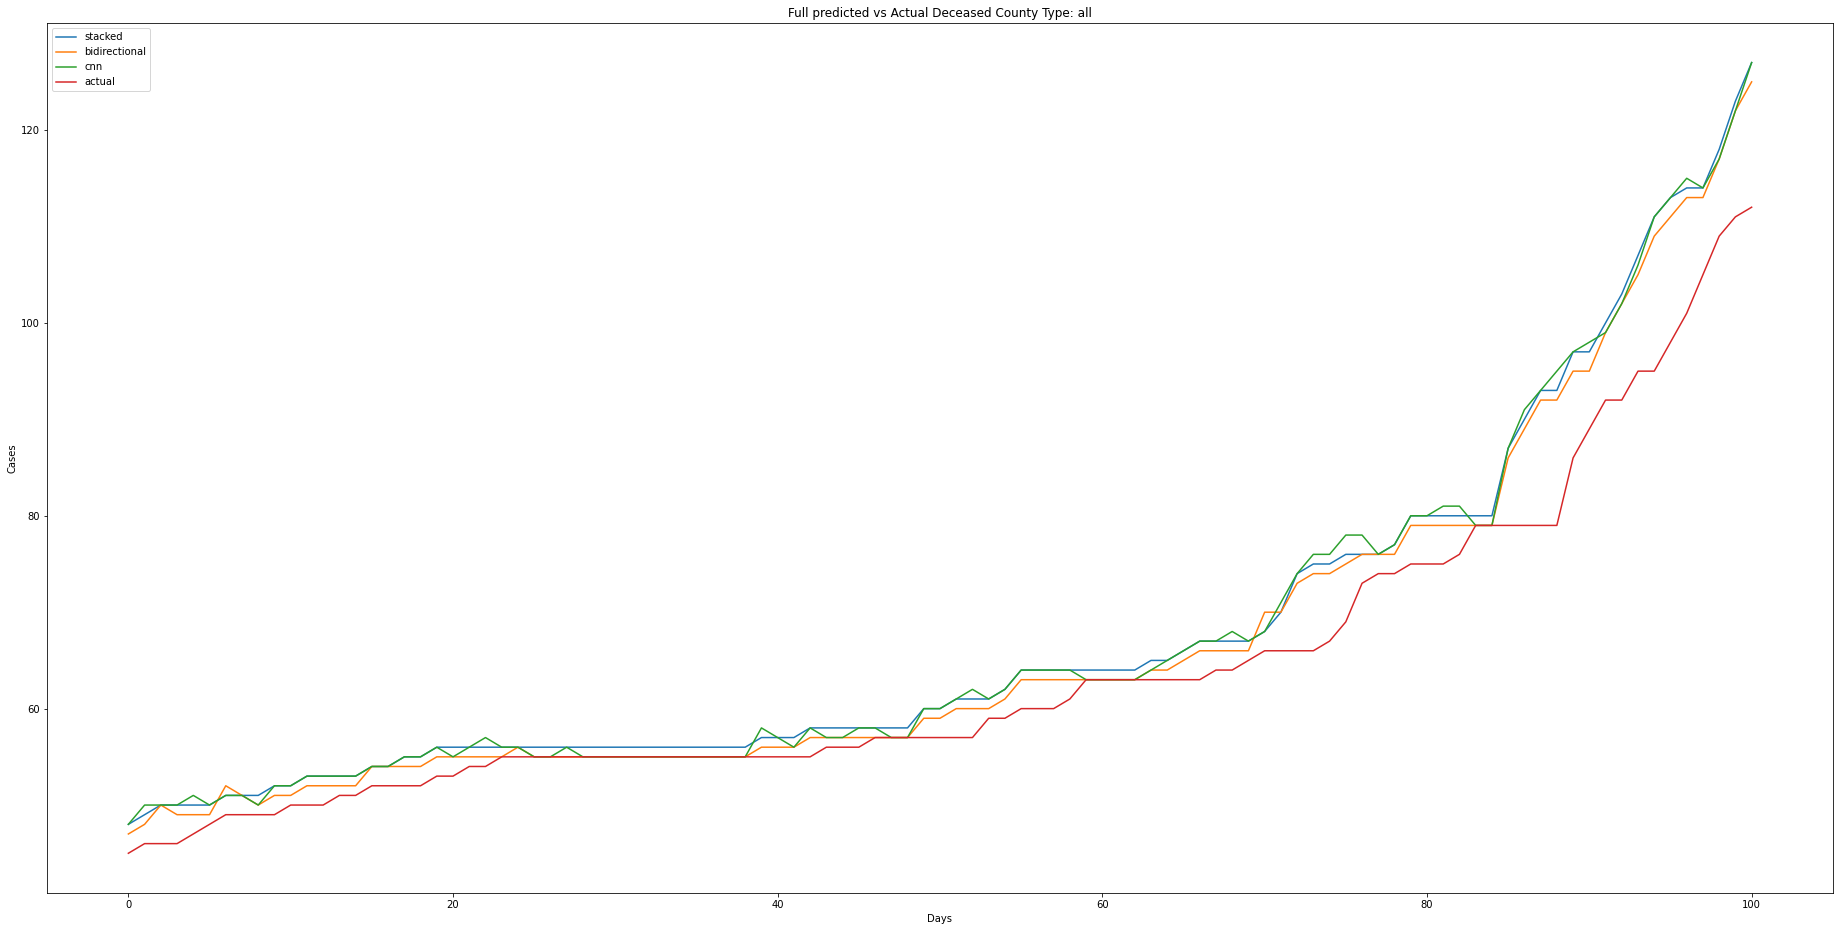

<Figure size 432x288 with 0 Axes>

In [ ]:
if cdl.county_type == 'urban' or cdl.county_type == 'all':
    print('Training urban MultiVariateCNN Model')
    cnn_urban_history = train_model(urban_cnn_model, urban_X_train, urban_X_val, urban_y_train, urban_y_val, urban_pop_train,
                                              urban_pop_val, urban_cnn_cp_name, ci.epochs, ci.batch_size, urban_cnn_log_dir, verbose_level)
    plot_model_loss(cnn_urban_history, urban_cnn_plot_loss_location)
    predd_conf_cnn, actt_conf, predd_dec_cnn, actt_dec, orig_input = \
        predict_n_days(model=urban_cnn_model, mdl=mdl, weight_file_path=urban_cnn_cp_name, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=urban_X_val_pre,
                    y_val_pre=urban_y_val_pre, population_val=urban_pop_val, verbose_flag=verbose_level, data_file=urban_cnn_data_location, batch_size=ci.batch_size)
    full_predd_conf_cnn, full_actt_conf, full_predd_dec_cnn, full_actt_dec = \
        calc_results(model=urban_cnn_model, weight_file_path=urban_cnn_cp_name, index=ci.index, X_test_pre=urban_X_test_pre,
                  pop_test=urban_pop_test, y_test_pre=urban_y_test_pre, data_file=urban_cnn_data_location, verbose_flag=verbose_level)

    print('Training urban bidirectional Model')
    bi_urban_history = train_model(urban_bidirectional_model, urban_X_train, urban_X_val, urban_y_train, urban_y_val, urban_pop_train,
                          urban_pop_val, urban_bi_cp_name, ci.epochs, ci.batch_size, urban_bi_log_dir, verbose_level)
    plot_model_loss(bi_urban_history, urban_bi_plot_loss_location)
    predd_conf_bi, actt_conf, predd_dec_bi, actt_dec, orig_input = \
        predict_n_days(model=urban_bidirectional_model, mdl=mdl, weight_file_path=urban_bi_cp_name, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=urban_X_val_pre,
                    y_val_pre=urban_y_val_pre, population_val=urban_pop_val, verbose_flag=verbose_level, data_file=urban_bi_data_location, batch_size=ci.batch_size)
    full_predd_conf_bi, full_actt_conf, full_predd_dec_bi, full_actt_dec = \
        calc_results(model=urban_bidirectional_model, weight_file_path=urban_bi_cp_name, index=ci.index, X_test_pre=urban_X_test_pre,
                  pop_test=urban_pop_test, y_test_pre=urban_y_test_pre, data_file=urban_bi_data_location, verbose_flag=verbose_level)

    print('Training urban stacked Model')
    urban_history = train_model(urban_stacked_model, urban_X_train, urban_X_val, urban_y_train, urban_y_val, urban_pop_train,
                          urban_pop_val, urban_stacked_cp_name, ci.epochs, ci.batch_size, urban_stacked_log_dir, verbose_level)
    plot_model_loss(urban_history, urban_stacked_plot_loss_location)
    predd_conf_stacked, actt_conf, predd_dec_stacked, actt_dec, orig_input = \
        predict_n_days(model=urban_stacked_model, mdl=mdl, weight_file_path=urban_stacked_cp_name, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=urban_X_val_pre,
                            y_val_pre=urban_y_val_pre, population_val=urban_pop_val, verbose_flag=verbose_level, data_file=urban_stacked_data_location, batch_size=ci.batch_size)
    full_predd_conf_stacked, full_actt_conf, full_predd_dec_stacked, full_actt_dec = \
        calc_results(model=urban_stacked_model, weight_file_path=urban_stacked_cp_name, index=ci.index, X_test_pre=urban_X_test_pre,
                  pop_test=urban_pop_test, y_test_pre=urban_y_test_pre, data_file=urban_stacked_data_location, verbose_flag=verbose_level)

    # Plot out the difference between actual and predicted for 5 day plot
    plot_pred_vs_act(orig_input, predd_conf_stacked, predd_conf_bi, predd_conf_cnn, actt_conf, urban_plot_5_day_conf_compare_location, county_type, isConfirmed=True)
    plot_pred_vs_act(orig_input, predd_dec_stacked, predd_dec_bi, predd_dec_cnn, actt_dec, urban_plot_5_day_desc_compare_location, county_type, isConfirmed=False)

    # Plot out the difference between actual and predicted for test data
    plot_pred_vs_act_full_test(full_predd_conf_stacked, full_predd_conf_bi, full_predd_conf_cnn, full_actt_conf, urban_plot_full_conf_compare_location, county_type, isConfirmed=True)
    plot_pred_vs_act_full_test(full_predd_dec_stacked, full_predd_dec_bi, full_predd_dec_cnn, full_actt_dec, urban_plot_full_desc_compare_location, county_type, isConfirmed=False)


##Load weight files for test/prediction - P




In [ ]:
rural_cnn_weight_file = '/content/drive/My Drive/CSU_CS535/rural_cnn.h5'
rural_bi_weight_file = '/content/drive/My Drive/CSU_CS535/rural_bidirectional.h5'
rural_stacked_weight_file = '/content/drive/My Drive/CSU_CS535/rural_stacked.h5'

suburban_cnn_weight_file = '/content/drive/My Drive/CSU_CS535/suburban_cnn.h5'
suburban_bi_weight_file = '/content/drive/My Drive/CSU_CS535/suburban_bidirectional.h5'
suburban_stacked_weight_file = '/content/drive/My Drive/CSU_CS535/suburban_stacked.h5'

urban_cnn_weight_file = '/content/drive/My Drive/CSU_CS535/urban_cnn.h5'
urban_bi_weight_file = '/content/drive/My Drive/CSU_CS535/urban_bidirectional.h5'
urban_stacked_weight_file = '/content/drive/My Drive/CSU_CS535/urban_stacked.h5'


###Rural info from weight file

Setting up the rural data for the models. Number of rural counties in US:  782
Number of counties to process on this worker:  782
date                  0
key                   0
new_confirmed         0
new_deceased          0
new_tested         1197
total_confirmed       0
total_deceased        0
total_tested       1197
dtype: int64
date                  0
key                   0
new_confirmed         0
new_deceased          0
new_tested         1197
total_confirmed       0
total_deceased        0
total_tested       1197
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of areas with full set of data:  694
(624, 2, 125)
(624, 2, 25)
(70, 2, 150)
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 2, 10)]      0                                            
__________________________________________________________________________________________________
lstm_63 (LSTM)                  (None, 2, 128)       71168       input_29[0][0]                   
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 2, 128)       0           lstm_63[0][0]                    
__________________________________________________________________________________________________
lstm_64 (LSTM)                  (None, 2, 64)        49408       dropout_77[0][0]                 
_______

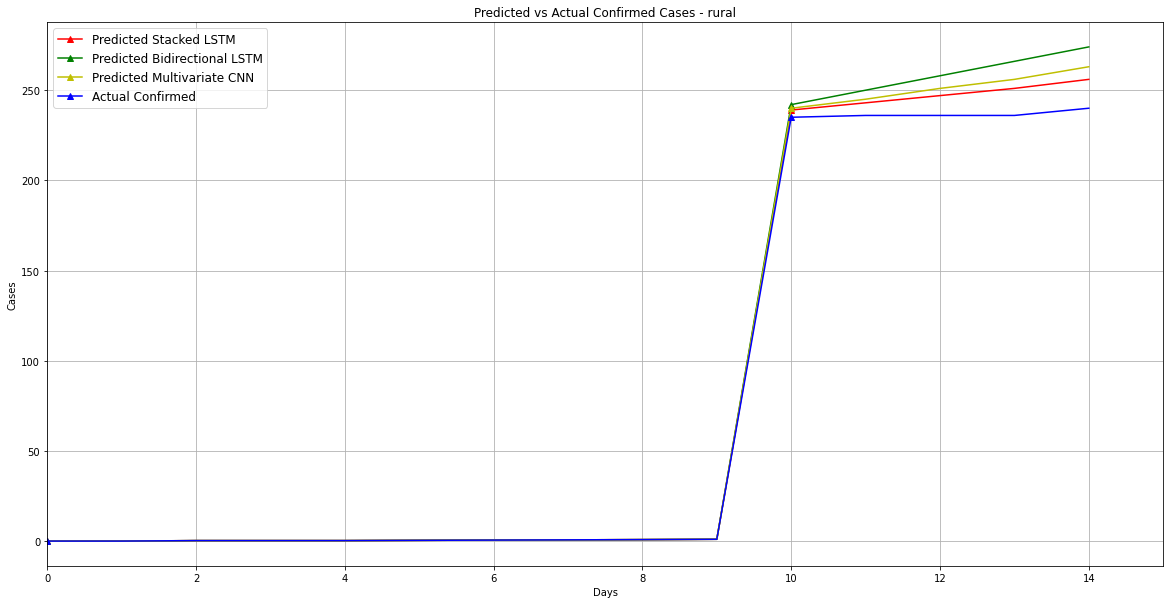

<Figure size 432x288 with 0 Axes>

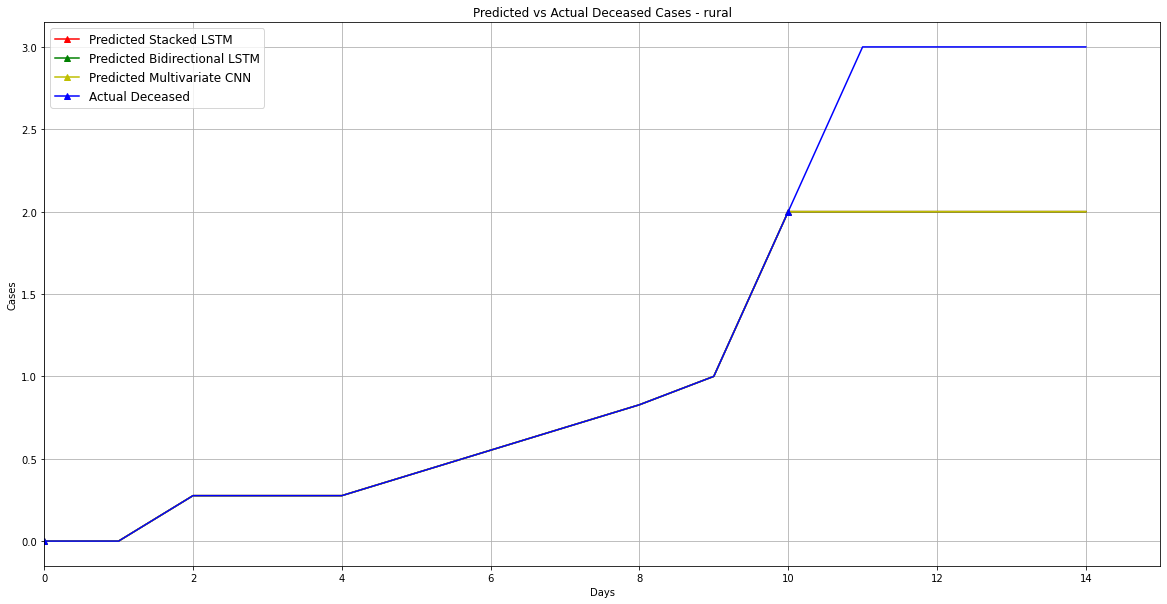

<Figure size 432x288 with 0 Axes>

In [ ]:
use_small = False
verbose_level = 0
county_type = 'rural'
us_pdl = PopulationDataLoader(ci, "US")
us_rural_keys, us_rural_pop_data, us_suburban_keys, us_suburban_pop_data, us_urban_keys, us_urban_pop_data = get_keys_and_pop_data_from_pdl(us_pdl)

# reloading data for weight run
# print('Setting up the rural data for the models. Number of rural counties in US: ', len(us_rural_keys))
# rural_X_train, rural_X_val, rural_y_train, rural_y_val, rural_pop_train, rural_pop_val, \
# rural_X_train_pre, rural_X_val_pre, rural_y_train_pre, rural_y_val_pre, \
# rural_X_test, rural_y_test, rural_pop_test, rural_X_test_pre, rural_y_test_pre = \
#     mdl.setup_data(pdl, ci.sequence_length, ci.prediction_days, us_rural_keys, 1, 0)

## Loading up models for weight run
rural_plot_5_day_conf_compare_location = cdl.log_rural_location + 'rural_5_day_confirmed.png'
rural_plot_5_day_desc_compare_location = cdl.log_rural_location + 'rural_5_day_desc.png'
rural_plot_full_conf_compare_location = cdl.log_rural_location + 'rural_full_confirmed.png'
rural_plot_full_desc_compare_location = cdl.log_rural_location + 'rural_full_desc.png'

rural_bdm = BidirectionalLSTM(ci.epochs, ci.batch_size)
rural_bidirectional_model = rural_bdm.create_bidirectional_model(ci.sequence_length, ci.prediction_days)
rural_bi_cp_name = cdl.log_rural_location + 'rural_bidirectional.h5'
rural_bi_plot_loss_location = cdl.log_rural_location + 'rural_bi_loss.png'
rural_bi_data_location = cdl.log_rural_location + 'rural_bi_data.txt'
rural_bi_log_dir = cdl.log_rural_location + 'bi_tb'

rural_cnn = MultiVariateCNN(ci.epochs, ci.batch_size)
rural_cnn_model = rural_cnn.create_multivariatecnn_model(ci.sequence_length,ci.prediction_days)
rural_cnn_cp_name = cdl.log_rural_location + 'rural_cnn.h5'
rural_cnn_plot_loss_location = cdl.log_rural_location + 'rural_cnn_loss.png'
rural_cnn_data_location = cdl.log_rural_location + 'rural_cnn_data.txt'
rural_cnn_log_dir = cdl.log_rural_location + 'rural_cnn_log'
rural_cnn_log_dir = cdl.log_rural_location + 'cnn_tb'

rural_stacked = StackedLSTMModel(ci.epochs, ci.batch_size)
rural_stacked_model = rural_stacked.setup_model(ci.sequence_length, ci.prediction_days)
rural_stacked_cp_name = cdl.log_rural_location + 'rural_stacked.h5'
rural_stacked_plot_loss_location = cdl.log_rural_location + 'rural_stacked_loss.png'
rural_stacked_data_location = cdl.log_rural_location + 'rural_stacked_data.txt'
rural_stacked_log_dir = cdl.log_rural_location + 'stacked_tb'

#We get to skip training because we are pulling the information from the weight files now.
predd_conf_cnn, actt_conf, predd_dec_cnn, actt_dec, orig_input = \
    predict_n_days(model=rural_cnn_model, mdl=mdl, weight_file_path=rural_cnn_weight_file, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=rural_X_val_pre,
                y_val_pre=rural_y_val_pre, population_val=rural_pop_val, verbose_flag=verbose_level, data_file=rural_cnn_data_location, batch_size=ci.batch_size)
    
predd_conf_bi, actt_conf, predd_dec_bi, actt_dec, orig_input = \
    predict_n_days(model=rural_bidirectional_model, mdl=mdl, weight_file_path=rural_bi_weight_file, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=rural_X_val_pre,
                y_val_pre=rural_y_val_pre, population_val=rural_pop_val, verbose_flag=verbose_level, data_file=rural_bi_data_location, batch_size=ci.batch_size)

predd_conf_stacked, actt_conf, predd_dec_stacked, actt_dec, orig_input = \
    predict_n_days(model=rural_stacked_model, mdl=mdl, weight_file_path=rural_stacked_weight_file, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=rural_X_val_pre,
                y_val_pre=rural_y_val_pre, population_val=rural_pop_val, verbose_flag=verbose_level, data_file=rural_stacked_data_location, batch_size=ci.batch_size)

# Plot out the difference between actual and predicted for 5 day plot
plot_pred_vs_act(orig_input, predd_conf_stacked, predd_conf_bi, predd_conf_cnn, actt_conf, rural_plot_5_day_conf_compare_location, county_type, isConfirmed=True)
plot_pred_vs_act(orig_input, predd_dec_stacked, predd_dec_bi, predd_dec_cnn, actt_dec, rural_plot_5_day_desc_compare_location, county_type, isConfirmed=False)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in double_scalars


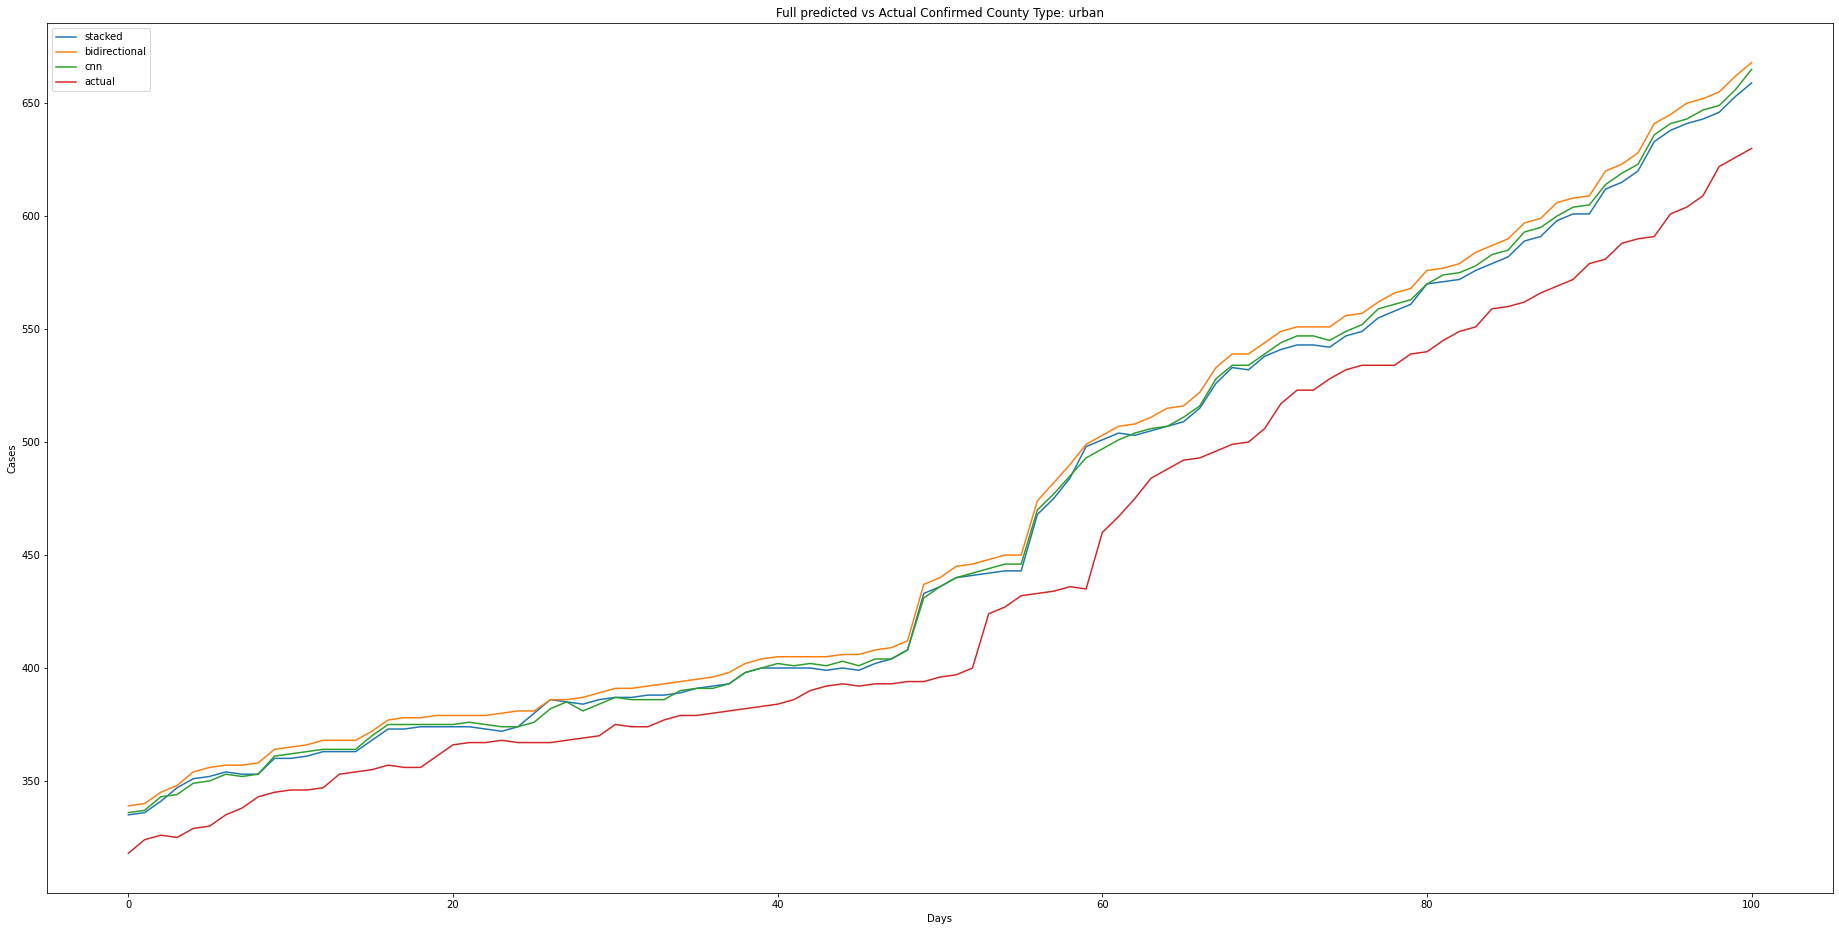

<Figure size 432x288 with 0 Axes>

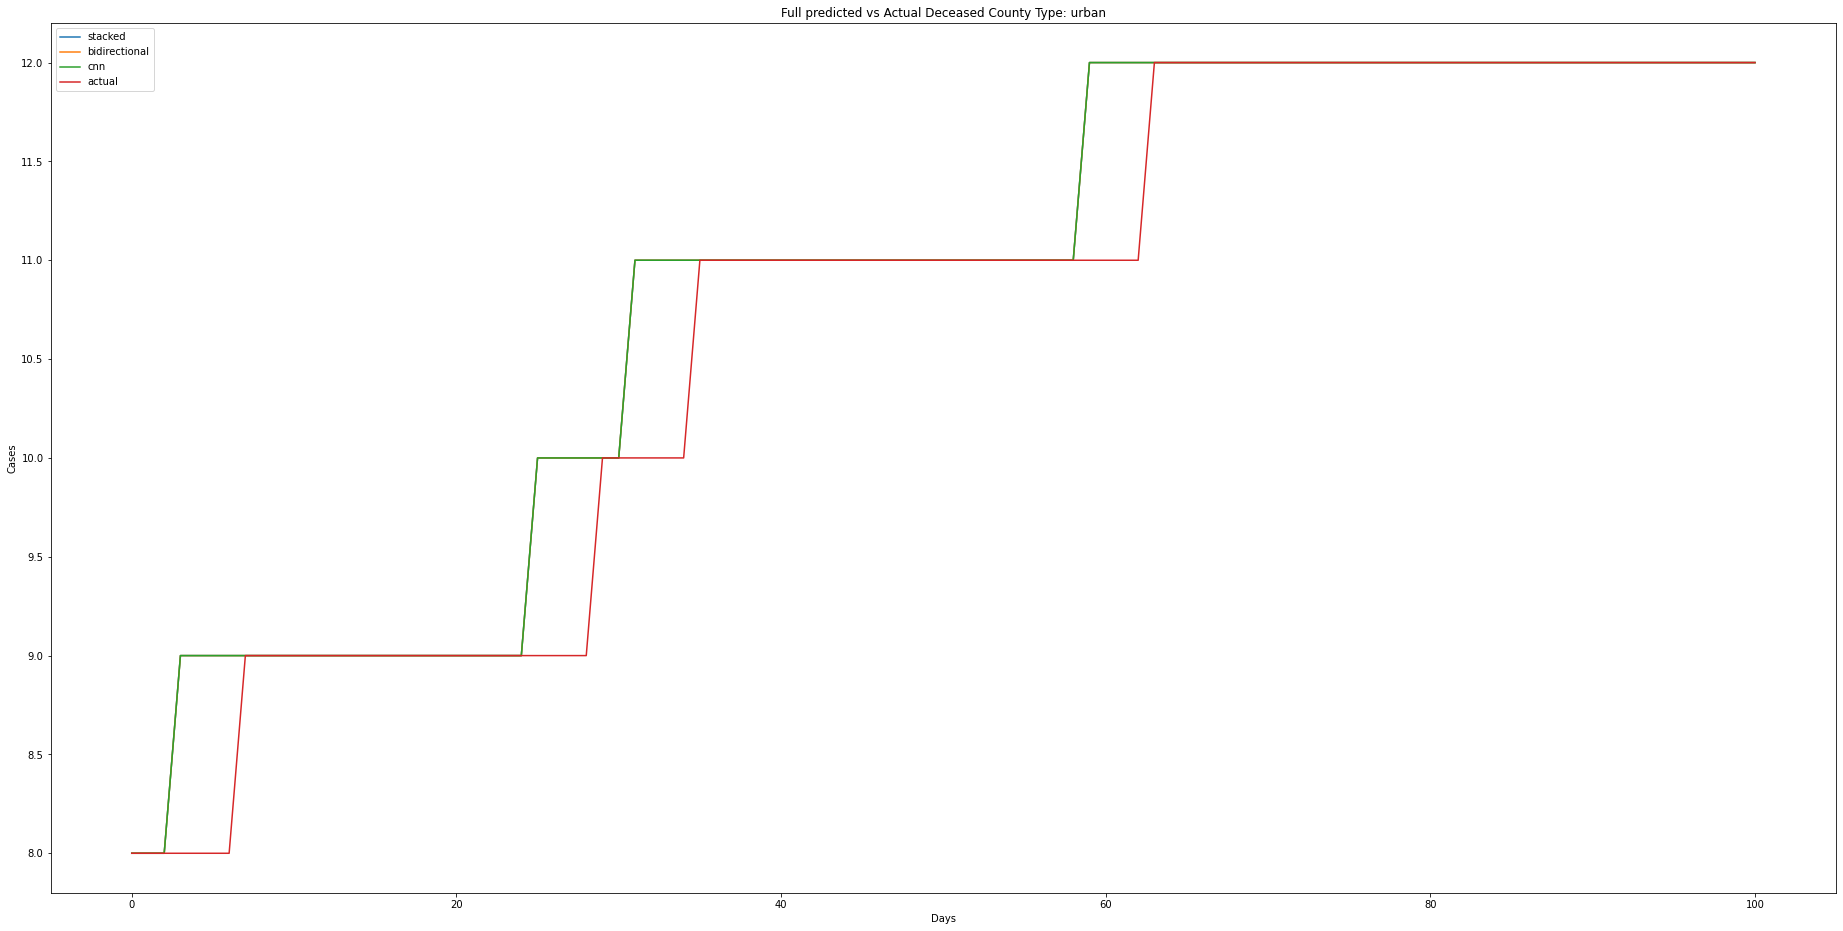

<Figure size 432x288 with 0 Axes>

In [ ]:
## Now try to get graphs for full run of act/pred - this takes much longer because need to run through full 150 days
full_predd_conf_cnn, full_actt_conf, full_predd_dec_cnn, full_actt_dec = \
    calc_results(model=rural_cnn_model, weight_file_path=rural_cnn_weight_file, index=ci.index, X_test_pre=rural_X_test_pre,
              pop_test=rural_pop_test, y_test_pre=rural_y_test_pre, data_file=rural_cnn_data_location, verbose_flag=verbose_level)

full_predd_conf_bi, full_actt_conf, full_predd_dec_bi, full_actt_dec = \
    calc_results(model=rural_bidirectional_model, weight_file_path=rural_bi_weight_file, index=ci.index, X_test_pre=rural_X_test_pre,
              pop_test=rural_pop_test, y_test_pre=rural_y_test_pre, data_file=rural_bi_data_location, verbose_flag=verbose_level)

full_predd_conf_stacked, full_actt_conf, full_predd_dec_stacked, full_actt_dec= \
    calc_results(model=rural_stacked_model, weight_file_path=rural_stacked_weight_file, index=ci.index, X_test_pre=rural_X_test_pre,
              pop_test=rural_pop_test, y_test_pre=rural_y_test_pre, data_file=rural_stacked_data_location, verbose_flag=verbose_level)

# Plot out the difference between actual and predicted for test data
plot_pred_vs_act_full_test(full_predd_conf_stacked, full_predd_conf_bi, full_predd_conf_cnn, full_actt_conf, rural_plot_full_conf_compare_location, county_type, isConfirmed=True)
plot_pred_vs_act_full_test(full_predd_dec_stacked, full_predd_dec_bi, full_predd_dec_cnn, full_actt_dec, rural_plot_full_desc_compare_location, county_type, isConfirmed=False)


###Suburban info from weight file

Setting up the suburban data for the models. Number of suburban counties in US:  1853
Number of counties to process on this worker:  618
date                 0
key                  0
new_confirmed        0
new_deceased         0
new_tested         588
total_confirmed      0
total_deceased       0
total_tested       588
dtype: int64
date                 0
key                  0
new_confirmed        0
new_deceased         0
new_tested         588
total_confirmed      0
total_deceased       0
total_tested       588
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of areas with full set of data:  611
(549, 2, 125)
(549, 2, 25)
(62, 2, 150)
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 2, 10)]      0                                            
__________________________________________________________________________________________________
lstm_77 (LSTM)                  (None, 2, 128)       71168       input_35[0][0]                   
__________________________________________________________________________________________________
dropout_94 (Dropout)            (None, 2, 128)       0           lstm_77[0][0]                    
__________________________________________________________________________________________________
lstm_78 (LSTM)                  (None, 2, 64)        49408       dropout_94[0][0]                 
_______

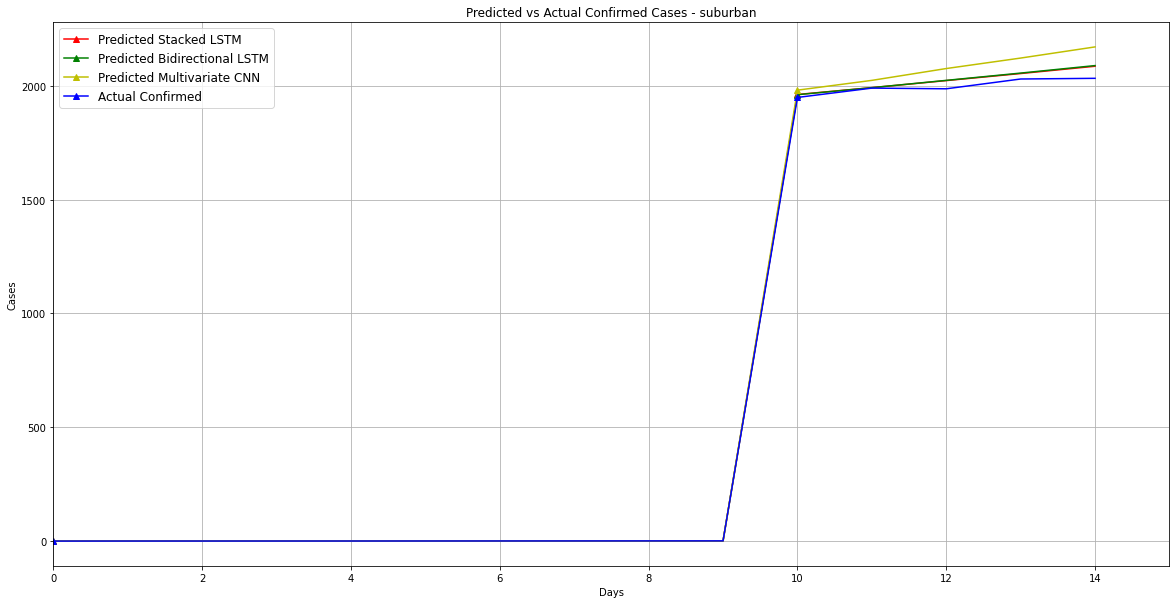

<Figure size 432x288 with 0 Axes>

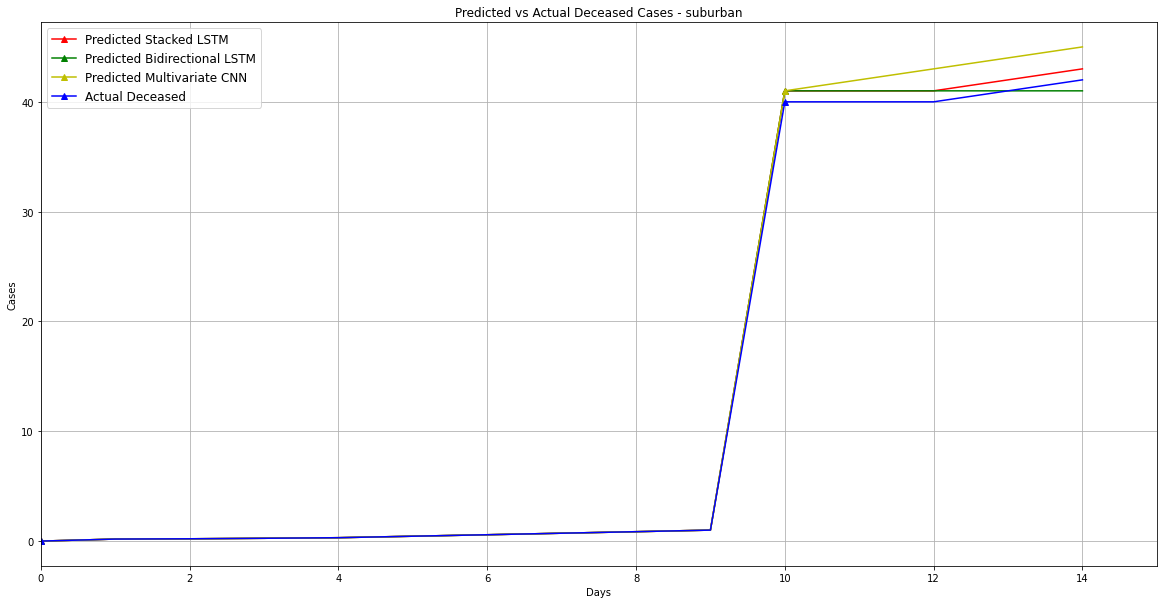

<Figure size 432x288 with 0 Axes>

In [ ]:
use_small = False
verbose_level = 0
county_type = 'suburban'
us_pdl = PopulationDataLoader(ci, "US")
us_rural_keys, us_rural_pop_data, us_suburban_keys, us_suburban_pop_data, us_urban_keys, us_urban_pop_data = get_keys_and_pop_data_from_pdl(us_pdl)

# reloading data for weight run
# print('Setting up the suburban data for the models. Number of suburban counties in US: ', len(us_suburban_keys))
# suburban_X_train, suburban_X_val, suburban_y_train, suburban_y_val, suburban_pop_train, suburban_pop_val, \
# suburban_X_train_pre, suburban_X_val_pre, suburban_y_train_pre, suburban_y_val_pre, \
# suburban_X_test, suburban_y_test, suburban_pop_test, suburban_X_test_pre, suburban_y_test_pre = \
#     mdl.setup_data(pdl, ci.sequence_length, ci.prediction_days, us_suburban_keys, 3, 1)

## Loading up models for weight run
suburban_plot_5_day_conf_compare_location = cdl.log_suburban_location + 'suburban_5_day_confirmed.png'
suburban_plot_5_day_desc_compare_location = cdl.log_suburban_location + 'suburban_5_day_desc.png'
suburban_plot_full_conf_compare_location = cdl.log_suburban_location + 'suburban_full_confirmed.png'
suburban_plot_full_desc_compare_location = cdl.log_suburban_location + 'suburban_full_desc.png'

suburban_bdm = BidirectionalLSTM(ci.epochs, ci.batch_size)
suburban_bidirectional_model = suburban_bdm.create_bidirectional_model(ci.sequence_length, ci.prediction_days)
suburban_bi_cp_name = cdl.log_suburban_location + 'suburban_bidirectional.h5'
suburban_bi_plot_loss_location = cdl.log_suburban_location + 'suburban_bi_loss.png'
suburban_bi_data_location = cdl.log_suburban_location + 'suburban_bi_data.txt'
suburban_bi_log_dir = cdl.log_suburban_location + 'bi_tb'

suburban_cnn = MultiVariateCNN(ci.epochs, ci.batch_size)
suburban_cnn_model = suburban_cnn.create_multivariatecnn_model(ci.sequence_length,ci.prediction_days)
suburban_cnn_cp_name = cdl.log_suburban_location + 'suburban_cnn.h5'
suburban_cnn_plot_loss_location = cdl.log_suburban_location + 'suburban_cnn_loss.png'
suburban_cnn_data_location = cdl.log_suburban_location + 'suburban_cnn_data.txt'
suburban_cnn_log_dir = cdl.log_suburban_location + 'cnn_tb'

suburban_stacked = StackedLSTMModel(ci.epochs, ci.batch_size)
suburban_stacked_model = suburban_stacked.setup_model(ci.sequence_length, ci.prediction_days)
suburban_stacked_cp_name = cdl.log_suburban_location + 'suburban_stacked.h5'
suburban_stacked_plot_loss_location = cdl.log_suburban_location + 'suburban_stacked_loss.png'
suburban_stacked_data_location = cdl.log_suburban_location + 'suburban_stacked_data.txt'
suburban_stacked_log_dir = cdl.log_suburban_location + 'stacked_tb'


#We get to skip training because we are pulling the information from the weight files now.
predd_conf_cnn, actt_conf, predd_dec_cnn, actt_dec, orig_input = \
    predict_n_days(model=suburban_cnn_model, mdl=mdl, weight_file_path=suburban_cnn_weight_file, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=suburban_X_val_pre,
                y_val_pre=suburban_y_val_pre, population_val=suburban_pop_val, verbose_flag=verbose_level, data_file=suburban_cnn_data_location, batch_size=ci.batch_size)

predd_conf_bi, actt_conf, predd_dec_bi, actt_dec, orig_input = \
    predict_n_days(model=suburban_bidirectional_model, mdl=mdl, weight_file_path=suburban_bi_weight_file, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=suburban_X_val_pre,
                y_val_pre=suburban_y_val_pre, population_val=suburban_pop_val, verbose_flag=verbose_level, data_file=suburban_bi_data_location, batch_size=ci.batch_size)

predd_conf_stacked, actt_conf, predd_dec_stacked, actt_dec, orig_input = \
    predict_n_days(model=suburban_stacked_model, mdl=mdl, weight_file_path=suburban_stacked_weight_file, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=suburban_X_val_pre,
                y_val_pre=suburban_y_val_pre, population_val=suburban_pop_val, verbose_flag=verbose_level, data_file=suburban_stacked_data_location, batch_size=ci.batch_size)

# Plot out the difference between actual and predicted for 5 day plot
plot_pred_vs_act(orig_input, predd_conf_stacked, predd_conf_bi, predd_conf_cnn, actt_conf, suburban_plot_5_day_conf_compare_location, county_type, isConfirmed=True)
plot_pred_vs_act(orig_input, predd_dec_stacked, predd_dec_bi, predd_dec_cnn, actt_dec, suburban_plot_5_day_desc_compare_location, county_type, isConfirmed=False)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:143: RuntimeWarning: divide by zero encountered in double_scalars


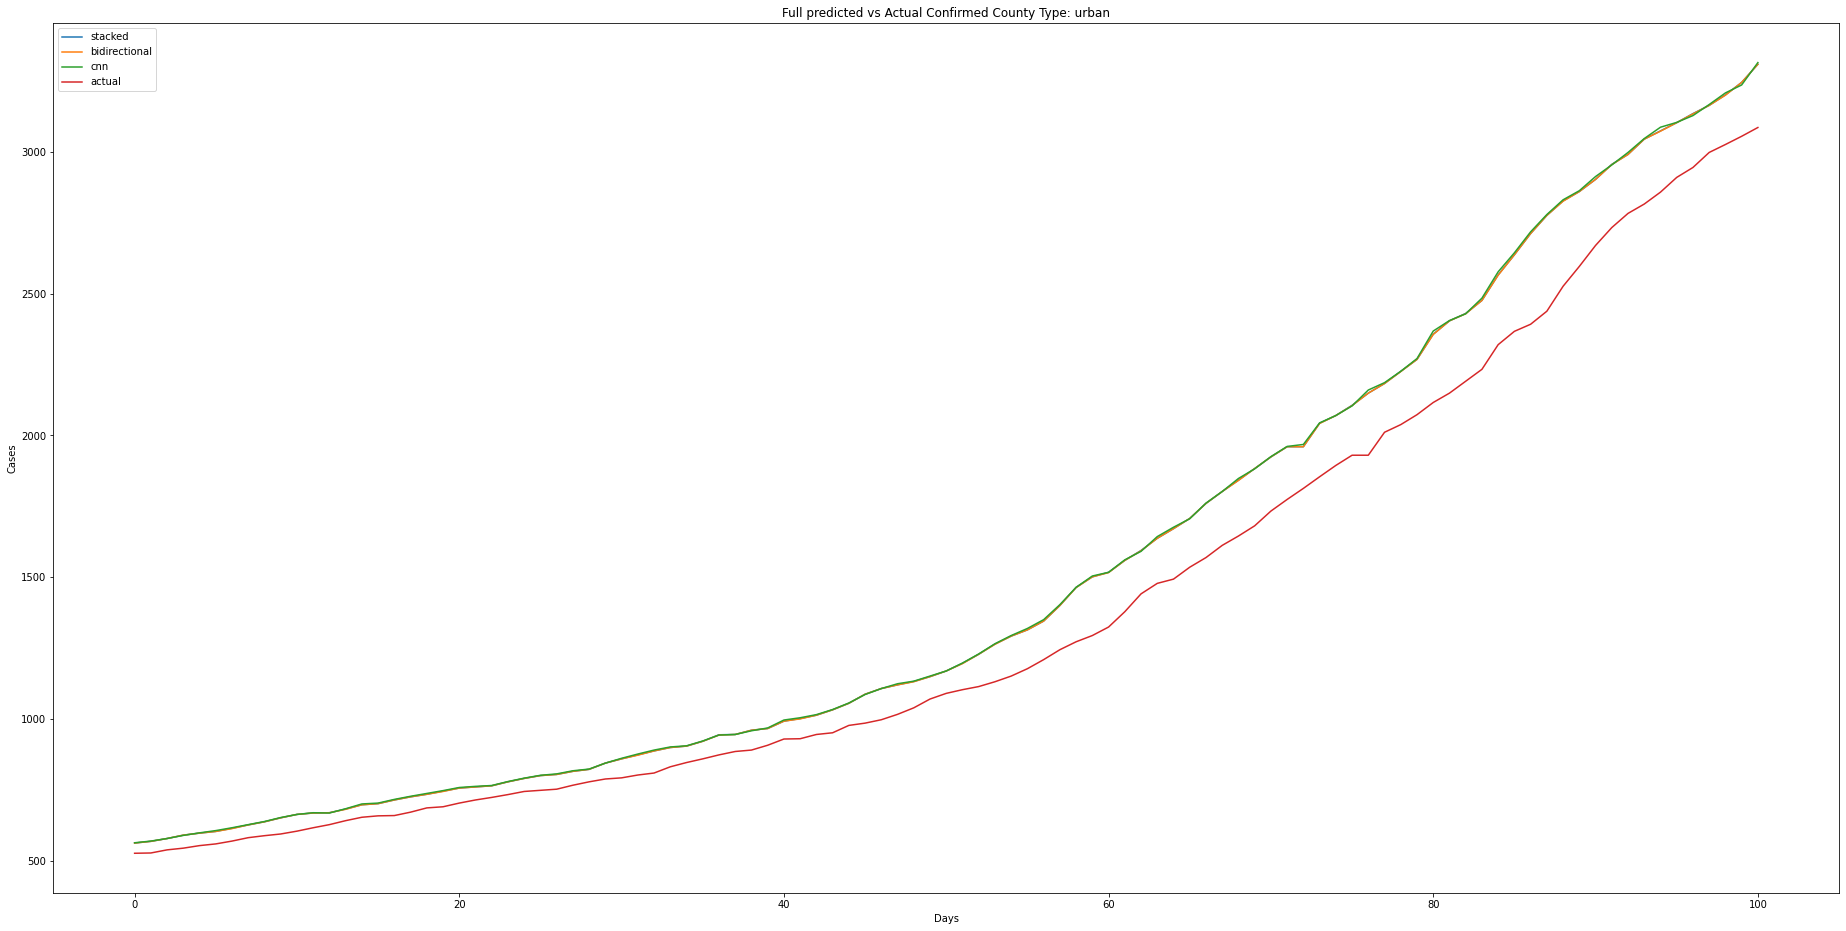

<Figure size 432x288 with 0 Axes>

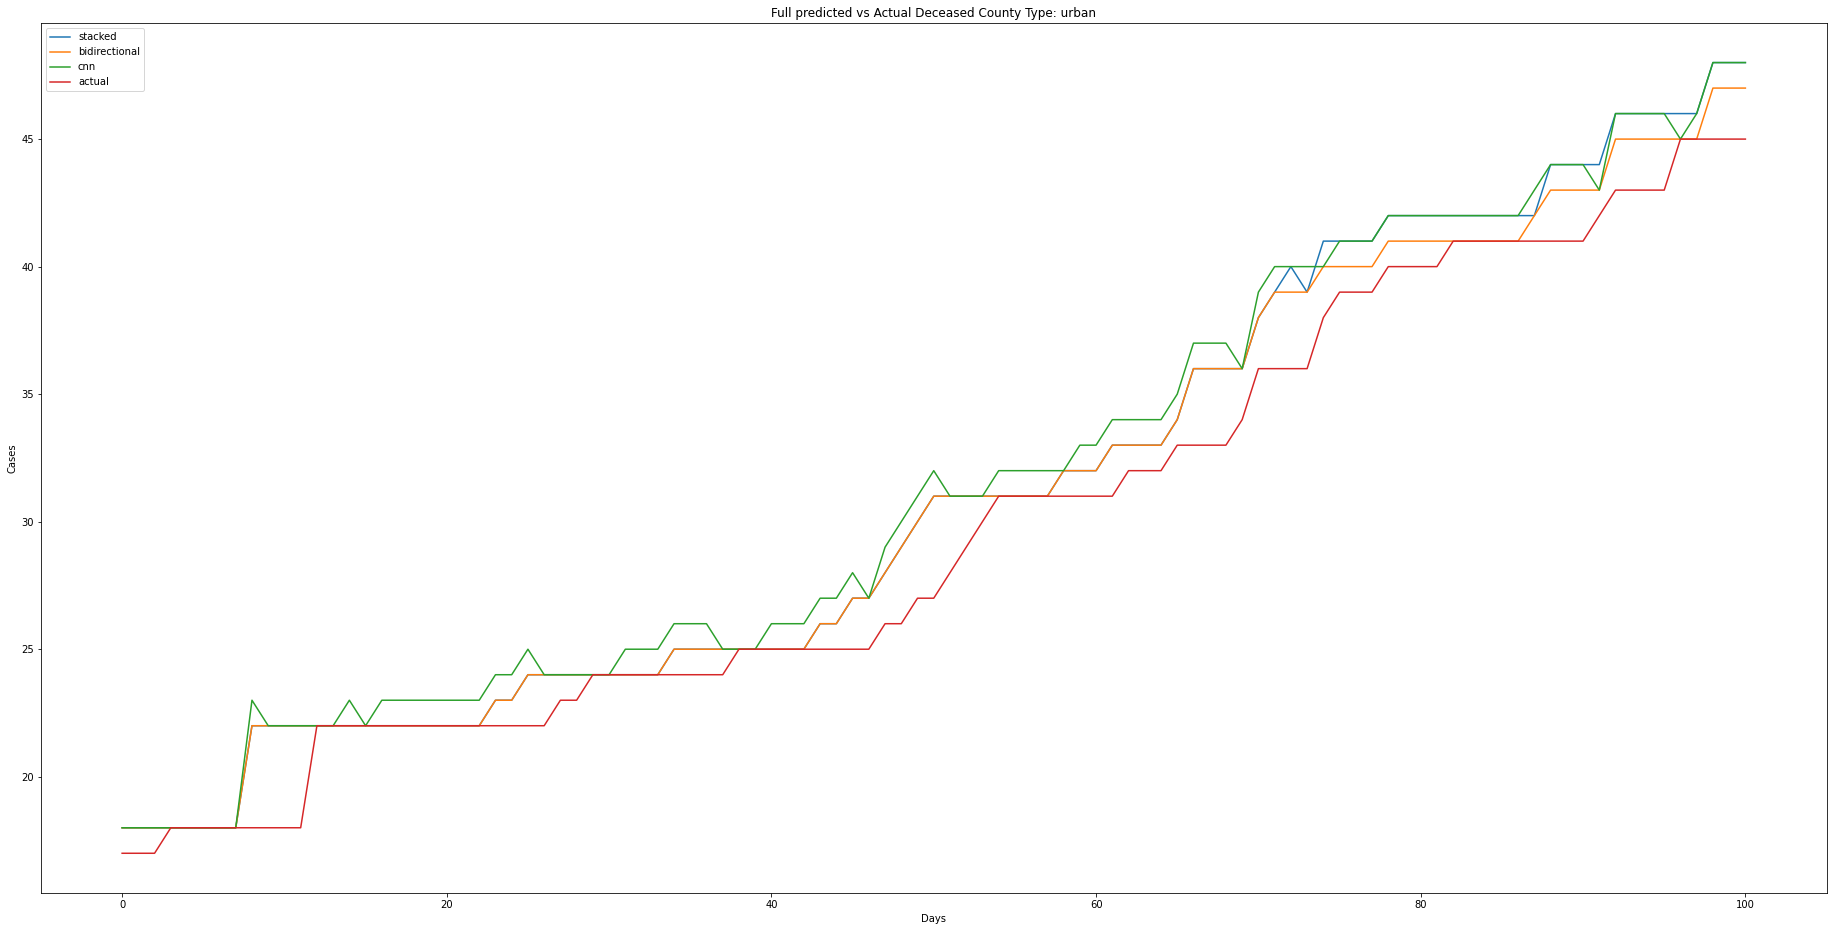

<Figure size 432x288 with 0 Axes>

In [ ]:
## Now try to get graphs for full run of act/pred - this takes much longer because need to run through full 150 days
full_predd_conf_cnn, full_actt_conf, full_predd_dec_cnn, full_actt_dec = \
    calc_results(model=suburban_cnn_model, weight_file_path=suburban_cnn_weight_file, index=ci.index, X_test_pre=suburban_X_test_pre,
              pop_test=suburban_pop_test, y_test_pre=suburban_y_test_pre, data_file=suburban_cnn_data_location, verbose_flag=verbose_level)

full_predd_conf_bi, full_actt_conf, full_predd_dec_bi, full_actt_dec = \
    calc_results(model=suburban_bidirectional_model, weight_file_path=suburban_bi_weight_file, index=ci.index, X_test_pre=suburban_X_test_pre,
              pop_test=suburban_pop_test, y_test_pre=suburban_y_test_pre, data_file=suburban_bi_data_location, verbose_flag=verbose_level)

full_predd_conf_stacked, full_actt_conf, full_predd_dec_stacked, full_actt_dec= \
    calc_results(model=suburban_stacked_model, weight_file_path=suburban_stacked_weight_file, index=ci.index, X_test_pre=suburban_X_test_pre,
              pop_test=suburban_pop_test, y_test_pre=suburban_y_test_pre, data_file=suburban_stacked_data_location, verbose_flag=verbose_level)

# Plot out the difference between actual and predicted for test data
plot_pred_vs_act_full_test(full_predd_conf_stacked, full_predd_conf_bi, full_predd_conf_cnn, full_actt_conf, suburban_plot_full_conf_compare_location, county_type, isConfirmed=True)
plot_pred_vs_act_full_test(full_predd_dec_stacked, full_predd_dec_bi, full_predd_dec_cnn, full_actt_dec, suburban_plot_full_desc_compare_location, county_type, isConfirmed=False)


###Urban info from weight file

Setting up the urban data for the models. Number of urban training counties in US:  598
Number of counties to process on this worker:  598
date                 0
key                  0
new_confirmed        0
new_deceased         0
new_tested         277
total_confirmed      0
total_deceased       0
total_tested       277
dtype: int64
date                 0
key                  0
new_confirmed        0
new_deceased         0
new_tested         277
total_confirmed      0
total_deceased       0
total_tested       277
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of areas with full set of data:  596
(536, 2, 125)
(536, 2, 25)
(60, 2, 150)
Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 2, 10)]      0                                            
__________________________________________________________________________________________________
lstm_91 (LSTM)                  (None, 2, 128)       71168       input_41[0][0]                   
__________________________________________________________________________________________________
dropout_111 (Dropout)           (None, 2, 128)       0           lstm_91[0][0]                    
__________________________________________________________________________________________________
lstm_92 (LSTM)                  (None, 2, 64)        49408       dropout_111[0][0]                
_______

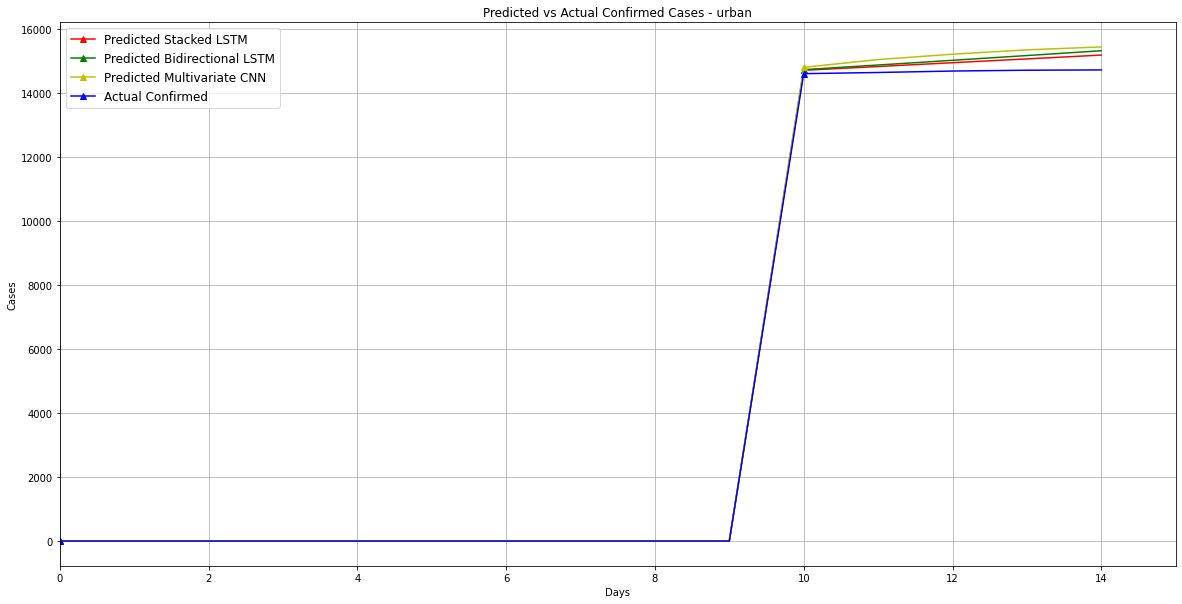

<Figure size 432x288 with 0 Axes>

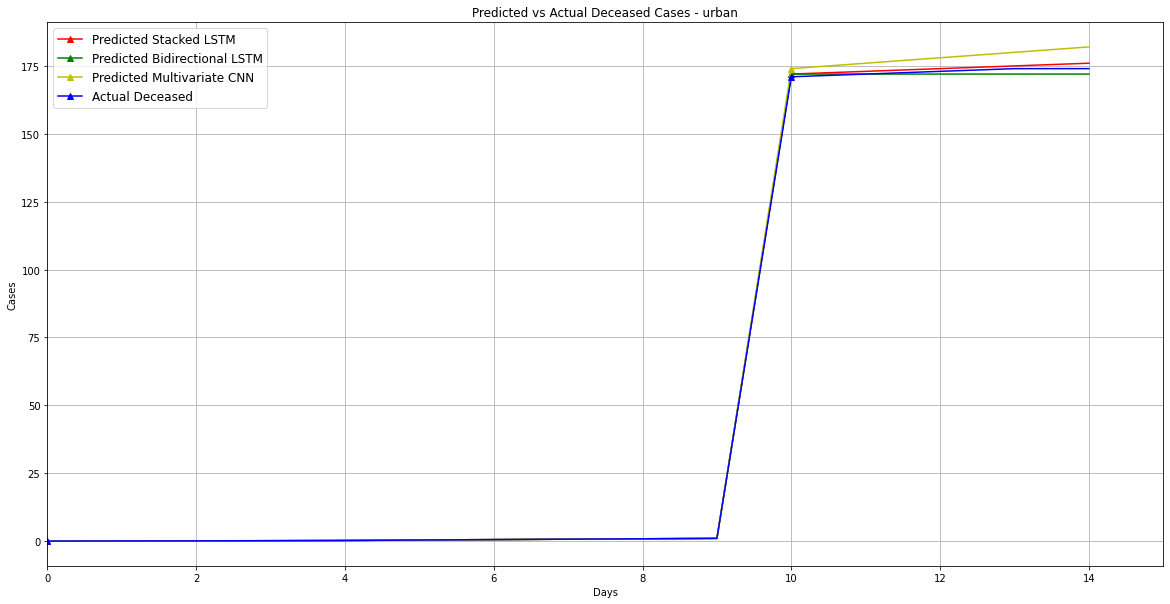

<Figure size 432x288 with 0 Axes>

In [ ]:
use_small = False
verbose_level = 0
county_type = 'urban'
us_pdl = PopulationDataLoader(ci, "US")
us_rural_keys, us_rural_pop_data, us_suburban_keys, us_suburban_pop_data, us_urban_keys, us_urban_pop_data = get_keys_and_pop_data_from_pdl(us_pdl)

# reloading data for weight run
# print('Setting up the urban data for the models. Number of urban training counties in US: ', len(us_urban_keys))
# urban_X_train, urban_X_val, urban_y_train, urban_y_val, urban_pop_train, urban_pop_val, \
# urban_X_train_pre, urban_X_val_pre, urban_y_train_pre, urban_y_val_pre, \
# urban_X_test, urban_y_test, urban_pop_test, urban_X_test_pre, urban_y_test_pre = \
#     mdl.setup_data(pdl, ci.sequence_length, ci.prediction_days, us_urban_keys, 1, 0)

## Loading up models for weight run
urban_plot_5_day_conf_compare_location = cdl.log_urban_location + 'urban_5_day_confirmed.png'
urban_plot_5_day_desc_compare_location = cdl.log_urban_location + 'urban_5_day_desc.png'
urban_plot_full_conf_compare_location = cdl.log_urban_location + 'urban_full_confirmed.png'
urban_plot_full_desc_compare_location = cdl.log_urban_location + 'urban_full_desc.png'

urban_bdm = BidirectionalLSTM(ci.epochs, ci.batch_size)
urban_bidirectional_model = urban_bdm.create_bidirectional_model(ci.sequence_length, ci.prediction_days)
urban_bi_cp_name = cdl.log_urban_location + 'urban_bidirectional.h5'
urban_bi_plot_loss_location = cdl.log_urban_location + 'urban_bi_loss.png'
urban_bi_data_location = cdl.log_urban_location + 'urban_bi_data.txt'
urban_bi_log_dir = cdl.log_urban_location + 'bi_tb'

urban_cnn = MultiVariateCNN(ci.epochs, ci.batch_size)
urban_cnn_model = urban_cnn.create_multivariatecnn_model(ci.sequence_length,ci.prediction_days)
urban_cnn_cp_name = cdl.log_urban_location + 'urban_cnn.h5'
urban_cnn_plot_loss_location = cdl.log_urban_location + 'urban_cnn_loss.png'
urban_cnn_data_location = cdl.log_urban_location + 'urban_cnn_data.txt'
urban_cnn_log_dir = cdl.log_urban_location + 'cnn_tb'

urban_stacked = StackedLSTMModel(ci.epochs, ci.batch_size)
urban_stacked_model = urban_stacked.setup_model(ci.sequence_length, ci.prediction_days)
urban_stacked_cp_name = cdl.log_urban_location + 'urban_stacked.h5'
urban_stacked_plot_loss_location = cdl.log_urban_location + 'urban_stacked_loss.png'
urban_stacked_data_location = cdl.log_urban_location + 'urban_stacked_data.txt'
urban_stacked_log_dir = cdl.log_urban_location + 'stacked_tb'

#We get to skip training because we are pulling the information from the weight files now.
predd_conf_cnn, actt_conf, predd_dec_cnn, actt_dec, orig_input = \
    predict_n_days(model=urban_cnn_model, mdl=mdl, weight_file_path=urban_cnn_weight_file, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=urban_X_val_pre,
                y_val_pre=urban_y_val_pre, population_val=urban_pop_val, verbose_flag=verbose_level, data_file=urban_cnn_data_location, batch_size=ci.batch_size)

predd_conf_bi, actt_conf, predd_dec_bi, actt_dec, orig_input = \
    predict_n_days(model=urban_bidirectional_model, mdl=mdl, weight_file_path=urban_bi_weight_file, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=urban_X_val_pre,
                y_val_pre=urban_y_val_pre, population_val=urban_pop_val, verbose_flag=verbose_level, data_file=urban_bi_data_location, batch_size=ci.batch_size)

predd_conf_stacked, actt_conf, predd_dec_stacked, actt_dec, orig_input = \
    predict_n_days(model=urban_stacked_model, mdl=mdl, weight_file_path=urban_stacked_weight_file, index=ci.index, days_to_predict=ci.days_to_predict, X_val_pre=urban_X_val_pre,
                        y_val_pre=urban_y_val_pre, population_val=urban_pop_val, verbose_flag=verbose_level, data_file=urban_stacked_data_location, batch_size=ci.batch_size)

# Plot out the difference between actual and predicted for 5 day plot
plot_pred_vs_act(orig_input, predd_conf_stacked, predd_conf_bi, predd_conf_cnn, actt_conf, urban_plot_5_day_conf_compare_location, county_type, isConfirmed=True)
plot_pred_vs_act(orig_input, predd_dec_stacked, predd_dec_bi, predd_dec_cnn, actt_dec, urban_plot_5_day_desc_compare_location, county_type, isConfirmed=False)


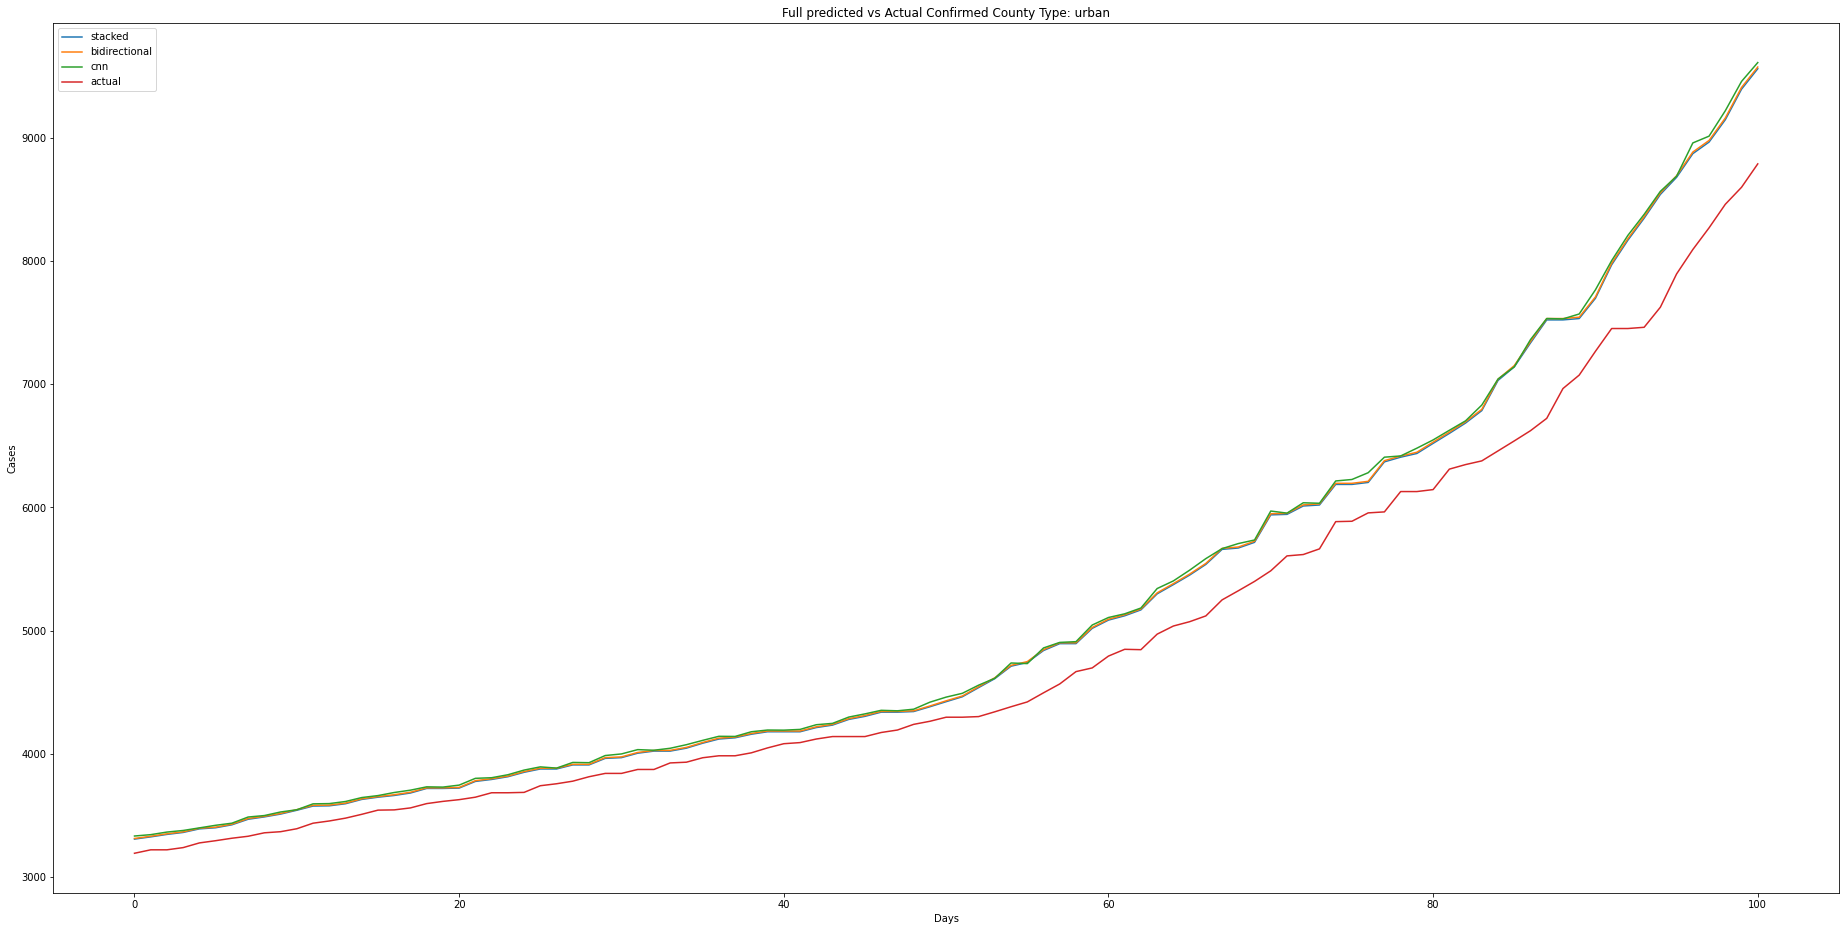

<Figure size 432x288 with 0 Axes>

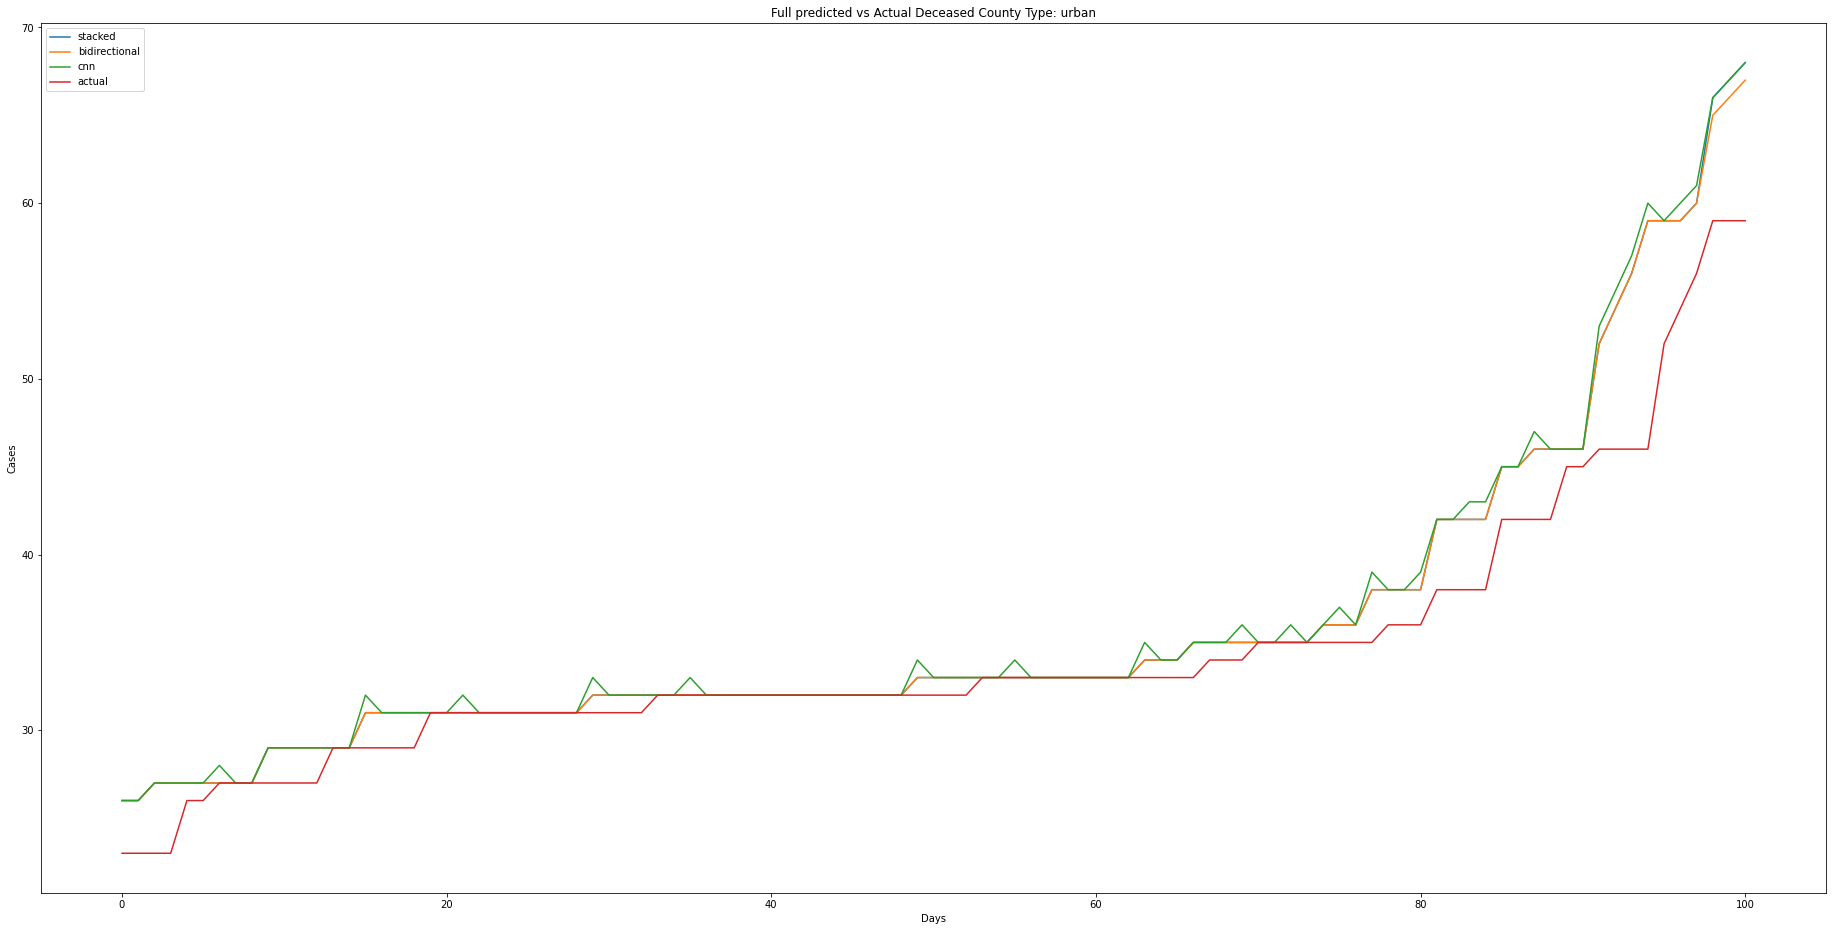

<Figure size 432x288 with 0 Axes>

In [ ]:
## Now try to get graphs for full run of act/pred - this takes much longer because need to run through full 150 days
full_predd_conf_cnn, full_actt_conf, full_predd_dec_cnn, full_actt_dec = \
    calc_results(model=urban_cnn_model, weight_file_path=urban_cnn_weight_file, index=ci.index, X_test_pre=urban_X_test_pre,
              pop_test=urban_pop_test, y_test_pre=urban_y_test_pre, data_file=urban_cnn_data_location, verbose_flag=verbose_level)

full_predd_conf_bi, full_actt_conf, full_predd_dec_bi, full_actt_dec = \
    calc_results(model=urban_bidirectional_model, weight_file_path=urban_bi_weight_file, index=ci.index, X_test_pre=urban_X_test_pre,
              pop_test=urban_pop_test, y_test_pre=urban_y_test_pre, data_file=urban_bi_data_location, verbose_flag=verbose_level)

full_predd_conf_stacked, full_actt_conf, full_predd_dec_stacked, full_actt_dec= \
    calc_results(model=urban_stacked_model, weight_file_path=urban_stacked_weight_file, index=ci.index, X_test_pre=urban_X_test_pre,
              pop_test=urban_pop_test, y_test_pre=urban_y_test_pre, data_file=urban_stacked_data_location, verbose_flag=verbose_level)

# Plot out the difference between actual and predicted for test data
plot_pred_vs_act_full_test(full_predd_conf_stacked, full_predd_conf_bi, full_predd_conf_cnn, full_actt_conf, urban_plot_full_conf_compare_location, county_type, isConfirmed=True)
plot_pred_vs_act_full_test(full_predd_dec_stacked, full_predd_dec_bi, full_predd_dec_cnn, full_actt_dec, urban_plot_full_desc_compare_location, county_type, isConfirmed=False)
